In [1]:
import numpy as np
import pandas as pd
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
#from OfficialWork.SIOA.TrafficFlowForecast.SourceCode.DP_LSTM import *
from DP_LSTM import *

Using TensorFlow backend.


In [2]:
data_pd = pd.read_csv(r'/home/wells/Wells/OfficialWork/SIOA/TrafficFlowForecast/SourceData/数据.csv',encoding='GBK')

In [3]:
# 输入数据文件， 输出每分钟总流量
def data_process(data_pd):
    time_iter = list(np.unique(data_pd['时间']))
    flow_container = []
    time_container = []
    for time_point in time_iter:
        selected_pd = data_pd.loc[data_pd['时间'] == time_point]
        flow_val = np.sum(selected_pd['上车人数']) + np.sum(selected_pd['下车人数']) 
        time_container.append(time_point)
        flow_container.append(flow_val)
    return pd.DataFrame({'Time':time_container, 'Flow_Val':flow_container})

# 输入timescale，输出滚动窗口长度timescale下，timescale时间范围内的流量
def statistic_flow_scale(flow_pd, time_scale):
    flow_container = []
    time_container = []
    for index in range(flow_pd.shape[0]-time_scale+1):
        time_container.append(flow_pd['Time'][index])
        flow_container.append(np.sum(flow_pd['Flow_Val'][index:index + time_scale]))
    res_pd = pd.DataFrame({'Time':time_container, 'Flow_sum':flow_container})
    res_pd['Time'] = pd.to_datetime(res_pd['Time'])
    return res_pd

In [4]:
def data_normalized(raw_df): # 标准化数据
    data_pd = raw_df.copy()
    mm_scaler = MinMaxScaler(feature_range=(0.1,1))
    scaled_Data = mm_scaler.fit_transform(np.reshape(data_pd['Flow_sum'].get_values(),(data_pd['Flow_sum'].shape[0],1)))
    data_pd['Flow_sum_trans'] = scaled_Data
    return data_pd,mm_scaler

def get_timeSeries(normalized_pd, feature,TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    time_container = []
    for index in range(len(normalized_pd) - sequence_length+1):
        result.append(normalized_pd[feature][index: index + sequence_length])
        time_container.append(normalized_pd['Time'][index])
    return np.array(result),time_container

In [5]:
def lstm_predict(data_pd,params):
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE'])
    line_pd = pd.DataFrame(columns=['TimeLags','RMSE','MAE','MAPE'])
    # 对数据进行预处理
    # 计算每分钟值
    flow_pd = data_process(data_pd)
    #按时间跨度进行汇总
    sum_pd = statistic_flow_scale(flow_pd, params['Timescale'])
    # 归一化
    normalized_pd,mm_scaler = data_normalized(sum_pd)
    print(r'处理数据:',normalized_pd.shape)
    # 构造时间序列数据
    TimeSeries,time_container = get_timeSeries(normalized_pd, 'Flow_sum_trans',TimeLag=params['TimeLag'])
    # 划分训练测试集
    TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
    print(r'训练数据:',TrainSeries.shape)
    TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
    print(r'验证数据:',TestSeries.shape)
    TrainSeries_X = TrainSeries[:,:-1]
    TrainSeries_Y = TrainSeries[:,-1]
    TestSeries_X = TestSeries[:,:-1]
    TestSeries_Y = TestSeries[:,-1]
    # 张量化
    Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
    Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
    Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
    Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
    print(r'LSTM预测')
    lstm_model = build_lstm_model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
    fitted_model = model_fit(lstm_model,Train_X, Train_Y, validation_split=0.2, epochs=params['epochs'], batch_size=params['batch_size'])
    RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(fitted_model,Test_X,Test_Y,mm_scaler)
    line_pd['RMSE'] = [RMSE]
    line_pd['MAE'] = [MAE]
    line_pd['MAPE'] = [MAPE]
    line_pd['TimeLags'] = [params['TimeLag']]
    
    result_pd = pd.concat([result_pd, line_pd])
    return fitted_model,TimeSeries,time_container,mm_scaler

In [6]:
# 输入x, y 画出真实值和预测值随时间分布图,默认用全部数据重新进行预测并绘制图片（mode='full'），
# mode设置为其他的值就只用测试数据进行绘图
def predict_and_plot(fitted_model, TimeSeries,time_container,mm_scaler,param, mode='full'):
    arrary_x = TimeSeries[:, :-1]
    label_y = TimeSeries[:, -1]
    if mode != 'full':
        arrary_x = TimeSeries[round(len(TimeSeries)*param['TrainTestSplit']):, :-1]
        label_y = TimeSeries[round(len(TimeSeries)*param['TrainTestSplit']):, -1]
        time_container = time_container[round(len(TimeSeries)*param['TrainTestSplit']):]
        
    tensor_x = np.reshape(arrary_x, (arrary_x.shape[0], 1,arrary_x.shape[1]))
    tensor_y = np.reshape(label_y, (label_y.shape[0], 1,1))
    
    predict_val = fitted_model.predict(tensor_x)
    predict_val = mm_scaler.inverse_transform(predict_val.reshape(predict_val.shape[0],1))
    
    true_val = mm_scaler.inverse_transform(tensor_y.reshape(tensor_y.shape[0],1))
    
    rmse = evaluation_RMSE(true_val,predict_val)
    mae = evaluation_MAE(true_val,predict_val)
    mape = evaluation_MAPE(true_val,predict_val)
    print('RMSE:%s  ,MAE:%s  ,MAPE:%s '%(rmse,mae,mape))
    # 绘图
    fig= plt.figure(figsize=(10,6))
    ax=plt.gca()
    mondayFormatter = DateFormatter('%H:%M')
    plt.plot(time_container, true_val, 'g-s', label='Real',color='black')
    plt.plot(time_container, predict_val, 'g-o', label='Predict-TimeLag_%s'%arrary_x.shape[1],color='g')
    plt.xlabel(r'Time')
    plt.ylabel(r'Volumn')
    ax.xaxis.set_major_formatter(mondayFormatter)
    for rt in ax.get_xticklabels():
        rt.set_rotation(30)
    plt.legend()
    plt.savefig(param['pic_path']+'/Predict-TimeLag_%s_mode_%s'%(arrary_x.shape[1], mode)+ r'.png')
    plt.show()

/home/wells/Anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
W0820 18:30:09.437862 139984552650496 deprecation_wrapper.py:119] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0820 18:30:09.489531 139984552650496 deprecation_wrapper.py:119] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0820 18:30:09.491611 139984552650496 deprecation_wrapper.py:119] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



处理数据: (177, 3)
训练数据: (103, 6)
验证数据: (69, 6)
LSTM预测


W0820 18:30:10.018631 139984552650496 deprecation_wrapper.py:119] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0820 18:30:10.026397 139984552650496 deprecation.py:506] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0820 18:30:10.065728 139984552650496 deprecation_wrapper.py:119] From /home/wells/Anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0820 18:30:10.388174 139984552650496 deprecation.py:323] From /home/wells/Anaconda3/lib/python3

Train on 82 samples, validate on 21 samples
Epoch 1/2000
82/82 [==============================] - 4s 46ms/step - loss: 0.2880 - mean_absolute_error: 0.5102 - mean_absolute_percentage_error: 100.0881 - val_loss: 0.4278 - val_mean_absolute_error: 0.6312 - val_mean_absolute_percentage_error: 99.7930
Epoch 2/2000
82/82 [==============================] - 0s 377us/step - loss: 0.2859 - mean_absolute_error: 0.5081 - mean_absolute_percentage_error: 99.6194 - val_loss: 0.4251 - val_mean_absolute_error: 0.6290 - val_mean_absolute_percentage_error: 99.4342
Epoch 3/2000
82/82 [==============================] - 0s 333us/step - loss: 0.2838 - mean_absolute_error: 0.5061 - mean_absolute_percentage_error: 99.1816 - val_loss: 0.4223 - val_mean_absolute_error: 0.6269 - val_mean_absolute_percentage_error: 99.0707
Epoch 4/2000
82/82 [==============================] - 0s 331us/step - loss: 0.2818 - mean_absolute_error: 0.5042 - mean_absolute_percentage_error: 98.7544 - val_loss: 0.4196 - val_mean_absolute_

Epoch 33/2000
82/82 [==============================] - 0s 378us/step - loss: 0.2206 - mean_absolute_error: 0.4412 - mean_absolute_percentage_error: 85.0269 - val_loss: 0.3335 - val_mean_absolute_error: 0.5522 - val_mean_absolute_percentage_error: 86.6006
Epoch 34/2000
82/82 [==============================] - 0s 355us/step - loss: 0.2178 - mean_absolute_error: 0.4380 - mean_absolute_percentage_error: 84.3749 - val_loss: 0.3300 - val_mean_absolute_error: 0.5490 - val_mean_absolute_percentage_error: 86.0711
Epoch 35/2000
82/82 [==============================] - 0s 374us/step - loss: 0.2148 - mean_absolute_error: 0.4346 - mean_absolute_percentage_error: 83.6381 - val_loss: 0.3264 - val_mean_absolute_error: 0.5457 - val_mean_absolute_percentage_error: 85.5280
Epoch 36/2000
82/82 [==============================] - 0s 386us/step - loss: 0.2126 - mean_absolute_error: 0.4320 - mean_absolute_percentage_error: 83.0434 - val_loss: 0.3228 - val_mean_absolute_error: 0.5424 - val_mean_absolute_percen

82/82 [==============================] - 0s 346us/step - loss: 0.1225 - mean_absolute_error: 0.3158 - mean_absolute_percentage_error: 58.0938 - val_loss: 0.1903 - val_mean_absolute_error: 0.4032 - val_mean_absolute_percentage_error: 61.7325
Epoch 66/2000
82/82 [==============================] - 0s 334us/step - loss: 0.1187 - mean_absolute_error: 0.3100 - mean_absolute_percentage_error: 56.7669 - val_loss: 0.1852 - val_mean_absolute_error: 0.3968 - val_mean_absolute_percentage_error: 60.6602
Epoch 67/2000
82/82 [==============================] - 0s 336us/step - loss: 0.1167 - mean_absolute_error: 0.3062 - mean_absolute_percentage_error: 55.9266 - val_loss: 0.1800 - val_mean_absolute_error: 0.3902 - val_mean_absolute_percentage_error: 59.5730
Epoch 68/2000
82/82 [==============================] - 0s 313us/step - loss: 0.1123 - mean_absolute_error: 0.3000 - mean_absolute_percentage_error: 54.8259 - val_loss: 0.1749 - val_mean_absolute_error: 0.3836 - val_mean_absolute_percentage_error: 58

82/82 [==============================] - 0s 438us/step - loss: 0.0370 - mean_absolute_error: 0.1545 - mean_absolute_percentage_error: 28.2056 - val_loss: 0.0581 - val_mean_absolute_error: 0.1788 - val_mean_absolute_percentage_error: 24.4418
Epoch 98/2000
82/82 [==============================] - 0s 353us/step - loss: 0.0360 - mean_absolute_error: 0.1529 - mean_absolute_percentage_error: 28.1120 - val_loss: 0.0559 - val_mean_absolute_error: 0.1731 - val_mean_absolute_percentage_error: 23.5023
Epoch 99/2000
82/82 [==============================] - 0s 340us/step - loss: 0.0343 - mean_absolute_error: 0.1506 - mean_absolute_percentage_error: 28.0525 - val_loss: 0.0537 - val_mean_absolute_error: 0.1679 - val_mean_absolute_percentage_error: 22.6926
Epoch 100/2000
82/82 [==============================] - 0s 319us/step - loss: 0.0322 - mean_absolute_error: 0.1437 - mean_absolute_percentage_error: 26.4636 - val_loss: 0.0518 - val_mean_absolute_error: 0.1628 - val_mean_absolute_percentage_error: 2

82/82 [==============================] - 0s 310us/step - loss: 0.0205 - mean_absolute_error: 0.1106 - mean_absolute_percentage_error: 24.8197 - val_loss: 0.0312 - val_mean_absolute_error: 0.1333 - val_mean_absolute_percentage_error: 19.0371
Epoch 130/2000
82/82 [==============================] - 0s 298us/step - loss: 0.0202 - mean_absolute_error: 0.1115 - mean_absolute_percentage_error: 24.9431 - val_loss: 0.0311 - val_mean_absolute_error: 0.1334 - val_mean_absolute_percentage_error: 19.0857
Epoch 131/2000
82/82 [==============================] - 0s 308us/step - loss: 0.0191 - mean_absolute_error: 0.1096 - mean_absolute_percentage_error: 24.6502 - val_loss: 0.0310 - val_mean_absolute_error: 0.1335 - val_mean_absolute_percentage_error: 19.1387
Epoch 132/2000
82/82 [==============================] - 0s 304us/step - loss: 0.0196 - mean_absolute_error: 0.1086 - mean_absolute_percentage_error: 24.9045 - val_loss: 0.0309 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 320us/step - loss: 0.0185 - mean_absolute_error: 0.1047 - mean_absolute_percentage_error: 24.5183 - val_loss: 0.0298 - val_mean_absolute_error: 0.1338 - val_mean_absolute_percentage_error: 19.5324
Epoch 162/2000
82/82 [==============================] - 0s 321us/step - loss: 0.0198 - mean_absolute_error: 0.1084 - mean_absolute_percentage_error: 25.1357 - val_loss: 0.0298 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 19.5310
Epoch 163/2000
82/82 [==============================] - 0s 303us/step - loss: 0.0197 - mean_absolute_error: 0.1074 - mean_absolute_percentage_error: 25.1784 - val_loss: 0.0298 - val_mean_absolute_error: 0.1337 - val_mean_absolute_percentage_error: 19.5245
Epoch 164/2000
82/82 [==============================] - 0s 313us/step - loss: 0.0180 - mean_absolute_error: 0.1030 - mean_absolute_percentage_error: 24.0019 - val_loss: 0.0297 - val_mean_absolute_error: 0.1336 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 358us/step - loss: 0.0187 - mean_absolute_error: 0.1043 - mean_absolute_percentage_error: 24.4842 - val_loss: 0.0288 - val_mean_absolute_error: 0.1302 - val_mean_absolute_percentage_error: 18.9496
Epoch 194/2000
82/82 [==============================] - 0s 361us/step - loss: 0.0182 - mean_absolute_error: 0.1046 - mean_absolute_percentage_error: 24.4439 - val_loss: 0.0288 - val_mean_absolute_error: 0.1301 - val_mean_absolute_percentage_error: 18.9313
Epoch 195/2000
82/82 [==============================] - 0s 396us/step - loss: 0.0192 - mean_absolute_error: 0.1060 - mean_absolute_percentage_error: 24.6422 - val_loss: 0.0287 - val_mean_absolute_error: 0.1300 - val_mean_absolute_percentage_error: 18.9101
Epoch 196/2000
82/82 [==============================] - 0s 357us/step - loss: 0.0192 - mean_absolute_error: 0.1065 - mean_absolute_percentage_error: 25.1037 - val_loss: 0.0287 - val_mean_absolute_error: 0.1299 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 321us/step - loss: 0.0179 - mean_absolute_error: 0.1009 - mean_absolute_percentage_error: 23.5883 - val_loss: 0.0276 - val_mean_absolute_error: 0.1262 - val_mean_absolute_percentage_error: 18.3207
Epoch 226/2000
82/82 [==============================] - 0s 327us/step - loss: 0.0185 - mean_absolute_error: 0.1021 - mean_absolute_percentage_error: 23.8856 - val_loss: 0.0276 - val_mean_absolute_error: 0.1261 - val_mean_absolute_percentage_error: 18.3077
Epoch 227/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0186 - mean_absolute_error: 0.1049 - mean_absolute_percentage_error: 24.5820 - val_loss: 0.0275 - val_mean_absolute_error: 0.1260 - val_mean_absolute_percentage_error: 18.2957
Epoch 228/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0191 - mean_absolute_error: 0.1087 - mean_absolute_percentage_error: 25.1494 - val_loss: 0.0275 - val_mean_absolute_error: 0.1259 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 406us/step - loss: 0.0175 - mean_absolute_error: 0.1039 - mean_absolute_percentage_error: 24.6750 - val_loss: 0.0263 - val_mean_absolute_error: 0.1223 - val_mean_absolute_percentage_error: 17.7569
Epoch 258/2000
82/82 [==============================] - 0s 370us/step - loss: 0.0176 - mean_absolute_error: 0.1016 - mean_absolute_percentage_error: 23.8944 - val_loss: 0.0263 - val_mean_absolute_error: 0.1221 - val_mean_absolute_percentage_error: 17.7360
Epoch 259/2000
82/82 [==============================] - 0s 319us/step - loss: 0.0177 - mean_absolute_error: 0.1025 - mean_absolute_percentage_error: 24.1057 - val_loss: 0.0263 - val_mean_absolute_error: 0.1220 - val_mean_absolute_percentage_error: 17.7163
Epoch 260/2000
82/82 [==============================] - 0s 366us/step - loss: 0.0164 - mean_absolute_error: 0.0978 - mean_absolute_percentage_error: 23.0452 - val_loss: 0.0262 - val_mean_absolute_error: 0.1219 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 397us/step - loss: 0.0173 - mean_absolute_error: 0.1028 - mean_absolute_percentage_error: 24.3384 - val_loss: 0.0251 - val_mean_absolute_error: 0.1177 - val_mean_absolute_percentage_error: 17.0366
Epoch 290/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0177 - mean_absolute_error: 0.1037 - mean_absolute_percentage_error: 24.3801 - val_loss: 0.0251 - val_mean_absolute_error: 0.1175 - val_mean_absolute_percentage_error: 17.0094
Epoch 291/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0166 - mean_absolute_error: 0.1005 - mean_absolute_percentage_error: 23.4272 - val_loss: 0.0250 - val_mean_absolute_error: 0.1174 - val_mean_absolute_percentage_error: 16.9798
Epoch 292/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0172 - mean_absolute_error: 0.1012 - mean_absolute_percentage_error: 24.1415 - val_loss: 0.0250 - val_mean_absolute_error: 0.1172 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 336us/step - loss: 0.0152 - mean_absolute_error: 0.0961 - mean_absolute_percentage_error: 22.8886 - val_loss: 0.0238 - val_mean_absolute_error: 0.1127 - val_mean_absolute_percentage_error: 16.2710
Epoch 322/2000
82/82 [==============================] - 0s 327us/step - loss: 0.0152 - mean_absolute_error: 0.0955 - mean_absolute_percentage_error: 22.8058 - val_loss: 0.0238 - val_mean_absolute_error: 0.1125 - val_mean_absolute_percentage_error: 16.2368
Epoch 323/2000
82/82 [==============================] - 0s 384us/step - loss: 0.0155 - mean_absolute_error: 0.0948 - mean_absolute_percentage_error: 22.5644 - val_loss: 0.0238 - val_mean_absolute_error: 0.1123 - val_mean_absolute_percentage_error: 16.2034
Epoch 324/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0151 - mean_absolute_error: 0.0959 - mean_absolute_percentage_error: 22.6532 - val_loss: 0.0237 - val_mean_absolute_error: 0.1121 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 369us/step - loss: 0.0146 - mean_absolute_error: 0.0912 - mean_absolute_percentage_error: 22.0767 - val_loss: 0.0226 - val_mean_absolute_error: 0.1072 - val_mean_absolute_percentage_error: 15.4185
Epoch 354/2000
82/82 [==============================] - 0s 354us/step - loss: 0.0147 - mean_absolute_error: 0.0932 - mean_absolute_percentage_error: 22.2436 - val_loss: 0.0226 - val_mean_absolute_error: 0.1070 - val_mean_absolute_percentage_error: 15.3767
Epoch 355/2000
82/82 [==============================] - 0s 345us/step - loss: 0.0140 - mean_absolute_error: 0.0912 - mean_absolute_percentage_error: 21.7959 - val_loss: 0.0225 - val_mean_absolute_error: 0.1068 - val_mean_absolute_percentage_error: 15.3410
Epoch 356/2000
82/82 [==============================] - 0s 441us/step - loss: 0.0134 - mean_absolute_error: 0.0907 - mean_absolute_percentage_error: 21.7173 - val_loss: 0.0225 - val_mean_absolute_error: 0.1066 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 323us/step - loss: 0.0130 - mean_absolute_error: 0.0884 - mean_absolute_percentage_error: 21.2388 - val_loss: 0.0213 - val_mean_absolute_error: 0.1019 - val_mean_absolute_percentage_error: 14.6924
Epoch 386/2000
82/82 [==============================] - 0s 340us/step - loss: 0.0139 - mean_absolute_error: 0.0924 - mean_absolute_percentage_error: 22.2490 - val_loss: 0.0213 - val_mean_absolute_error: 0.1017 - val_mean_absolute_percentage_error: 14.6559
Epoch 387/2000
82/82 [==============================] - 0s 350us/step - loss: 0.0150 - mean_absolute_error: 0.0925 - mean_absolute_percentage_error: 21.9441 - val_loss: 0.0212 - val_mean_absolute_error: 0.1015 - val_mean_absolute_percentage_error: 14.6155
Epoch 388/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0136 - mean_absolute_error: 0.0883 - mean_absolute_percentage_error: 21.5753 - val_loss: 0.0212 - val_mean_absolute_error: 0.1013 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 398us/step - loss: 0.0134 - mean_absolute_error: 0.0903 - mean_absolute_percentage_error: 21.6667 - val_loss: 0.0204 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_error: 13.7800
Epoch 418/2000
82/82 [==============================] - 0s 381us/step - loss: 0.0129 - mean_absolute_error: 0.0865 - mean_absolute_percentage_error: 20.7195 - val_loss: 0.0203 - val_mean_absolute_error: 0.0961 - val_mean_absolute_percentage_error: 13.7683
Epoch 419/2000
82/82 [==============================] - 0s 329us/step - loss: 0.0138 - mean_absolute_error: 0.0899 - mean_absolute_percentage_error: 21.5037 - val_loss: 0.0203 - val_mean_absolute_error: 0.0960 - val_mean_absolute_percentage_error: 13.7546
Epoch 420/2000
82/82 [==============================] - 0s 331us/step - loss: 0.0121 - mean_absolute_error: 0.0853 - mean_absolute_percentage_error: 20.5738 - val_loss: 0.0202 - val_mean_absolute_error: 0.0959 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 383us/step - loss: 0.0129 - mean_absolute_error: 0.0871 - mean_absolute_percentage_error: 21.1269 - val_loss: 0.0195 - val_mean_absolute_error: 0.0928 - val_mean_absolute_percentage_error: 13.3034
Epoch 450/2000
82/82 [==============================] - 0s 335us/step - loss: 0.0127 - mean_absolute_error: 0.0857 - mean_absolute_percentage_error: 20.7019 - val_loss: 0.0194 - val_mean_absolute_error: 0.0927 - val_mean_absolute_percentage_error: 13.2902
Epoch 451/2000
82/82 [==============================] - 0s 377us/step - loss: 0.0135 - mean_absolute_error: 0.0890 - mean_absolute_percentage_error: 21.3320 - val_loss: 0.0194 - val_mean_absolute_error: 0.0926 - val_mean_absolute_percentage_error: 13.2763
Epoch 452/2000
82/82 [==============================] - 0s 346us/step - loss: 0.0124 - mean_absolute_error: 0.0856 - mean_absolute_percentage_error: 20.5107 - val_loss: 0.0194 - val_mean_absolute_error: 0.0925 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 339us/step - loss: 0.0122 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 20.6202 - val_loss: 0.0187 - val_mean_absolute_error: 0.0895 - val_mean_absolute_percentage_error: 12.8900
Epoch 482/2000
82/82 [==============================] - 0s 368us/step - loss: 0.0122 - mean_absolute_error: 0.0875 - mean_absolute_percentage_error: 20.8814 - val_loss: 0.0187 - val_mean_absolute_error: 0.0895 - val_mean_absolute_percentage_error: 12.8761
Epoch 483/2000
82/82 [==============================] - 0s 327us/step - loss: 0.0115 - mean_absolute_error: 0.0845 - mean_absolute_percentage_error: 20.3994 - val_loss: 0.0187 - val_mean_absolute_error: 0.0894 - val_mean_absolute_percentage_error: 12.8629
Epoch 484/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0120 - mean_absolute_error: 0.0835 - mean_absolute_percentage_error: 20.3117 - val_loss: 0.0187 - val_mean_absolute_error: 0.0894 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 377us/step - loss: 0.0114 - mean_absolute_error: 0.0826 - mean_absolute_percentage_error: 20.1010 - val_loss: 0.0182 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error: 12.5393
Epoch 514/2000
82/82 [==============================] - 0s 344us/step - loss: 0.0121 - mean_absolute_error: 0.0845 - mean_absolute_percentage_error: 20.8115 - val_loss: 0.0182 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error: 12.5374
Epoch 515/2000
82/82 [==============================] - 0s 379us/step - loss: 0.0122 - mean_absolute_error: 0.0840 - mean_absolute_percentage_error: 20.4278 - val_loss: 0.0182 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error: 12.5356
Epoch 516/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0119 - mean_absolute_error: 0.0860 - mean_absolute_percentage_error: 20.9170 - val_loss: 0.0181 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 384us/step - loss: 0.0115 - mean_absolute_error: 0.0838 - mean_absolute_percentage_error: 20.3694 - val_loss: 0.0177 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 12.3636
Epoch 546/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0120 - mean_absolute_error: 0.0832 - mean_absolute_percentage_error: 20.3446 - val_loss: 0.0177 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 12.3578
Epoch 547/2000
82/82 [==============================] - 0s 373us/step - loss: 0.0110 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 19.3794 - val_loss: 0.0177 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 12.3589
Epoch 548/2000
82/82 [==============================] - 0s 311us/step - loss: 0.0121 - mean_absolute_error: 0.0829 - mean_absolute_percentage_error: 20.3462 - val_loss: 0.0177 - val_mean_absolute_error: 0.0852 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 318us/step - loss: 0.0101 - mean_absolute_error: 0.0770 - mean_absolute_percentage_error: 18.7583 - val_loss: 0.0175 - val_mean_absolute_error: 0.0849 - val_mean_absolute_percentage_error: 12.3616
Epoch 578/2000
82/82 [==============================] - 0s 310us/step - loss: 0.0105 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 19.8726 - val_loss: 0.0175 - val_mean_absolute_error: 0.0849 - val_mean_absolute_percentage_error: 12.3720
Epoch 579/2000
82/82 [==============================] - 0s 314us/step - loss: 0.0100 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 18.9715 - val_loss: 0.0175 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 12.3747
Epoch 580/2000
82/82 [==============================] - 0s 313us/step - loss: 0.0109 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 19.4896 - val_loss: 0.0175 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 368us/step - loss: 0.0111 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 19.3947 - val_loss: 0.0174 - val_mean_absolute_error: 0.0848 - val_mean_absolute_percentage_error: 12.4111
Epoch 610/2000
82/82 [==============================] - 0s 341us/step - loss: 0.0116 - mean_absolute_error: 0.0834 - mean_absolute_percentage_error: 20.3137 - val_loss: 0.0175 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 12.4299
Epoch 611/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0108 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 19.4354 - val_loss: 0.0175 - val_mean_absolute_error: 0.0851 - val_mean_absolute_percentage_error: 12.4471
Epoch 612/2000
82/82 [==============================] - 0s 346us/step - loss: 0.0112 - mean_absolute_error: 0.0826 - mean_absolute_percentage_error: 19.6428 - val_loss: 0.0174 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 334us/step - loss: 0.0112 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 19.7725 - val_loss: 0.0173 - val_mean_absolute_error: 0.0843 - val_mean_absolute_percentage_error: 12.4095
Epoch 642/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0108 - mean_absolute_error: 0.0770 - mean_absolute_percentage_error: 19.0429 - val_loss: 0.0173 - val_mean_absolute_error: 0.0843 - val_mean_absolute_percentage_error: 12.4090
Epoch 643/2000
82/82 [==============================] - 0s 373us/step - loss: 0.0101 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 19.0281 - val_loss: 0.0173 - val_mean_absolute_error: 0.0840 - val_mean_absolute_percentage_error: 12.3838
Epoch 644/2000
82/82 [==============================] - 0s 376us/step - loss: 0.0109 - mean_absolute_error: 0.0796 - mean_absolute_percentage_error: 19.4579 - val_loss: 0.0172 - val_mean_absolute_error: 0.0839 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 358us/step - loss: 0.0104 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 19.3976 - val_loss: 0.0171 - val_mean_absolute_error: 0.0829 - val_mean_absolute_percentage_error: 12.3004
Epoch 674/2000
82/82 [==============================] - 0s 362us/step - loss: 0.0109 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 19.2861 - val_loss: 0.0171 - val_mean_absolute_error: 0.0830 - val_mean_absolute_percentage_error: 12.3054
Epoch 675/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0103 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 18.8556 - val_loss: 0.0171 - val_mean_absolute_error: 0.0832 - val_mean_absolute_percentage_error: 12.3283
Epoch 676/2000
82/82 [==============================] - 0s 389us/step - loss: 0.0105 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 19.6615 - val_loss: 0.0172 - val_mean_absolute_error: 0.0835 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 364us/step - loss: 0.0102 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 18.6461 - val_loss: 0.0171 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3102
Epoch 706/2000
82/82 [==============================] - 0s 364us/step - loss: 0.0107 - mean_absolute_error: 0.0794 - mean_absolute_percentage_error: 19.3956 - val_loss: 0.0171 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error: 12.3076
Epoch 707/2000
82/82 [==============================] - 0s 325us/step - loss: 0.0105 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 19.2855 - val_loss: 0.0171 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3139
Epoch 708/2000
82/82 [==============================] - 0s 311us/step - loss: 0.0105 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 19.0161 - val_loss: 0.0171 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 338us/step - loss: 0.0108 - mean_absolute_error: 0.0805 - mean_absolute_percentage_error: 19.8227 - val_loss: 0.0172 - val_mean_absolute_error: 0.0829 - val_mean_absolute_percentage_error: 12.3715
Epoch 738/2000
82/82 [==============================] - 0s 322us/step - loss: 0.0102 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 18.7630 - val_loss: 0.0172 - val_mean_absolute_error: 0.0832 - val_mean_absolute_percentage_error: 12.4052
Epoch 739/2000
82/82 [==============================] - 0s 326us/step - loss: 0.0094 - mean_absolute_error: 0.0749 - mean_absolute_percentage_error: 18.5214 - val_loss: 0.0173 - val_mean_absolute_error: 0.0833 - val_mean_absolute_percentage_error: 12.4229
Epoch 740/2000
82/82 [==============================] - 0s 319us/step - loss: 0.0106 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 19.5148 - val_loss: 0.0173 - val_mean_absolute_error: 0.0836 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 343us/step - loss: 0.0097 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 19.0743 - val_loss: 0.0172 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3722
Epoch 770/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0105 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 18.7424 - val_loss: 0.0172 - val_mean_absolute_error: 0.0829 - val_mean_absolute_percentage_error: 12.3902
Epoch 771/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0100 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 18.5583 - val_loss: 0.0172 - val_mean_absolute_error: 0.0828 - val_mean_absolute_percentage_error: 12.3844
Epoch 772/2000
82/82 [==============================] - 0s 326us/step - loss: 0.0108 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 19.1047 - val_loss: 0.0172 - val_mean_absolute_error: 0.0829 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 368us/step - loss: 0.0100 - mean_absolute_error: 0.0763 - mean_absolute_percentage_error: 18.6438 - val_loss: 0.0171 - val_mean_absolute_error: 0.0815 - val_mean_absolute_percentage_error: 12.2516
Epoch 802/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0106 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 19.3302 - val_loss: 0.0171 - val_mean_absolute_error: 0.0815 - val_mean_absolute_percentage_error: 12.2529
Epoch 803/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0104 - mean_absolute_error: 0.0793 - mean_absolute_percentage_error: 19.3521 - val_loss: 0.0171 - val_mean_absolute_error: 0.0816 - val_mean_absolute_percentage_error: 12.2684
Epoch 804/2000
82/82 [==============================] - 0s 324us/step - loss: 0.0090 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 17.5151 - val_loss: 0.0171 - val_mean_absolute_error: 0.0817 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 328us/step - loss: 0.0106 - mean_absolute_error: 0.0765 - mean_absolute_percentage_error: 18.8957 - val_loss: 0.0172 - val_mean_absolute_error: 0.0821 - val_mean_absolute_percentage_error: 12.3292
Epoch 834/2000
82/82 [==============================] - 0s 378us/step - loss: 0.0100 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 18.8547 - val_loss: 0.0172 - val_mean_absolute_error: 0.0819 - val_mean_absolute_percentage_error: 12.3091
Epoch 835/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0102 - mean_absolute_error: 0.0780 - mean_absolute_percentage_error: 19.0034 - val_loss: 0.0172 - val_mean_absolute_error: 0.0817 - val_mean_absolute_percentage_error: 12.2899
Epoch 836/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0092 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 18.2653 - val_loss: 0.0172 - val_mean_absolute_error: 0.0816 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 337us/step - loss: 0.0105 - mean_absolute_error: 0.0786 - mean_absolute_percentage_error: 19.5892 - val_loss: 0.0171 - val_mean_absolute_error: 0.0811 - val_mean_absolute_percentage_error: 12.2221
Epoch 866/2000
82/82 [==============================] - 0s 326us/step - loss: 0.0110 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 19.2701 - val_loss: 0.0172 - val_mean_absolute_error: 0.0815 - val_mean_absolute_percentage_error: 12.2699
Epoch 867/2000
82/82 [==============================] - 0s 326us/step - loss: 0.0104 - mean_absolute_error: 0.0769 - mean_absolute_percentage_error: 19.0758 - val_loss: 0.0172 - val_mean_absolute_error: 0.0816 - val_mean_absolute_percentage_error: 12.2800
Epoch 868/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0101 - mean_absolute_error: 0.0757 - mean_absolute_percentage_error: 18.5990 - val_loss: 0.0172 - val_mean_absolute_error: 0.0815 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 323us/step - loss: 0.0090 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 17.9709 - val_loss: 0.0171 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error: 12.1638
Epoch 898/2000
82/82 [==============================] - 0s 358us/step - loss: 0.0105 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 19.4349 - val_loss: 0.0171 - val_mean_absolute_error: 0.0803 - val_mean_absolute_percentage_error: 12.1347
Epoch 899/2000
82/82 [==============================] - 0s 415us/step - loss: 0.0096 - mean_absolute_error: 0.0727 - mean_absolute_percentage_error: 17.9090 - val_loss: 0.0171 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error: 12.1301
Epoch 900/2000
82/82 [==============================] - 0s 363us/step - loss: 0.0102 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 18.6812 - val_loss: 0.0171 - val_mean_absolute_error: 0.0805 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 345us/step - loss: 0.0098 - mean_absolute_error: 0.0770 - mean_absolute_percentage_error: 18.6576 - val_loss: 0.0170 - val_mean_absolute_error: 0.0798 - val_mean_absolute_percentage_error: 12.0817
Epoch 930/2000
82/82 [==============================] - 0s 316us/step - loss: 0.0094 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 18.4219 - val_loss: 0.0170 - val_mean_absolute_error: 0.0798 - val_mean_absolute_percentage_error: 12.0735
Epoch 931/2000
82/82 [==============================] - 0s 346us/step - loss: 0.0089 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 18.2099 - val_loss: 0.0170 - val_mean_absolute_error: 0.0797 - val_mean_absolute_percentage_error: 12.0618
Epoch 932/2000
82/82 [==============================] - 0s 344us/step - loss: 0.0100 - mean_absolute_error: 0.0762 - mean_absolute_percentage_error: 18.9228 - val_loss: 0.0170 - val_mean_absolute_error: 0.0797 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 323us/step - loss: 0.0102 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 18.7628 - val_loss: 0.0171 - val_mean_absolute_error: 0.0800 - val_mean_absolute_percentage_error: 12.0974
Epoch 962/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0099 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 18.3603 - val_loss: 0.0171 - val_mean_absolute_error: 0.0801 - val_mean_absolute_percentage_error: 12.1139
Epoch 963/2000
82/82 [==============================] - 0s 307us/step - loss: 0.0101 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 18.7282 - val_loss: 0.0171 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error: 12.1233
Epoch 964/2000
82/82 [==============================] - 0s 306us/step - loss: 0.0099 - mean_absolute_error: 0.0769 - mean_absolute_percentage_error: 18.7954 - val_loss: 0.0171 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 391us/step - loss: 0.0104 - mean_absolute_error: 0.0779 - mean_absolute_percentage_error: 18.9829 - val_loss: 0.0172 - val_mean_absolute_error: 0.0803 - val_mean_absolute_percentage_error: 12.1222
Epoch 994/2000
82/82 [==============================] - 0s 382us/step - loss: 0.0099 - mean_absolute_error: 0.0774 - mean_absolute_percentage_error: 18.8133 - val_loss: 0.0172 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error: 12.1106
Epoch 995/2000
82/82 [==============================] - 0s 434us/step - loss: 0.0101 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 18.5935 - val_loss: 0.0172 - val_mean_absolute_error: 0.0802 - val_mean_absolute_percentage_error: 12.1114
Epoch 996/2000
82/82 [==============================] - 0s 435us/step - loss: 0.0095 - mean_absolute_error: 0.0760 - mean_absolute_percentage_error: 18.6690 - val_loss: 0.0171 - val_mean_absolute_error: 0.0801 - val_mean_absolute_percentage_error:

Epoch 1025/2000
82/82 [==============================] - 0s 314us/step - loss: 0.0101 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 18.8141 - val_loss: 0.0170 - val_mean_absolute_error: 0.0786 - val_mean_absolute_percentage_error: 11.9118
Epoch 1026/2000
82/82 [==============================] - 0s 325us/step - loss: 0.0096 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 17.8582 - val_loss: 0.0169 - val_mean_absolute_error: 0.0784 - val_mean_absolute_percentage_error: 11.8919
Epoch 1027/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0099 - mean_absolute_error: 0.0778 - mean_absolute_percentage_error: 19.1689 - val_loss: 0.0169 - val_mean_absolute_error: 0.0783 - val_mean_absolute_percentage_error: 11.8729
Epoch 1028/2000
82/82 [==============================] - 0s 327us/step - loss: 0.0095 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 18.2561 - val_loss: 0.0169 - val_mean_absolute_error: 0.0783 - val_mean_absolut

Epoch 1057/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0097 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.3015 - val_loss: 0.0171 - val_mean_absolute_error: 0.0797 - val_mean_absolute_percentage_error: 12.0334
Epoch 1058/2000
82/82 [==============================] - 0s 302us/step - loss: 0.0106 - mean_absolute_error: 0.0774 - mean_absolute_percentage_error: 18.9104 - val_loss: 0.0171 - val_mean_absolute_error: 0.0796 - val_mean_absolute_percentage_error: 12.0211
Epoch 1059/2000
82/82 [==============================] - 0s 318us/step - loss: 0.0096 - mean_absolute_error: 0.0755 - mean_absolute_percentage_error: 18.4779 - val_loss: 0.0171 - val_mean_absolute_error: 0.0796 - val_mean_absolute_percentage_error: 12.0157
Epoch 1060/2000
82/82 [==============================] - 0s 330us/step - loss: 0.0097 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 17.5982 - val_loss: 0.0171 - val_mean_absolute_error: 0.0794 - val_mean_absolut

Epoch 1089/2000
82/82 [==============================] - 0s 392us/step - loss: 0.0102 - mean_absolute_error: 0.0780 - mean_absolute_percentage_error: 19.1372 - val_loss: 0.0169 - val_mean_absolute_error: 0.0782 - val_mean_absolute_percentage_error: 11.8483
Epoch 1090/2000
82/82 [==============================] - 0s 366us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_absolute_percentage_error: 18.0848 - val_loss: 0.0169 - val_mean_absolute_error: 0.0785 - val_mean_absolute_percentage_error: 11.8754
Epoch 1091/2000
82/82 [==============================] - 0s 361us/step - loss: 0.0094 - mean_absolute_error: 0.0726 - mean_absolute_percentage_error: 17.8782 - val_loss: 0.0170 - val_mean_absolute_error: 0.0788 - val_mean_absolute_percentage_error: 11.9116
Epoch 1092/2000
82/82 [==============================] - 0s 352us/step - loss: 0.0096 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 18.2059 - val_loss: 0.0170 - val_mean_absolute_error: 0.0791 - val_mean_absolut

Epoch 1121/2000
82/82 [==============================] - 0s 362us/step - loss: 0.0095 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 18.2558 - val_loss: 0.0168 - val_mean_absolute_error: 0.0778 - val_mean_absolute_percentage_error: 11.7906
Epoch 1122/2000
82/82 [==============================] - 0s 371us/step - loss: 0.0099 - mean_absolute_error: 0.0757 - mean_absolute_percentage_error: 18.4815 - val_loss: 0.0168 - val_mean_absolute_error: 0.0777 - val_mean_absolute_percentage_error: 11.7821
Epoch 1123/2000
82/82 [==============================] - 0s 393us/step - loss: 0.0100 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 18.3269 - val_loss: 0.0168 - val_mean_absolute_error: 0.0778 - val_mean_absolute_percentage_error: 11.7870
Epoch 1124/2000
82/82 [==============================] - 0s 362us/step - loss: 0.0097 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 18.2939 - val_loss: 0.0168 - val_mean_absolute_error: 0.0778 - val_mean_absolut

Epoch 1153/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0102 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.2853 - val_loss: 0.0168 - val_mean_absolute_error: 0.0776 - val_mean_absolute_percentage_error: 11.7620
Epoch 1154/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0102 - mean_absolute_error: 0.0789 - mean_absolute_percentage_error: 18.6466 - val_loss: 0.0168 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 11.7272
Epoch 1155/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0094 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 17.8791 - val_loss: 0.0168 - val_mean_absolute_error: 0.0771 - val_mean_absolute_percentage_error: 11.7001
Epoch 1156/2000
82/82 [==============================] - 0s 309us/step - loss: 0.0098 - mean_absolute_error: 0.0753 - mean_absolute_percentage_error: 18.4369 - val_loss: 0.0167 - val_mean_absolute_error: 0.0770 - val_mean_absolut

Epoch 1185/2000
82/82 [==============================] - 0s 350us/step - loss: 0.0092 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 18.0751 - val_loss: 0.0168 - val_mean_absolute_error: 0.0774 - val_mean_absolute_percentage_error: 11.7281
Epoch 1186/2000
82/82 [==============================] - 0s 415us/step - loss: 0.0094 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 18.0893 - val_loss: 0.0168 - val_mean_absolute_error: 0.0774 - val_mean_absolute_percentage_error: 11.7315
Epoch 1187/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0096 - mean_absolute_error: 0.0749 - mean_absolute_percentage_error: 17.8698 - val_loss: 0.0168 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 11.7234
Epoch 1188/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0096 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 18.3655 - val_loss: 0.0168 - val_mean_absolute_error: 0.0773 - val_mean_absolut

82/82 [==============================] - 0s 316us/step - loss: 0.0107 - mean_absolute_error: 0.0805 - mean_absolute_percentage_error: 19.2813 - val_loss: 0.0169 - val_mean_absolute_error: 0.0779 - val_mean_absolute_percentage_error: 11.7996
Epoch 1217/2000
82/82 [==============================] - 0s 324us/step - loss: 0.0102 - mean_absolute_error: 0.0802 - mean_absolute_percentage_error: 19.1575 - val_loss: 0.0169 - val_mean_absolute_error: 0.0779 - val_mean_absolute_percentage_error: 11.7920
Epoch 1218/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0103 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 19.0518 - val_loss: 0.0168 - val_mean_absolute_error: 0.0777 - val_mean_absolute_percentage_error: 11.7771
Epoch 1219/2000
82/82 [==============================] - 0s 316us/step - loss: 0.0102 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 18.6161 - val_loss: 0.0168 - val_mean_absolute_error: 0.0776 - val_mean_absolute_percentage_err

Epoch 1248/2000
82/82 [==============================] - 0s 346us/step - loss: 0.0100 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.0984 - val_loss: 0.0167 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 11.6207
Epoch 1249/2000
82/82 [==============================] - 0s 355us/step - loss: 0.0096 - mean_absolute_error: 0.0757 - mean_absolute_percentage_error: 18.4019 - val_loss: 0.0167 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6085
Epoch 1250/2000
82/82 [==============================] - 0s 390us/step - loss: 0.0106 - mean_absolute_error: 0.0794 - mean_absolute_percentage_error: 19.1360 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.5945
Epoch 1251/2000
82/82 [==============================] - 0s 358us/step - loss: 0.0103 - mean_absolute_error: 0.0782 - mean_absolute_percentage_error: 19.2084 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolut

Epoch 1280/2000
82/82 [==============================] - 0s 339us/step - loss: 0.0090 - mean_absolute_error: 0.0712 - mean_absolute_percentage_error: 17.5068 - val_loss: 0.0168 - val_mean_absolute_error: 0.0766 - val_mean_absolute_percentage_error: 11.6501
Epoch 1281/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0091 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.5765 - val_loss: 0.0168 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6353
Epoch 1282/2000
82/82 [==============================] - 0s 430us/step - loss: 0.0099 - mean_absolute_error: 0.0769 - mean_absolute_percentage_error: 18.5509 - val_loss: 0.0168 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6355
Epoch 1283/2000
82/82 [==============================] - 0s 366us/step - loss: 0.0092 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 18.0573 - val_loss: 0.0167 - val_mean_absolute_error: 0.0764 - val_mean_absolut

Epoch 1312/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0096 - mean_absolute_error: 0.0768 - mean_absolute_percentage_error: 18.5965 - val_loss: 0.0167 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 11.6077
Epoch 1313/2000
82/82 [==============================] - 0s 329us/step - loss: 0.0095 - mean_absolute_error: 0.0745 - mean_absolute_percentage_error: 18.0135 - val_loss: 0.0167 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6197
Epoch 1314/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0096 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 17.7925 - val_loss: 0.0167 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6157
Epoch 1315/2000
82/82 [==============================] - 0s 355us/step - loss: 0.0091 - mean_absolute_error: 0.0729 - mean_absolute_percentage_error: 17.8276 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolut

Epoch 1344/2000
82/82 [==============================] - 0s 362us/step - loss: 0.0090 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.5580 - val_loss: 0.0168 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6267
Epoch 1345/2000
82/82 [==============================] - 0s 367us/step - loss: 0.0098 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 17.9296 - val_loss: 0.0168 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6430
Epoch 1346/2000
82/82 [==============================] - 0s 358us/step - loss: 0.0100 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 18.3745 - val_loss: 0.0168 - val_mean_absolute_error: 0.0766 - val_mean_absolute_percentage_error: 11.6590
Epoch 1347/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0095 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 17.9706 - val_loss: 0.0168 - val_mean_absolute_error: 0.0766 - val_mean_absolut

Epoch 1376/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0097 - mean_absolute_error: 0.0752 - mean_absolute_percentage_error: 18.2665 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6089
Epoch 1377/2000
82/82 [==============================] - 0s 386us/step - loss: 0.0092 - mean_absolute_error: 0.0731 - mean_absolute_percentage_error: 17.9593 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6066
Epoch 1378/2000
82/82 [==============================] - 0s 367us/step - loss: 0.0096 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 18.0166 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6107
Epoch 1379/2000
82/82 [==============================] - 0s 336us/step - loss: 0.0094 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 18.2785 - val_loss: 0.0168 - val_mean_absolute_error: 0.0763 - val_mean_absolut

Epoch 1408/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0105 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 19.0931 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6068
Epoch 1409/2000
82/82 [==============================] - 0s 384us/step - loss: 0.0091 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 17.5688 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6089
Epoch 1410/2000
82/82 [==============================] - 0s 370us/step - loss: 0.0094 - mean_absolute_error: 0.0733 - mean_absolute_percentage_error: 17.7348 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6130
Epoch 1411/2000
82/82 [==============================] - 0s 361us/step - loss: 0.0094 - mean_absolute_error: 0.0733 - mean_absolute_percentage_error: 18.0902 - val_loss: 0.0168 - val_mean_absolute_error: 0.0762 - val_mean_absolut

Epoch 1440/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0097 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 18.4054 - val_loss: 0.0167 - val_mean_absolute_error: 0.0759 - val_mean_absolute_percentage_error: 11.6043
Epoch 1441/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0098 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 18.5024 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6080
Epoch 1442/2000
82/82 [==============================] - 0s 319us/step - loss: 0.0091 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.6444 - val_loss: 0.0168 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 11.6224
Epoch 1443/2000
82/82 [==============================] - 0s 312us/step - loss: 0.0095 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 18.1930 - val_loss: 0.0168 - val_mean_absolute_error: 0.0764 - val_mean_absolut

82/82 [==============================] - 0s 345us/step - loss: 0.0099 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.3940 - val_loss: 0.0167 - val_mean_absolute_error: 0.0759 - val_mean_absolute_percentage_error: 11.6059
Epoch 1472/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0090 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 17.7198 - val_loss: 0.0167 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 11.5992
Epoch 1473/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0095 - mean_absolute_error: 0.0756 - mean_absolute_percentage_error: 18.5198 - val_loss: 0.0166 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 11.5952
Epoch 1474/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0093 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.4744 - val_loss: 0.0166 - val_mean_absolute_error: 0.0757 - val_mean_absolute_percentage_err

Epoch 1503/2000
82/82 [==============================] - 0s 321us/step - loss: 0.0097 - mean_absolute_error: 0.0781 - mean_absolute_percentage_error: 18.8250 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6143
Epoch 1504/2000
82/82 [==============================] - 0s 360us/step - loss: 0.0099 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 18.5193 - val_loss: 0.0167 - val_mean_absolute_error: 0.0759 - val_mean_absolute_percentage_error: 11.6095
Epoch 1505/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0088 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 17.9796 - val_loss: 0.0167 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 11.6039
Epoch 1506/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0094 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 17.8475 - val_loss: 0.0167 - val_mean_absolute_error: 0.0758 - val_mean_absolut

Epoch 1535/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0100 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 18.1376 - val_loss: 0.0168 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 11.6249
Epoch 1536/2000
82/82 [==============================] - 0s 339us/step - loss: 0.0092 - mean_absolute_error: 0.0739 - mean_absolute_percentage_error: 17.7417 - val_loss: 0.0168 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6184
Epoch 1537/2000
82/82 [==============================] - 0s 331us/step - loss: 0.0090 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 17.2085 - val_loss: 0.0168 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6143
Epoch 1538/2000
82/82 [==============================] - 0s 325us/step - loss: 0.0091 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 18.0184 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolut

Epoch 1567/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0095 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 17.9435 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6260
Epoch 1568/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0096 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 17.9702 - val_loss: 0.0167 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6233
Epoch 1569/2000
82/82 [==============================] - 0s 316us/step - loss: 0.0092 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 17.8924 - val_loss: 0.0168 - val_mean_absolute_error: 0.0760 - val_mean_absolute_percentage_error: 11.6181
Epoch 1570/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0094 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 18.1235 - val_loss: 0.0168 - val_mean_absolute_error: 0.0761 - val_mean_absolut

Epoch 1599/2000
82/82 [==============================] - 0s 320us/step - loss: 0.0089 - mean_absolute_error: 0.0733 - mean_absolute_percentage_error: 17.5838 - val_loss: 0.0169 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6385
Epoch 1600/2000
82/82 [==============================] - 0s 318us/step - loss: 0.0085 - mean_absolute_error: 0.0711 - mean_absolute_percentage_error: 17.0902 - val_loss: 0.0168 - val_mean_absolute_error: 0.0762 - val_mean_absolute_percentage_error: 11.6322
Epoch 1601/2000
82/82 [==============================] - 0s 336us/step - loss: 0.0086 - mean_absolute_error: 0.0706 - mean_absolute_percentage_error: 16.7221 - val_loss: 0.0168 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6312
Epoch 1602/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0088 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 17.9030 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolut

Epoch 1631/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0091 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 17.8554 - val_loss: 0.0166 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6746
Epoch 1632/2000
82/82 [==============================] - 0s 371us/step - loss: 0.0085 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 17.5718 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6666
Epoch 1633/2000
82/82 [==============================] - 0s 389us/step - loss: 0.0093 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 17.5020 - val_loss: 0.0167 - val_mean_absolute_error: 0.0761 - val_mean_absolute_percentage_error: 11.6555
Epoch 1634/2000
82/82 [==============================] - 0s 321us/step - loss: 0.0093 - mean_absolute_error: 0.0736 - mean_absolute_percentage_error: 17.6134 - val_loss: 0.0168 - val_mean_absolute_error: 0.0762 - val_mean_absolut

Epoch 1663/2000
82/82 [==============================] - 0s 341us/step - loss: 0.0097 - mean_absolute_error: 0.0773 - mean_absolute_percentage_error: 18.6445 - val_loss: 0.0168 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6475
Epoch 1664/2000
82/82 [==============================] - 0s 398us/step - loss: 0.0090 - mean_absolute_error: 0.0743 - mean_absolute_percentage_error: 17.8998 - val_loss: 0.0168 - val_mean_absolute_error: 0.0763 - val_mean_absolute_percentage_error: 11.6475
Epoch 1665/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0094 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 17.6687 - val_loss: 0.0169 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 11.6504
Epoch 1666/2000
82/82 [==============================] - 0s 367us/step - loss: 0.0088 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 17.0743 - val_loss: 0.0169 - val_mean_absolute_error: 0.0764 - val_mean_absolut

Epoch 1695/2000
82/82 [==============================] - 0s 317us/step - loss: 0.0097 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 17.9711 - val_loss: 0.0169 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6667
Epoch 1696/2000
82/82 [==============================] - 0s 371us/step - loss: 0.0088 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 17.0308 - val_loss: 0.0169 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6678
Epoch 1697/2000
82/82 [==============================] - 0s 448us/step - loss: 0.0088 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 17.6138 - val_loss: 0.0169 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6677
Epoch 1698/2000
82/82 [==============================] - 0s 382us/step - loss: 0.0085 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 16.9782 - val_loss: 0.0169 - val_mean_absolute_error: 0.0764 - val_mean_absolut

Epoch 1727/2000
82/82 [==============================] - 0s 368us/step - loss: 0.0090 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 17.3945 - val_loss: 0.0168 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 11.6876
Epoch 1728/2000
82/82 [==============================] - 0s 331us/step - loss: 0.0089 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 17.5255 - val_loss: 0.0168 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 11.6892
Epoch 1729/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0085 - mean_absolute_error: 0.0715 - mean_absolute_percentage_error: 17.0291 - val_loss: 0.0168 - val_mean_absolute_error: 0.0764 - val_mean_absolute_percentage_error: 11.6913
Epoch 1730/2000
82/82 [==============================] - 0s 357us/step - loss: 0.0094 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 18.2214 - val_loss: 0.0168 - val_mean_absolute_error: 0.0764 - val_mean_absolut

Epoch 1759/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0092 - mean_absolute_error: 0.0732 - mean_absolute_percentage_error: 17.6560 - val_loss: 0.0169 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6950
Epoch 1760/2000
82/82 [==============================] - 0s 363us/step - loss: 0.0095 - mean_absolute_error: 0.0724 - mean_absolute_percentage_error: 17.5769 - val_loss: 0.0169 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.6957
Epoch 1761/2000
82/82 [==============================] - 0s 325us/step - loss: 0.0097 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 17.9208 - val_loss: 0.0168 - val_mean_absolute_error: 0.0765 - val_mean_absolute_percentage_error: 11.7001
Epoch 1762/2000
82/82 [==============================] - 0s 327us/step - loss: 0.0093 - mean_absolute_error: 0.0750 - mean_absolute_percentage_error: 18.1408 - val_loss: 0.0168 - val_mean_absolute_error: 0.0765 - val_mean_absolut

Epoch 1791/2000
82/82 [==============================] - 0s 345us/step - loss: 0.0088 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.4991 - val_loss: 0.0169 - val_mean_absolute_error: 0.0766 - val_mean_absolute_percentage_error: 11.7014
Epoch 1792/2000
82/82 [==============================] - 0s 387us/step - loss: 0.0093 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.5293 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7040
Epoch 1793/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0096 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 17.8264 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7051
Epoch 1794/2000
82/82 [==============================] - 0s 366us/step - loss: 0.0090 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 17.7730 - val_loss: 0.0169 - val_mean_absolute_error: 0.0766 - val_mean_absolut

Epoch 1823/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0095 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 18.0875 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7164
Epoch 1824/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0093 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 17.5166 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7169
Epoch 1825/2000
82/82 [==============================] - 0s 321us/step - loss: 0.0095 - mean_absolute_error: 0.0749 - mean_absolute_percentage_error: 17.9707 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7171
Epoch 1826/2000
82/82 [==============================] - 0s 335us/step - loss: 0.0093 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 17.4872 - val_loss: 0.0169 - val_mean_absolute_error: 0.0767 - val_mean_absolut

Epoch 1855/2000
82/82 [==============================] - 0s 350us/step - loss: 0.0090 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 17.6405 - val_loss: 0.0168 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7552
Epoch 1856/2000
82/82 [==============================] - 0s 371us/step - loss: 0.0090 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 17.3435 - val_loss: 0.0168 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7526
Epoch 1857/2000
82/82 [==============================] - 0s 350us/step - loss: 0.0097 - mean_absolute_error: 0.0731 - mean_absolute_percentage_error: 17.6355 - val_loss: 0.0168 - val_mean_absolute_error: 0.0767 - val_mean_absolute_percentage_error: 11.7482
Epoch 1858/2000
82/82 [==============================] - 0s 403us/step - loss: 0.0086 - mean_absolute_error: 0.0718 - mean_absolute_percentage_error: 17.2625 - val_loss: 0.0168 - val_mean_absolute_error: 0.0767 - val_mean_absolut

Epoch 1887/2000
82/82 [==============================] - 0s 345us/step - loss: 0.0097 - mean_absolute_error: 0.0763 - mean_absolute_percentage_error: 18.3082 - val_loss: 0.0169 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7376
Epoch 1888/2000
82/82 [==============================] - 0s 347us/step - loss: 0.0096 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 18.1680 - val_loss: 0.0170 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7373
Epoch 1889/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0084 - mean_absolute_error: 0.0708 - mean_absolute_percentage_error: 16.8554 - val_loss: 0.0169 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7387
Epoch 1890/2000
82/82 [==============================] - 0s 351us/step - loss: 0.0098 - mean_absolute_error: 0.0778 - mean_absolute_percentage_error: 18.6954 - val_loss: 0.0169 - val_mean_absolute_error: 0.0768 - val_mean_absolut

Epoch 1919/2000
82/82 [==============================] - 0s 322us/step - loss: 0.0094 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 18.0348 - val_loss: 0.0168 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7824
Epoch 1920/2000
82/82 [==============================] - 0s 323us/step - loss: 0.0088 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 17.2639 - val_loss: 0.0168 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7949
Epoch 1921/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0089 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 17.3945 - val_loss: 0.0168 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.7959
Epoch 1922/2000
82/82 [==============================] - 0s 335us/step - loss: 0.0091 - mean_absolute_error: 0.0720 - mean_absolute_percentage_error: 17.4115 - val_loss: 0.0168 - val_mean_absolute_error: 0.0768 - val_mean_absolut

Epoch 1951/2000
82/82 [==============================] - 0s 324us/step - loss: 0.0089 - mean_absolute_error: 0.0732 - mean_absolute_percentage_error: 17.3422 - val_loss: 0.0168 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7797
Epoch 1952/2000
82/82 [==============================] - 0s 391us/step - loss: 0.0088 - mean_absolute_error: 0.0726 - mean_absolute_percentage_error: 17.5988 - val_loss: 0.0168 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7804
Epoch 1953/2000
82/82 [==============================] - 0s 400us/step - loss: 0.0096 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 18.0246 - val_loss: 0.0169 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7789
Epoch 1954/2000
82/82 [==============================] - 0s 366us/step - loss: 0.0094 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 18.2599 - val_loss: 0.0169 - val_mean_absolute_error: 0.0769 - val_mean_absolut

Epoch 1983/2000
82/82 [==============================] - 0s 317us/step - loss: 0.0088 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 17.4920 - val_loss: 0.0168 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7927
Epoch 1984/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0084 - mean_absolute_error: 0.0700 - mean_absolute_percentage_error: 17.0652 - val_loss: 0.0168 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7911
Epoch 1985/2000
82/82 [==============================] - 0s 380us/step - loss: 0.0095 - mean_absolute_error: 0.0743 - mean_absolute_percentage_error: 17.7148 - val_loss: 0.0169 - val_mean_absolute_error: 0.0769 - val_mean_absolute_percentage_error: 11.7906
Epoch 1986/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0088 - mean_absolute_error: 0.0726 - mean_absolute_percentage_error: 17.1481 - val_loss: 0.0169 - val_mean_absolute_error: 0.0769 - val_mean_absolut

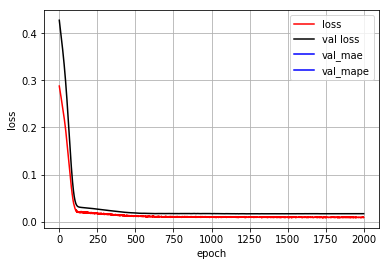

RMSE:76.12830844371024  ,MAE:48.794398432192594  ,MAPE:13.906923809255966 
RMSE:66.59079333544481  ,MAE:44.771533611208895  ,MAPE:12.089713186891409 


/home/wells/Anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


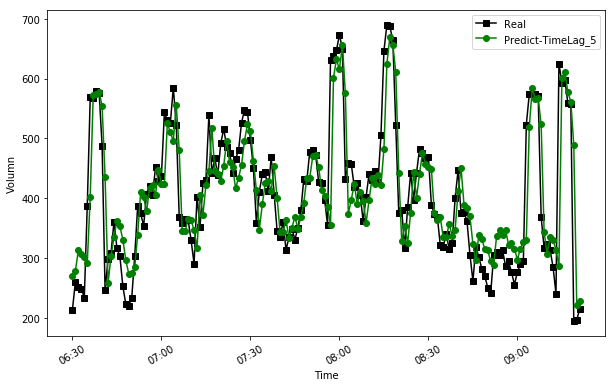

/home/wells/Anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


处理数据: (167, 3)
训练数据: (97, 6)
验证数据: (65, 6)
LSTM预测
Train on 77 samples, validate on 20 samples
Epoch 1/2000
77/77 [==============================] - 4s 53ms/step - loss: 0.4199 - mean_absolute_error: 0.6238 - mean_absolute_percentage_error: 101.4111 - val_loss: 0.8545 - val_mean_absolute_error: 0.9195 - val_mean_absolute_percentage_error: 101.1710
Epoch 2/2000
77/77 [==============================] - 0s 420us/step - loss: 0.4178 - mean_absolute_error: 0.6221 - mean_absolute_percentage_error: 101.1022 - val_loss: 0.8499 - val_mean_absolute_error: 0.9170 - val_mean_absolute_percentage_error: 100.8937
Epoch 3/2000
77/77 [==============================] - 0s 352us/step - loss: 0.4154 - mean_absolute_error: 0.6201 - mean_absolute_percentage_error: 100.7564 - val_loss: 0.8453 - val_mean_absolute_error: 0.9144 - val_mean_absolute_percentage_error: 100.6092
Epoch 4/2000
77/77 [==============================] - 0s 334us/step - loss: 0.4127 - mean_absolute_error: 0.6180 - mean_absolute_percentage

Epoch 33/2000
77/77 [==============================] - 0s 339us/step - loss: 0.3293 - mean_absolute_error: 0.5491 - mean_absolute_percentage_error: 88.4251 - val_loss: 0.6947 - val_mean_absolute_error: 0.8280 - val_mean_absolute_percentage_error: 90.9589
Epoch 34/2000
77/77 [==============================] - 0s 385us/step - loss: 0.3258 - mean_absolute_error: 0.5459 - mean_absolute_percentage_error: 87.8640 - val_loss: 0.6885 - val_mean_absolute_error: 0.8242 - val_mean_absolute_percentage_error: 90.5406
Epoch 35/2000
77/77 [==============================] - 0s 334us/step - loss: 0.3231 - mean_absolute_error: 0.5434 - mean_absolute_percentage_error: 87.3587 - val_loss: 0.6822 - val_mean_absolute_error: 0.8204 - val_mean_absolute_percentage_error: 90.1112
Epoch 36/2000
77/77 [==============================] - 0s 349us/step - loss: 0.3197 - mean_absolute_error: 0.5404 - mean_absolute_percentage_error: 86.8856 - val_loss: 0.6757 - val_mean_absolute_error: 0.8164 - val_mean_absolute_percen

77/77 [==============================] - 0s 344us/step - loss: 0.1932 - mean_absolute_error: 0.4140 - mean_absolute_percentage_error: 65.1514 - val_loss: 0.4341 - val_mean_absolute_error: 0.6514 - val_mean_absolute_percentage_error: 71.2435
Epoch 66/2000
77/77 [==============================] - 0s 334us/step - loss: 0.1888 - mean_absolute_error: 0.4093 - mean_absolute_percentage_error: 64.4571 - val_loss: 0.4242 - val_mean_absolute_error: 0.6437 - val_mean_absolute_percentage_error: 70.3862
Epoch 67/2000
77/77 [==============================] - 0s 367us/step - loss: 0.1834 - mean_absolute_error: 0.4031 - mean_absolute_percentage_error: 63.3886 - val_loss: 0.4143 - val_mean_absolute_error: 0.6358 - val_mean_absolute_percentage_error: 69.5126
Epoch 68/2000
77/77 [==============================] - 0s 365us/step - loss: 0.1787 - mean_absolute_error: 0.3973 - mean_absolute_percentage_error: 62.4648 - val_loss: 0.4042 - val_mean_absolute_error: 0.6279 - val_mean_absolute_percentage_error: 68

77/77 [==============================] - 0s 388us/step - loss: 0.0521 - mean_absolute_error: 0.2027 - mean_absolute_percentage_error: 31.8571 - val_loss: 0.1353 - val_mean_absolute_error: 0.3494 - val_mean_absolute_percentage_error: 37.5195
Epoch 98/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0507 - mean_absolute_error: 0.2002 - mean_absolute_percentage_error: 31.5177 - val_loss: 0.1285 - val_mean_absolute_error: 0.3393 - val_mean_absolute_percentage_error: 36.3854
Epoch 99/2000
77/77 [==============================] - 0s 345us/step - loss: 0.0474 - mean_absolute_error: 0.1941 - mean_absolute_percentage_error: 30.6781 - val_loss: 0.1219 - val_mean_absolute_error: 0.3292 - val_mean_absolute_percentage_error: 35.2577
Epoch 100/2000
77/77 [==============================] - 0s 348us/step - loss: 0.0428 - mean_absolute_error: 0.1823 - mean_absolute_percentage_error: 28.7784 - val_loss: 0.1156 - val_mean_absolute_error: 0.3191 - val_mean_absolute_percentage_error: 3

77/77 [==============================] - 0s 389us/step - loss: 0.0119 - mean_absolute_error: 0.0825 - mean_absolute_percentage_error: 15.5781 - val_loss: 0.0321 - val_mean_absolute_error: 0.1512 - val_mean_absolute_percentage_error: 16.6171
Epoch 130/2000
77/77 [==============================] - 0s 344us/step - loss: 0.0116 - mean_absolute_error: 0.0808 - mean_absolute_percentage_error: 15.3171 - val_loss: 0.0315 - val_mean_absolute_error: 0.1492 - val_mean_absolute_percentage_error: 16.4125
Epoch 131/2000
77/77 [==============================] - 0s 394us/step - loss: 0.0111 - mean_absolute_error: 0.0788 - mean_absolute_percentage_error: 15.2115 - val_loss: 0.0309 - val_mean_absolute_error: 0.1473 - val_mean_absolute_percentage_error: 16.2227
Epoch 132/2000
77/77 [==============================] - 0s 365us/step - loss: 0.0110 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 14.8391 - val_loss: 0.0304 - val_mean_absolute_error: 0.1455 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 353us/step - loss: 0.0102 - mean_absolute_error: 0.0774 - mean_absolute_percentage_error: 15.5318 - val_loss: 0.0259 - val_mean_absolute_error: 0.1277 - val_mean_absolute_percentage_error: 14.2956
Epoch 162/2000
77/77 [==============================] - 0s 359us/step - loss: 0.0105 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 15.3394 - val_loss: 0.0258 - val_mean_absolute_error: 0.1276 - val_mean_absolute_percentage_error: 14.2843
Epoch 163/2000
77/77 [==============================] - 0s 378us/step - loss: 0.0106 - mean_absolute_error: 0.0791 - mean_absolute_percentage_error: 15.6799 - val_loss: 0.0258 - val_mean_absolute_error: 0.1274 - val_mean_absolute_percentage_error: 14.2680
Epoch 164/2000
77/77 [==============================] - 0s 342us/step - loss: 0.0111 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 15.2648 - val_loss: 0.0258 - val_mean_absolute_error: 0.1273 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 329us/step - loss: 0.0103 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 15.3434 - val_loss: 0.0256 - val_mean_absolute_error: 0.1266 - val_mean_absolute_percentage_error: 14.1808
Epoch 194/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0106 - mean_absolute_error: 0.0739 - mean_absolute_percentage_error: 15.2411 - val_loss: 0.0256 - val_mean_absolute_error: 0.1267 - val_mean_absolute_percentage_error: 14.1983
Epoch 195/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0108 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 15.5420 - val_loss: 0.0257 - val_mean_absolute_error: 0.1268 - val_mean_absolute_percentage_error: 14.2071
Epoch 196/2000
77/77 [==============================] - 0s 317us/step - loss: 0.0099 - mean_absolute_error: 0.0741 - mean_absolute_percentage_error: 14.7425 - val_loss: 0.0257 - val_mean_absolute_error: 0.1269 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 469us/step - loss: 0.0104 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 14.9069 - val_loss: 0.0251 - val_mean_absolute_error: 0.1248 - val_mean_absolute_percentage_error: 14.0022
Epoch 226/2000
77/77 [==============================] - 0s 430us/step - loss: 0.0107 - mean_absolute_error: 0.0777 - mean_absolute_percentage_error: 15.5262 - val_loss: 0.0251 - val_mean_absolute_error: 0.1247 - val_mean_absolute_percentage_error: 13.9919
Epoch 227/2000
77/77 [==============================] - 0s 498us/step - loss: 0.0108 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 15.8794 - val_loss: 0.0251 - val_mean_absolute_error: 0.1246 - val_mean_absolute_percentage_error: 13.9911
Epoch 228/2000
77/77 [==============================] - 0s 434us/step - loss: 0.0103 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 15.3034 - val_loss: 0.0251 - val_mean_absolute_error: 0.1246 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 347us/step - loss: 0.0111 - mean_absolute_error: 0.0795 - mean_absolute_percentage_error: 15.4619 - val_loss: 0.0252 - val_mean_absolute_error: 0.1256 - val_mean_absolute_percentage_error: 14.0822
Epoch 258/2000
77/77 [==============================] - 0s 348us/step - loss: 0.0099 - mean_absolute_error: 0.0762 - mean_absolute_percentage_error: 15.0408 - val_loss: 0.0252 - val_mean_absolute_error: 0.1256 - val_mean_absolute_percentage_error: 14.0751
Epoch 259/2000
77/77 [==============================] - 0s 357us/step - loss: 0.0094 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 14.7560 - val_loss: 0.0252 - val_mean_absolute_error: 0.1254 - val_mean_absolute_percentage_error: 14.0616
Epoch 260/2000
77/77 [==============================] - 0s 370us/step - loss: 0.0113 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 15.6056 - val_loss: 0.0251 - val_mean_absolute_error: 0.1252 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 370us/step - loss: 0.0098 - mean_absolute_error: 0.0737 - mean_absolute_percentage_error: 15.0255 - val_loss: 0.0246 - val_mean_absolute_error: 0.1231 - val_mean_absolute_percentage_error: 13.8287
Epoch 290/2000
77/77 [==============================] - 0s 346us/step - loss: 0.0114 - mean_absolute_error: 0.0764 - mean_absolute_percentage_error: 15.2354 - val_loss: 0.0246 - val_mean_absolute_error: 0.1230 - val_mean_absolute_percentage_error: 13.8209
Epoch 291/2000
77/77 [==============================] - 0s 394us/step - loss: 0.0108 - mean_absolute_error: 0.0788 - mean_absolute_percentage_error: 15.7118 - val_loss: 0.0246 - val_mean_absolute_error: 0.1230 - val_mean_absolute_percentage_error: 13.8208
Epoch 292/2000
77/77 [==============================] - 0s 375us/step - loss: 0.0105 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 15.5343 - val_loss: 0.0246 - val_mean_absolute_error: 0.1230 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 369us/step - loss: 0.0093 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 14.5636 - val_loss: 0.0247 - val_mean_absolute_error: 0.1240 - val_mean_absolute_percentage_error: 13.9159
Epoch 322/2000
77/77 [==============================] - 0s 348us/step - loss: 0.0090 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 14.0455 - val_loss: 0.0247 - val_mean_absolute_error: 0.1239 - val_mean_absolute_percentage_error: 13.9115
Epoch 323/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0104 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 15.3489 - val_loss: 0.0247 - val_mean_absolute_error: 0.1238 - val_mean_absolute_percentage_error: 13.9009
Epoch 324/2000
77/77 [==============================] - 0s 347us/step - loss: 0.0107 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 15.4330 - val_loss: 0.0247 - val_mean_absolute_error: 0.1238 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 369us/step - loss: 0.0101 - mean_absolute_error: 0.0732 - mean_absolute_percentage_error: 14.9896 - val_loss: 0.0244 - val_mean_absolute_error: 0.1231 - val_mean_absolute_percentage_error: 13.8327
Epoch 354/2000
77/77 [==============================] - 0s 335us/step - loss: 0.0100 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 14.8978 - val_loss: 0.0245 - val_mean_absolute_error: 0.1236 - val_mean_absolute_percentage_error: 13.8786
Epoch 355/2000
77/77 [==============================] - 0s 361us/step - loss: 0.0103 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 15.0739 - val_loss: 0.0246 - val_mean_absolute_error: 0.1241 - val_mean_absolute_percentage_error: 13.9291
Epoch 356/2000
77/77 [==============================] - 0s 365us/step - loss: 0.0099 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 15.0228 - val_loss: 0.0247 - val_mean_absolute_error: 0.1246 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 338us/step - loss: 0.0096 - mean_absolute_error: 0.0743 - mean_absolute_percentage_error: 14.9256 - val_loss: 0.0241 - val_mean_absolute_error: 0.1222 - val_mean_absolute_percentage_error: 13.7423
Epoch 386/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0105 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 15.3278 - val_loss: 0.0241 - val_mean_absolute_error: 0.1222 - val_mean_absolute_percentage_error: 13.7354
Epoch 387/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0097 - mean_absolute_error: 0.0749 - mean_absolute_percentage_error: 14.9257 - val_loss: 0.0241 - val_mean_absolute_error: 0.1222 - val_mean_absolute_percentage_error: 13.7387
Epoch 388/2000
77/77 [==============================] - 0s 321us/step - loss: 0.0089 - mean_absolute_error: 0.0704 - mean_absolute_percentage_error: 14.3724 - val_loss: 0.0241 - val_mean_absolute_error: 0.1223 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 343us/step - loss: 0.0099 - mean_absolute_error: 0.0732 - mean_absolute_percentage_error: 14.4689 - val_loss: 0.0238 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error: 13.6523
Epoch 418/2000
77/77 [==============================] - 0s 411us/step - loss: 0.0100 - mean_absolute_error: 0.0731 - mean_absolute_percentage_error: 14.9198 - val_loss: 0.0238 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error: 13.6530
Epoch 419/2000
77/77 [==============================] - 0s 373us/step - loss: 0.0096 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 13.8550 - val_loss: 0.0238 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error: 13.6499
Epoch 420/2000
77/77 [==============================] - 0s 349us/step - loss: 0.0095 - mean_absolute_error: 0.0727 - mean_absolute_percentage_error: 14.6317 - val_loss: 0.0238 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 459us/step - loss: 0.0097 - mean_absolute_error: 0.0725 - mean_absolute_percentage_error: 14.3857 - val_loss: 0.0238 - val_mean_absolute_error: 0.1216 - val_mean_absolute_percentage_error: 13.6825
Epoch 450/2000
77/77 [==============================] - 0s 326us/step - loss: 0.0090 - mean_absolute_error: 0.0684 - mean_absolute_percentage_error: 13.8759 - val_loss: 0.0238 - val_mean_absolute_error: 0.1216 - val_mean_absolute_percentage_error: 13.6781
Epoch 451/2000
77/77 [==============================] - 0s 332us/step - loss: 0.0099 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 15.1514 - val_loss: 0.0237 - val_mean_absolute_error: 0.1215 - val_mean_absolute_percentage_error: 13.6672
Epoch 452/2000
77/77 [==============================] - 0s 320us/step - loss: 0.0094 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 14.5024 - val_loss: 0.0237 - val_mean_absolute_error: 0.1213 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 405us/step - loss: 0.0093 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 14.6013 - val_loss: 0.0231 - val_mean_absolute_error: 0.1188 - val_mean_absolute_percentage_error: 13.3975
Epoch 482/2000
77/77 [==============================] - 0s 346us/step - loss: 0.0095 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 14.5675 - val_loss: 0.0231 - val_mean_absolute_error: 0.1187 - val_mean_absolute_percentage_error: 13.3888
Epoch 483/2000
77/77 [==============================] - 0s 353us/step - loss: 0.0096 - mean_absolute_error: 0.0717 - mean_absolute_percentage_error: 14.4566 - val_loss: 0.0230 - val_mean_absolute_error: 0.1186 - val_mean_absolute_percentage_error: 13.3790
Epoch 484/2000
77/77 [==============================] - 0s 365us/step - loss: 0.0102 - mean_absolute_error: 0.0754 - mean_absolute_percentage_error: 15.2699 - val_loss: 0.0230 - val_mean_absolute_error: 0.1185 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 375us/step - loss: 0.0096 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 14.6095 - val_loss: 0.0230 - val_mean_absolute_error: 0.1188 - val_mean_absolute_percentage_error: 13.3993
Epoch 514/2000
77/77 [==============================] - 0s 329us/step - loss: 0.0087 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 14.1603 - val_loss: 0.0230 - val_mean_absolute_error: 0.1189 - val_mean_absolute_percentage_error: 13.4094
Epoch 515/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0083 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 13.5096 - val_loss: 0.0230 - val_mean_absolute_error: 0.1192 - val_mean_absolute_percentage_error: 13.4392
Epoch 516/2000
77/77 [==============================] - 0s 351us/step - loss: 0.0104 - mean_absolute_error: 0.0758 - mean_absolute_percentage_error: 15.0004 - val_loss: 0.0231 - val_mean_absolute_error: 0.1193 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 314us/step - loss: 0.0094 - mean_absolute_error: 0.0709 - mean_absolute_percentage_error: 14.1370 - val_loss: 0.0226 - val_mean_absolute_error: 0.1176 - val_mean_absolute_percentage_error: 13.2794
Epoch 546/2000
77/77 [==============================] - 0s 325us/step - loss: 0.0096 - mean_absolute_error: 0.0716 - mean_absolute_percentage_error: 14.4529 - val_loss: 0.0226 - val_mean_absolute_error: 0.1176 - val_mean_absolute_percentage_error: 13.2841
Epoch 547/2000
77/77 [==============================] - 0s 317us/step - loss: 0.0090 - mean_absolute_error: 0.0702 - mean_absolute_percentage_error: 14.3039 - val_loss: 0.0226 - val_mean_absolute_error: 0.1179 - val_mean_absolute_percentage_error: 13.3101
Epoch 548/2000
77/77 [==============================] - 0s 308us/step - loss: 0.0098 - mean_absolute_error: 0.0751 - mean_absolute_percentage_error: 14.8550 - val_loss: 0.0227 - val_mean_absolute_error: 0.1181 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 362us/step - loss: 0.0087 - mean_absolute_error: 0.0687 - mean_absolute_percentage_error: 14.0580 - val_loss: 0.0223 - val_mean_absolute_error: 0.1171 - val_mean_absolute_percentage_error: 13.2250
Epoch 578/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0097 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 14.6332 - val_loss: 0.0223 - val_mean_absolute_error: 0.1168 - val_mean_absolute_percentage_error: 13.2028
Epoch 579/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0093 - mean_absolute_error: 0.0715 - mean_absolute_percentage_error: 14.4352 - val_loss: 0.0223 - val_mean_absolute_error: 0.1167 - val_mean_absolute_percentage_error: 13.1889
Epoch 580/2000
77/77 [==============================] - 0s 341us/step - loss: 0.0094 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 14.2432 - val_loss: 0.0222 - val_mean_absolute_error: 0.1167 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 372us/step - loss: 0.0088 - mean_absolute_error: 0.0668 - mean_absolute_percentage_error: 13.6021 - val_loss: 0.0222 - val_mean_absolute_error: 0.1172 - val_mean_absolute_percentage_error: 13.2343
Epoch 610/2000
77/77 [==============================] - 0s 367us/step - loss: 0.0088 - mean_absolute_error: 0.0699 - mean_absolute_percentage_error: 14.0257 - val_loss: 0.0222 - val_mean_absolute_error: 0.1171 - val_mean_absolute_percentage_error: 13.2220
Epoch 611/2000
77/77 [==============================] - 0s 365us/step - loss: 0.0088 - mean_absolute_error: 0.0679 - mean_absolute_percentage_error: 13.6009 - val_loss: 0.0221 - val_mean_absolute_error: 0.1167 - val_mean_absolute_percentage_error: 13.1886
Epoch 612/2000
77/77 [==============================] - 0s 346us/step - loss: 0.0090 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 13.9149 - val_loss: 0.0220 - val_mean_absolute_error: 0.1163 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 332us/step - loss: 0.0087 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 13.3816 - val_loss: 0.0217 - val_mean_absolute_error: 0.1152 - val_mean_absolute_percentage_error: 13.0353
Epoch 642/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0085 - mean_absolute_error: 0.0680 - mean_absolute_percentage_error: 13.7848 - val_loss: 0.0217 - val_mean_absolute_error: 0.1151 - val_mean_absolute_percentage_error: 13.0281
Epoch 643/2000
77/77 [==============================] - 0s 370us/step - loss: 0.0084 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 13.6337 - val_loss: 0.0217 - val_mean_absolute_error: 0.1151 - val_mean_absolute_percentage_error: 13.0269
Epoch 644/2000
77/77 [==============================] - 0s 378us/step - loss: 0.0087 - mean_absolute_error: 0.0695 - mean_absolute_percentage_error: 13.9290 - val_loss: 0.0217 - val_mean_absolute_error: 0.1152 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 344us/step - loss: 0.0095 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 14.6231 - val_loss: 0.0216 - val_mean_absolute_error: 0.1153 - val_mean_absolute_percentage_error: 13.0416
Epoch 674/2000
77/77 [==============================] - 0s 350us/step - loss: 0.0082 - mean_absolute_error: 0.0705 - mean_absolute_percentage_error: 13.7435 - val_loss: 0.0216 - val_mean_absolute_error: 0.1152 - val_mean_absolute_percentage_error: 13.0347
Epoch 675/2000
77/77 [==============================] - 0s 329us/step - loss: 0.0082 - mean_absolute_error: 0.0672 - mean_absolute_percentage_error: 13.4759 - val_loss: 0.0215 - val_mean_absolute_error: 0.1150 - val_mean_absolute_percentage_error: 13.0145
Epoch 676/2000
77/77 [==============================] - 0s 326us/step - loss: 0.0082 - mean_absolute_error: 0.0678 - mean_absolute_percentage_error: 13.5280 - val_loss: 0.0215 - val_mean_absolute_error: 0.1147 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 340us/step - loss: 0.0084 - mean_absolute_error: 0.0664 - mean_absolute_percentage_error: 13.2339 - val_loss: 0.0212 - val_mean_absolute_error: 0.1137 - val_mean_absolute_percentage_error: 12.8887
Epoch 706/2000
77/77 [==============================] - 0s 327us/step - loss: 0.0086 - mean_absolute_error: 0.0676 - mean_absolute_percentage_error: 13.5351 - val_loss: 0.0211 - val_mean_absolute_error: 0.1134 - val_mean_absolute_percentage_error: 12.8603
Epoch 707/2000
77/77 [==============================] - 0s 339us/step - loss: 0.0090 - mean_absolute_error: 0.0698 - mean_absolute_percentage_error: 14.0205 - val_loss: 0.0210 - val_mean_absolute_error: 0.1131 - val_mean_absolute_percentage_error: 12.8280
Epoch 708/2000
77/77 [==============================] - 0s 347us/step - loss: 0.0087 - mean_absolute_error: 0.0710 - mean_absolute_percentage_error: 14.0746 - val_loss: 0.0210 - val_mean_absolute_error: 0.1129 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 319us/step - loss: 0.0079 - mean_absolute_error: 0.0664 - mean_absolute_percentage_error: 13.3821 - val_loss: 0.0208 - val_mean_absolute_error: 0.1123 - val_mean_absolute_percentage_error: 12.7459
Epoch 738/2000
77/77 [==============================] - 0s 320us/step - loss: 0.0083 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 13.2937 - val_loss: 0.0207 - val_mean_absolute_error: 0.1121 - val_mean_absolute_percentage_error: 12.7256
Epoch 739/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0086 - mean_absolute_error: 0.0681 - mean_absolute_percentage_error: 13.5985 - val_loss: 0.0206 - val_mean_absolute_error: 0.1116 - val_mean_absolute_percentage_error: 12.6810
Epoch 740/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0086 - mean_absolute_error: 0.0697 - mean_absolute_percentage_error: 14.0651 - val_loss: 0.0206 - val_mean_absolute_error: 0.1114 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 362us/step - loss: 0.0073 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 13.1459 - val_loss: 0.0208 - val_mean_absolute_error: 0.1130 - val_mean_absolute_percentage_error: 12.8152
Epoch 770/2000
77/77 [==============================] - 0s 334us/step - loss: 0.0086 - mean_absolute_error: 0.0698 - mean_absolute_percentage_error: 13.9165 - val_loss: 0.0208 - val_mean_absolute_error: 0.1132 - val_mean_absolute_percentage_error: 12.8279
Epoch 771/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0082 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 13.3892 - val_loss: 0.0208 - val_mean_absolute_error: 0.1131 - val_mean_absolute_percentage_error: 12.8165
Epoch 772/2000
77/77 [==============================] - 0s 345us/step - loss: 0.0080 - mean_absolute_error: 0.0671 - mean_absolute_percentage_error: 13.2276 - val_loss: 0.0207 - val_mean_absolute_error: 0.1126 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 337us/step - loss: 0.0078 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 13.0952 - val_loss: 0.0201 - val_mean_absolute_error: 0.1099 - val_mean_absolute_percentage_error: 12.5017
Epoch 802/2000
77/77 [==============================] - 0s 319us/step - loss: 0.0080 - mean_absolute_error: 0.0643 - mean_absolute_percentage_error: 12.8816 - val_loss: 0.0201 - val_mean_absolute_error: 0.1099 - val_mean_absolute_percentage_error: 12.5074
Epoch 803/2000
77/77 [==============================] - 0s 310us/step - loss: 0.0078 - mean_absolute_error: 0.0637 - mean_absolute_percentage_error: 13.0362 - val_loss: 0.0201 - val_mean_absolute_error: 0.1098 - val_mean_absolute_percentage_error: 12.4996
Epoch 804/2000
77/77 [==============================] - 0s 311us/step - loss: 0.0077 - mean_absolute_error: 0.0631 - mean_absolute_percentage_error: 12.5967 - val_loss: 0.0201 - val_mean_absolute_error: 0.1098 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 327us/step - loss: 0.0076 - mean_absolute_error: 0.0655 - mean_absolute_percentage_error: 13.1541 - val_loss: 0.0197 - val_mean_absolute_error: 0.1080 - val_mean_absolute_percentage_error: 12.3172
Epoch 834/2000
77/77 [==============================] - 0s 370us/step - loss: 0.0079 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 13.2133 - val_loss: 0.0196 - val_mean_absolute_error: 0.1076 - val_mean_absolute_percentage_error: 12.2756
Epoch 835/2000
77/77 [==============================] - 0s 426us/step - loss: 0.0075 - mean_absolute_error: 0.0622 - mean_absolute_percentage_error: 12.7350 - val_loss: 0.0196 - val_mean_absolute_error: 0.1075 - val_mean_absolute_percentage_error: 12.2724
Epoch 836/2000
77/77 [==============================] - 0s 353us/step - loss: 0.0080 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 13.1464 - val_loss: 0.0196 - val_mean_absolute_error: 0.1077 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 322us/step - loss: 0.0075 - mean_absolute_error: 0.0633 - mean_absolute_percentage_error: 12.8277 - val_loss: 0.0198 - val_mean_absolute_error: 0.1091 - val_mean_absolute_percentage_error: 12.4217
Epoch 866/2000
77/77 [==============================] - 0s 307us/step - loss: 0.0080 - mean_absolute_error: 0.0645 - mean_absolute_percentage_error: 13.1021 - val_loss: 0.0197 - val_mean_absolute_error: 0.1085 - val_mean_absolute_percentage_error: 12.3647
Epoch 867/2000
77/77 [==============================] - 0s 309us/step - loss: 0.0078 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 13.3729 - val_loss: 0.0197 - val_mean_absolute_error: 0.1083 - val_mean_absolute_percentage_error: 12.3418
Epoch 868/2000
77/77 [==============================] - 0s 301us/step - loss: 0.0076 - mean_absolute_error: 0.0654 - mean_absolute_percentage_error: 13.0460 - val_loss: 0.0197 - val_mean_absolute_error: 0.1084 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 306us/step - loss: 0.0081 - mean_absolute_error: 0.0666 - mean_absolute_percentage_error: 13.2358 - val_loss: 0.0195 - val_mean_absolute_error: 0.1080 - val_mean_absolute_percentage_error: 12.3095
Epoch 898/2000
77/77 [==============================] - 0s 329us/step - loss: 0.0081 - mean_absolute_error: 0.0696 - mean_absolute_percentage_error: 13.8902 - val_loss: 0.0196 - val_mean_absolute_error: 0.1081 - val_mean_absolute_percentage_error: 12.3213
Epoch 899/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0073 - mean_absolute_error: 0.0629 - mean_absolute_percentage_error: 12.6900 - val_loss: 0.0196 - val_mean_absolute_error: 0.1082 - val_mean_absolute_percentage_error: 12.3319
Epoch 900/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0078 - mean_absolute_error: 0.0667 - mean_absolute_percentage_error: 13.3416 - val_loss: 0.0196 - val_mean_absolute_error: 0.1084 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 312us/step - loss: 0.0068 - mean_absolute_error: 0.0594 - mean_absolute_percentage_error: 11.8870 - val_loss: 0.0191 - val_mean_absolute_error: 0.1057 - val_mean_absolute_percentage_error: 12.0837
Epoch 930/2000
77/77 [==============================] - 0s 377us/step - loss: 0.0065 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 12.2400 - val_loss: 0.0191 - val_mean_absolute_error: 0.1060 - val_mean_absolute_percentage_error: 12.1052
Epoch 931/2000
77/77 [==============================] - 0s 358us/step - loss: 0.0071 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 12.5709 - val_loss: 0.0192 - val_mean_absolute_error: 0.1062 - val_mean_absolute_percentage_error: 12.1271
Epoch 932/2000
77/77 [==============================] - 0s 388us/step - loss: 0.0072 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 12.0804 - val_loss: 0.0192 - val_mean_absolute_error: 0.1064 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 365us/step - loss: 0.0075 - mean_absolute_error: 0.0629 - mean_absolute_percentage_error: 12.6280 - val_loss: 0.0190 - val_mean_absolute_error: 0.1053 - val_mean_absolute_percentage_error: 12.0355
Epoch 962/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0075 - mean_absolute_error: 0.0673 - mean_absolute_percentage_error: 13.1359 - val_loss: 0.0190 - val_mean_absolute_error: 0.1054 - val_mean_absolute_percentage_error: 12.0508
Epoch 963/2000
77/77 [==============================] - 0s 335us/step - loss: 0.0080 - mean_absolute_error: 0.0641 - mean_absolute_percentage_error: 12.5543 - val_loss: 0.0189 - val_mean_absolute_error: 0.1050 - val_mean_absolute_percentage_error: 12.0047
Epoch 964/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0081 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 12.7058 - val_loss: 0.0188 - val_mean_absolute_error: 0.1042 - val_mean_absolute_percentage_error:

77/77 [==============================] - 0s 327us/step - loss: 0.0076 - mean_absolute_error: 0.0648 - mean_absolute_percentage_error: 12.8720 - val_loss: 0.0188 - val_mean_absolute_error: 0.1047 - val_mean_absolute_percentage_error: 11.9699
Epoch 994/2000
77/77 [==============================] - 0s 320us/step - loss: 0.0074 - mean_absolute_error: 0.0652 - mean_absolute_percentage_error: 12.9860 - val_loss: 0.0188 - val_mean_absolute_error: 0.1047 - val_mean_absolute_percentage_error: 11.9712
Epoch 995/2000
77/77 [==============================] - 0s 325us/step - loss: 0.0072 - mean_absolute_error: 0.0636 - mean_absolute_percentage_error: 12.9313 - val_loss: 0.0188 - val_mean_absolute_error: 0.1045 - val_mean_absolute_percentage_error: 11.9496
Epoch 996/2000
77/77 [==============================] - 0s 313us/step - loss: 0.0072 - mean_absolute_error: 0.0634 - mean_absolute_percentage_error: 12.5342 - val_loss: 0.0188 - val_mean_absolute_error: 0.1044 - val_mean_absolute_percentage_error:

Epoch 1025/2000
77/77 [==============================] - 0s 323us/step - loss: 0.0073 - mean_absolute_error: 0.0647 - mean_absolute_percentage_error: 12.8523 - val_loss: 0.0186 - val_mean_absolute_error: 0.1035 - val_mean_absolute_percentage_error: 11.8549
Epoch 1026/2000
77/77 [==============================] - 0s 316us/step - loss: 0.0077 - mean_absolute_error: 0.0644 - mean_absolute_percentage_error: 12.6943 - val_loss: 0.0186 - val_mean_absolute_error: 0.1036 - val_mean_absolute_percentage_error: 11.8614
Epoch 1027/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0070 - mean_absolute_error: 0.0651 - mean_absolute_percentage_error: 12.7028 - val_loss: 0.0186 - val_mean_absolute_error: 0.1034 - val_mean_absolute_percentage_error: 11.8380
Epoch 1028/2000
77/77 [==============================] - 0s 320us/step - loss: 0.0074 - mean_absolute_error: 0.0635 - mean_absolute_percentage_error: 12.9588 - val_loss: 0.0186 - val_mean_absolute_error: 0.1035 - val_mean_absolut

Epoch 1057/2000
77/77 [==============================] - 0s 347us/step - loss: 0.0064 - mean_absolute_error: 0.0604 - mean_absolute_percentage_error: 11.9683 - val_loss: 0.0185 - val_mean_absolute_error: 0.1034 - val_mean_absolute_percentage_error: 11.8427
Epoch 1058/2000
77/77 [==============================] - 0s 327us/step - loss: 0.0066 - mean_absolute_error: 0.0570 - mean_absolute_percentage_error: 11.5808 - val_loss: 0.0185 - val_mean_absolute_error: 0.1035 - val_mean_absolute_percentage_error: 11.8456
Epoch 1059/2000
77/77 [==============================] - 0s 331us/step - loss: 0.0078 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 12.8095 - val_loss: 0.0185 - val_mean_absolute_error: 0.1033 - val_mean_absolute_percentage_error: 11.8318
Epoch 1060/2000
77/77 [==============================] - 0s 380us/step - loss: 0.0067 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 11.7965 - val_loss: 0.0184 - val_mean_absolute_error: 0.1030 - val_mean_absolut

Epoch 1089/2000
77/77 [==============================] - 0s 352us/step - loss: 0.0071 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 11.9354 - val_loss: 0.0180 - val_mean_absolute_error: 0.1013 - val_mean_absolute_percentage_error: 11.6370
Epoch 1090/2000
77/77 [==============================] - 0s 333us/step - loss: 0.0065 - mean_absolute_error: 0.0583 - mean_absolute_percentage_error: 11.5315 - val_loss: 0.0180 - val_mean_absolute_error: 0.1012 - val_mean_absolute_percentage_error: 11.6299
Epoch 1091/2000
77/77 [==============================] - 0s 406us/step - loss: 0.0061 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 11.4295 - val_loss: 0.0181 - val_mean_absolute_error: 0.1014 - val_mean_absolute_percentage_error: 11.6495
Epoch 1092/2000
77/77 [==============================] - 0s 390us/step - loss: 0.0061 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 12.2033 - val_loss: 0.0182 - val_mean_absolute_error: 0.1020 - val_mean_absolut

Epoch 1121/2000
77/77 [==============================] - 0s 371us/step - loss: 0.0069 - mean_absolute_error: 0.0609 - mean_absolute_percentage_error: 12.3881 - val_loss: 0.0179 - val_mean_absolute_error: 0.1009 - val_mean_absolute_percentage_error: 11.5973
Epoch 1122/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0063 - mean_absolute_error: 0.0601 - mean_absolute_percentage_error: 11.5811 - val_loss: 0.0178 - val_mean_absolute_error: 0.1004 - val_mean_absolute_percentage_error: 11.5480
Epoch 1123/2000
77/77 [==============================] - 0s 329us/step - loss: 0.0072 - mean_absolute_error: 0.0616 - mean_absolute_percentage_error: 12.3033 - val_loss: 0.0177 - val_mean_absolute_error: 0.0998 - val_mean_absolute_percentage_error: 11.4905
Epoch 1124/2000
77/77 [==============================] - 0s 340us/step - loss: 0.0075 - mean_absolute_error: 0.0640 - mean_absolute_percentage_error: 12.6422 - val_loss: 0.0176 - val_mean_absolute_error: 0.0990 - val_mean_absolut

Epoch 1153/2000
77/77 [==============================] - 0s 343us/step - loss: 0.0070 - mean_absolute_error: 0.0612 - mean_absolute_percentage_error: 12.0279 - val_loss: 0.0181 - val_mean_absolute_error: 0.1023 - val_mean_absolute_percentage_error: 11.7228
Epoch 1154/2000
77/77 [==============================] - 0s 345us/step - loss: 0.0064 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 11.7742 - val_loss: 0.0181 - val_mean_absolute_error: 0.1024 - val_mean_absolute_percentage_error: 11.7328
Epoch 1155/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0071 - mean_absolute_error: 0.0626 - mean_absolute_percentage_error: 12.3459 - val_loss: 0.0182 - val_mean_absolute_error: 0.1027 - val_mean_absolute_percentage_error: 11.7628
Epoch 1156/2000
77/77 [==============================] - 0s 313us/step - loss: 0.0071 - mean_absolute_error: 0.0616 - mean_absolute_percentage_error: 12.1925 - val_loss: 0.0182 - val_mean_absolute_error: 0.1028 - val_mean_absolut

Epoch 1185/2000
77/77 [==============================] - 0s 311us/step - loss: 0.0069 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 12.1276 - val_loss: 0.0176 - val_mean_absolute_error: 0.0995 - val_mean_absolute_percentage_error: 11.4553
Epoch 1186/2000
77/77 [==============================] - 0s 344us/step - loss: 0.0063 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 11.8671 - val_loss: 0.0176 - val_mean_absolute_error: 0.0998 - val_mean_absolute_percentage_error: 11.4867
Epoch 1187/2000
77/77 [==============================] - 0s 390us/step - loss: 0.0076 - mean_absolute_error: 0.0646 - mean_absolute_percentage_error: 12.9098 - val_loss: 0.0177 - val_mean_absolute_error: 0.1004 - val_mean_absolute_percentage_error: 11.5454
Epoch 1188/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0061 - mean_absolute_error: 0.0561 - mean_absolute_percentage_error: 10.9638 - val_loss: 0.0178 - val_mean_absolute_error: 0.1007 - val_mean_absolut

Epoch 1217/2000
77/77 [==============================] - 0s 352us/step - loss: 0.0061 - mean_absolute_error: 0.0546 - mean_absolute_percentage_error: 10.7968 - val_loss: 0.0178 - val_mean_absolute_error: 0.1006 - val_mean_absolute_percentage_error: 11.5560
Epoch 1218/2000
77/77 [==============================] - 0s 368us/step - loss: 0.0062 - mean_absolute_error: 0.0579 - mean_absolute_percentage_error: 11.5385 - val_loss: 0.0177 - val_mean_absolute_error: 0.1005 - val_mean_absolute_percentage_error: 11.5439
Epoch 1219/2000
77/77 [==============================] - 0s 339us/step - loss: 0.0068 - mean_absolute_error: 0.0602 - mean_absolute_percentage_error: 11.7415 - val_loss: 0.0177 - val_mean_absolute_error: 0.1003 - val_mean_absolute_percentage_error: 11.5261
Epoch 1220/2000
77/77 [==============================] - 0s 312us/step - loss: 0.0067 - mean_absolute_error: 0.0601 - mean_absolute_percentage_error: 11.6775 - val_loss: 0.0176 - val_mean_absolute_error: 0.0997 - val_mean_absolut

Epoch 1249/2000
77/77 [==============================] - 0s 321us/step - loss: 0.0072 - mean_absolute_error: 0.0642 - mean_absolute_percentage_error: 12.3593 - val_loss: 0.0174 - val_mean_absolute_error: 0.0983 - val_mean_absolute_percentage_error: 11.3339
Epoch 1250/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0064 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 11.5397 - val_loss: 0.0173 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 11.3116
Epoch 1251/2000
77/77 [==============================] - 0s 352us/step - loss: 0.0064 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 11.4523 - val_loss: 0.0173 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 11.3040
Epoch 1252/2000
77/77 [==============================] - 0s 343us/step - loss: 0.0068 - mean_absolute_error: 0.0617 - mean_absolute_percentage_error: 12.0849 - val_loss: 0.0174 - val_mean_absolute_error: 0.0984 - val_mean_absolut

Epoch 1281/2000
77/77 [==============================] - 0s 335us/step - loss: 0.0064 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 11.4316 - val_loss: 0.0174 - val_mean_absolute_error: 0.0985 - val_mean_absolute_percentage_error: 11.3466
Epoch 1282/2000
77/77 [==============================] - 0s 389us/step - loss: 0.0060 - mean_absolute_error: 0.0565 - mean_absolute_percentage_error: 11.1237 - val_loss: 0.0175 - val_mean_absolute_error: 0.0989 - val_mean_absolute_percentage_error: 11.3895
Epoch 1283/2000
77/77 [==============================] - 0s 345us/step - loss: 0.0066 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 11.6128 - val_loss: 0.0175 - val_mean_absolute_error: 0.0992 - val_mean_absolute_percentage_error: 11.4187
Epoch 1284/2000
77/77 [==============================] - 0s 330us/step - loss: 0.0067 - mean_absolute_error: 0.0605 - mean_absolute_percentage_error: 11.7631 - val_loss: 0.0176 - val_mean_absolute_error: 0.0997 - val_mean_absolut

Epoch 1313/2000
77/77 [==============================] - 0s 340us/step - loss: 0.0064 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 11.0909 - val_loss: 0.0173 - val_mean_absolute_error: 0.0978 - val_mean_absolute_percentage_error: 11.2859
Epoch 1314/2000
77/77 [==============================] - 0s 333us/step - loss: 0.0064 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 11.4603 - val_loss: 0.0173 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 11.2995
Epoch 1315/2000
77/77 [==============================] - 0s 326us/step - loss: 0.0064 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 11.6177 - val_loss: 0.0174 - val_mean_absolute_error: 0.0985 - val_mean_absolute_percentage_error: 11.3442
Epoch 1316/2000
77/77 [==============================] - 0s 342us/step - loss: 0.0063 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 11.1413 - val_loss: 0.0175 - val_mean_absolute_error: 0.0987 - val_mean_absolut

Epoch 1345/2000
77/77 [==============================] - 0s 330us/step - loss: 0.0066 - mean_absolute_error: 0.0600 - mean_absolute_percentage_error: 11.3915 - val_loss: 0.0173 - val_mean_absolute_error: 0.0975 - val_mean_absolute_percentage_error: 11.2487
Epoch 1346/2000
77/77 [==============================] - 0s 345us/step - loss: 0.0057 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 11.1925 - val_loss: 0.0172 - val_mean_absolute_error: 0.0971 - val_mean_absolute_percentage_error: 11.2177
Epoch 1347/2000
77/77 [==============================] - 0s 373us/step - loss: 0.0067 - mean_absolute_error: 0.0589 - mean_absolute_percentage_error: 11.6848 - val_loss: 0.0171 - val_mean_absolute_error: 0.0969 - val_mean_absolute_percentage_error: 11.1963
Epoch 1348/2000
77/77 [==============================] - 0s 505us/step - loss: 0.0067 - mean_absolute_error: 0.0584 - mean_absolute_percentage_error: 11.6407 - val_loss: 0.0171 - val_mean_absolute_error: 0.0968 - val_mean_absolut

Epoch 1377/2000
77/77 [==============================] - 0s 356us/step - loss: 0.0061 - mean_absolute_error: 0.0590 - mean_absolute_percentage_error: 11.6540 - val_loss: 0.0171 - val_mean_absolute_error: 0.0963 - val_mean_absolute_percentage_error: 11.1345
Epoch 1378/2000
77/77 [==============================] - 0s 402us/step - loss: 0.0061 - mean_absolute_error: 0.0557 - mean_absolute_percentage_error: 11.0635 - val_loss: 0.0170 - val_mean_absolute_error: 0.0961 - val_mean_absolute_percentage_error: 11.1228
Epoch 1379/2000
77/77 [==============================] - 0s 377us/step - loss: 0.0060 - mean_absolute_error: 0.0587 - mean_absolute_percentage_error: 11.5752 - val_loss: 0.0170 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_error: 11.1301
Epoch 1380/2000
77/77 [==============================] - 0s 397us/step - loss: 0.0061 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 10.4106 - val_loss: 0.0171 - val_mean_absolute_error: 0.0967 - val_mean_absolut

Epoch 1409/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0065 - mean_absolute_error: 0.0615 - mean_absolute_percentage_error: 11.6142 - val_loss: 0.0170 - val_mean_absolute_error: 0.0959 - val_mean_absolute_percentage_error: 11.0981
Epoch 1410/2000
77/77 [==============================] - 0s 350us/step - loss: 0.0063 - mean_absolute_error: 0.0585 - mean_absolute_percentage_error: 11.3630 - val_loss: 0.0169 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 11.0445
Epoch 1411/2000
77/77 [==============================] - 0s 473us/step - loss: 0.0065 - mean_absolute_error: 0.0584 - mean_absolute_percentage_error: 11.5312 - val_loss: 0.0169 - val_mean_absolute_error: 0.0952 - val_mean_absolute_percentage_error: 11.0314
Epoch 1412/2000
77/77 [==============================] - 0s 370us/step - loss: 0.0066 - mean_absolute_error: 0.0595 - mean_absolute_percentage_error: 11.5593 - val_loss: 0.0169 - val_mean_absolute_error: 0.0953 - val_mean_absolut

Epoch 1441/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0062 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 11.3051 - val_loss: 0.0171 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_error: 11.1237
Epoch 1442/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0067 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 11.6668 - val_loss: 0.0171 - val_mean_absolute_error: 0.0964 - val_mean_absolute_percentage_error: 11.1358
Epoch 1443/2000
77/77 [==============================] - 0s 297us/step - loss: 0.0063 - mean_absolute_error: 0.0560 - mean_absolute_percentage_error: 10.7401 - val_loss: 0.0172 - val_mean_absolute_error: 0.0966 - val_mean_absolute_percentage_error: 11.1568
Epoch 1444/2000
77/77 [==============================] - 0s 301us/step - loss: 0.0063 - mean_absolute_error: 0.0588 - mean_absolute_percentage_error: 11.2367 - val_loss: 0.0173 - val_mean_absolute_error: 0.0971 - val_mean_absolut

Epoch 1473/2000
77/77 [==============================] - 0s 392us/step - loss: 0.0069 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 11.3749 - val_loss: 0.0173 - val_mean_absolute_error: 0.0972 - val_mean_absolute_percentage_error: 11.2087
Epoch 1474/2000
77/77 [==============================] - 0s 363us/step - loss: 0.0066 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 11.5527 - val_loss: 0.0172 - val_mean_absolute_error: 0.0964 - val_mean_absolute_percentage_error: 11.1379
Epoch 1475/2000
77/77 [==============================] - 0s 340us/step - loss: 0.0060 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 11.0069 - val_loss: 0.0171 - val_mean_absolute_error: 0.0957 - val_mean_absolute_percentage_error: 11.0725
Epoch 1476/2000
77/77 [==============================] - 0s 335us/step - loss: 0.0055 - mean_absolute_error: 0.0541 - mean_absolute_percentage_error: 10.8585 - val_loss: 0.0170 - val_mean_absolute_error: 0.0953 - val_mean_absolut

Epoch 1505/2000
77/77 [==============================] - 0s 336us/step - loss: 0.0062 - mean_absolute_error: 0.0562 - mean_absolute_percentage_error: 10.7776 - val_loss: 0.0170 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 11.0315
Epoch 1506/2000
77/77 [==============================] - 0s 332us/step - loss: 0.0055 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 10.0379 - val_loss: 0.0170 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 11.0144
Epoch 1507/2000
77/77 [==============================] - 0s 410us/step - loss: 0.0067 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 11.6329 - val_loss: 0.0170 - val_mean_absolute_error: 0.0952 - val_mean_absolute_percentage_error: 11.0167
Epoch 1508/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0056 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 10.8778 - val_loss: 0.0170 - val_mean_absolute_error: 0.0952 - val_mean_absolut

Epoch 1537/2000
77/77 [==============================] - 0s 322us/step - loss: 0.0063 - mean_absolute_error: 0.0573 - mean_absolute_percentage_error: 11.4352 - val_loss: 0.0172 - val_mean_absolute_error: 0.0962 - val_mean_absolute_percentage_error: 11.1020
Epoch 1538/2000
77/77 [==============================] - 0s 319us/step - loss: 0.0062 - mean_absolute_error: 0.0555 - mean_absolute_percentage_error: 10.9876 - val_loss: 0.0171 - val_mean_absolute_error: 0.0958 - val_mean_absolute_percentage_error: 11.0740
Epoch 1539/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0063 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 11.1193 - val_loss: 0.0170 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 11.0211
Epoch 1540/2000
77/77 [==============================] - 0s 309us/step - loss: 0.0053 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 9.9188 - val_loss: 0.0169 - val_mean_absolute_error: 0.0944 - val_mean_absolute

Epoch 1569/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0060 - mean_absolute_error: 0.0559 - mean_absolute_percentage_error: 10.9979 - val_loss: 0.0172 - val_mean_absolute_error: 0.0960 - val_mean_absolute_percentage_error: 11.0807
Epoch 1570/2000
77/77 [==============================] - 0s 341us/step - loss: 0.0062 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 11.1230 - val_loss: 0.0171 - val_mean_absolute_error: 0.0956 - val_mean_absolute_percentage_error: 11.0439
Epoch 1571/2000
77/77 [==============================] - 0s 319us/step - loss: 0.0064 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 11.0085 - val_loss: 0.0170 - val_mean_absolute_error: 0.0952 - val_mean_absolute_percentage_error: 11.0049
Epoch 1572/2000
77/77 [==============================] - 0s 325us/step - loss: 0.0064 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 11.3315 - val_loss: 0.0170 - val_mean_absolute_error: 0.0947 - val_mean_absolut

Epoch 1601/2000
77/77 [==============================] - 0s 327us/step - loss: 0.0059 - mean_absolute_error: 0.0566 - mean_absolute_percentage_error: 10.9564 - val_loss: 0.0171 - val_mean_absolute_error: 0.0953 - val_mean_absolute_percentage_error: 11.0076
Epoch 1602/2000
77/77 [==============================] - 0s 310us/step - loss: 0.0063 - mean_absolute_error: 0.0582 - mean_absolute_percentage_error: 11.1748 - val_loss: 0.0171 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 10.9943
Epoch 1603/2000
77/77 [==============================] - 0s 312us/step - loss: 0.0064 - mean_absolute_error: 0.0592 - mean_absolute_percentage_error: 11.4368 - val_loss: 0.0171 - val_mean_absolute_error: 0.0951 - val_mean_absolute_percentage_error: 10.9929
Epoch 1604/2000
77/77 [==============================] - 0s 346us/step - loss: 0.0059 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 11.1173 - val_loss: 0.0170 - val_mean_absolute_error: 0.0950 - val_mean_absolut

Epoch 1633/2000
77/77 [==============================] - 0s 324us/step - loss: 0.0062 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 10.7822 - val_loss: 0.0171 - val_mean_absolute_error: 0.0949 - val_mean_absolute_percentage_error: 10.9695
Epoch 1634/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0067 - mean_absolute_error: 0.0601 - mean_absolute_percentage_error: 11.5009 - val_loss: 0.0170 - val_mean_absolute_error: 0.0944 - val_mean_absolute_percentage_error: 10.9258
Epoch 1635/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0065 - mean_absolute_error: 0.0606 - mean_absolute_percentage_error: 11.1962 - val_loss: 0.0169 - val_mean_absolute_error: 0.0940 - val_mean_absolute_percentage_error: 10.8839
Epoch 1636/2000
77/77 [==============================] - 0s 339us/step - loss: 0.0062 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 11.1744 - val_loss: 0.0169 - val_mean_absolute_error: 0.0942 - val_mean_absolut

Epoch 1665/2000
77/77 [==============================] - 0s 340us/step - loss: 0.0060 - mean_absolute_error: 0.0578 - mean_absolute_percentage_error: 11.2218 - val_loss: 0.0170 - val_mean_absolute_error: 0.0941 - val_mean_absolute_percentage_error: 10.8925
Epoch 1666/2000
77/77 [==============================] - 0s 374us/step - loss: 0.0064 - mean_absolute_error: 0.0574 - mean_absolute_percentage_error: 11.2567 - val_loss: 0.0169 - val_mean_absolute_error: 0.0939 - val_mean_absolute_percentage_error: 10.8736
Epoch 1667/2000
77/77 [==============================] - 0s 340us/step - loss: 0.0057 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 10.9914 - val_loss: 0.0169 - val_mean_absolute_error: 0.0937 - val_mean_absolute_percentage_error: 10.8558
Epoch 1668/2000
77/77 [==============================] - 0s 312us/step - loss: 0.0058 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 10.5684 - val_loss: 0.0169 - val_mean_absolute_error: 0.0937 - val_mean_absolut

Epoch 1697/2000
77/77 [==============================] - 0s 338us/step - loss: 0.0061 - mean_absolute_error: 0.0577 - mean_absolute_percentage_error: 11.0598 - val_loss: 0.0171 - val_mean_absolute_error: 0.0944 - val_mean_absolute_percentage_error: 10.9101
Epoch 1698/2000
77/77 [==============================] - 0s 342us/step - loss: 0.0062 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 11.1898 - val_loss: 0.0170 - val_mean_absolute_error: 0.0942 - val_mean_absolute_percentage_error: 10.8903
Epoch 1699/2000
77/77 [==============================] - 0s 337us/step - loss: 0.0060 - mean_absolute_error: 0.0542 - mean_absolute_percentage_error: 10.6406 - val_loss: 0.0169 - val_mean_absolute_error: 0.0934 - val_mean_absolute_percentage_error: 10.8166
Epoch 1700/2000
77/77 [==============================] - 0s 331us/step - loss: 0.0058 - mean_absolute_error: 0.0548 - mean_absolute_percentage_error: 10.8107 - val_loss: 0.0168 - val_mean_absolute_error: 0.0931 - val_mean_absolut

Epoch 1729/2000
77/77 [==============================] - 0s 313us/step - loss: 0.0060 - mean_absolute_error: 0.0563 - mean_absolute_percentage_error: 10.7489 - val_loss: 0.0171 - val_mean_absolute_error: 0.0946 - val_mean_absolute_percentage_error: 10.9215
Epoch 1730/2000
77/77 [==============================] - 0s 310us/step - loss: 0.0065 - mean_absolute_error: 0.0581 - mean_absolute_percentage_error: 11.0297 - val_loss: 0.0171 - val_mean_absolute_error: 0.0947 - val_mean_absolute_percentage_error: 10.9306
Epoch 1731/2000
77/77 [==============================] - 0s 312us/step - loss: 0.0057 - mean_absolute_error: 0.0553 - mean_absolute_percentage_error: 10.7413 - val_loss: 0.0171 - val_mean_absolute_error: 0.0943 - val_mean_absolute_percentage_error: 10.8935
Epoch 1732/2000
77/77 [==============================] - 0s 322us/step - loss: 0.0060 - mean_absolute_error: 0.0571 - mean_absolute_percentage_error: 11.1058 - val_loss: 0.0169 - val_mean_absolute_error: 0.0934 - val_mean_absolut

Epoch 1761/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0060 - mean_absolute_error: 0.0556 - mean_absolute_percentage_error: 10.8075 - val_loss: 0.0168 - val_mean_absolute_error: 0.0927 - val_mean_absolute_percentage_error: 10.7423
Epoch 1762/2000
77/77 [==============================] - 0s 314us/step - loss: 0.0059 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 10.3258 - val_loss: 0.0169 - val_mean_absolute_error: 0.0935 - val_mean_absolute_percentage_error: 10.8148
Epoch 1763/2000
77/77 [==============================] - 0s 306us/step - loss: 0.0063 - mean_absolute_error: 0.0568 - mean_absolute_percentage_error: 10.8720 - val_loss: 0.0170 - val_mean_absolute_error: 0.0936 - val_mean_absolute_percentage_error: 10.8291
Epoch 1764/2000
77/77 [==============================] - 0s 317us/step - loss: 0.0061 - mean_absolute_error: 0.0541 - mean_absolute_percentage_error: 10.2269 - val_loss: 0.0169 - val_mean_absolute_error: 0.0934 - val_mean_absolut

Epoch 1793/2000
77/77 [==============================] - 0s 351us/step - loss: 0.0056 - mean_absolute_error: 0.0543 - mean_absolute_percentage_error: 10.6638 - val_loss: 0.0169 - val_mean_absolute_error: 0.0933 - val_mean_absolute_percentage_error: 10.7947
Epoch 1794/2000
77/77 [==============================] - 0s 318us/step - loss: 0.0060 - mean_absolute_error: 0.0545 - mean_absolute_percentage_error: 10.4714 - val_loss: 0.0169 - val_mean_absolute_error: 0.0929 - val_mean_absolute_percentage_error: 10.7584
Epoch 1795/2000
77/77 [==============================] - 0s 310us/step - loss: 0.0058 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 11.0292 - val_loss: 0.0168 - val_mean_absolute_error: 0.0925 - val_mean_absolute_percentage_error: 10.7188
Epoch 1796/2000
77/77 [==============================] - 0s 315us/step - loss: 0.0057 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 10.4235 - val_loss: 0.0167 - val_mean_absolute_error: 0.0921 - val_mean_absolut

Epoch 1825/2000
77/77 [==============================] - 0s 390us/step - loss: 0.0053 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 10.0190 - val_loss: 0.0170 - val_mean_absolute_error: 0.0939 - val_mean_absolute_percentage_error: 10.8412
Epoch 1826/2000
77/77 [==============================] - 0s 369us/step - loss: 0.0057 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 10.4549 - val_loss: 0.0169 - val_mean_absolute_error: 0.0933 - val_mean_absolute_percentage_error: 10.7811
Epoch 1827/2000
77/77 [==============================] - 0s 382us/step - loss: 0.0059 - mean_absolute_error: 0.0560 - mean_absolute_percentage_error: 10.8739 - val_loss: 0.0168 - val_mean_absolute_error: 0.0926 - val_mean_absolute_percentage_error: 10.7170
Epoch 1828/2000
77/77 [==============================] - 0s 334us/step - loss: 0.0063 - mean_absolute_error: 0.0596 - mean_absolute_percentage_error: 11.4537 - val_loss: 0.0167 - val_mean_absolute_error: 0.0922 - val_mean_absolut

Epoch 1857/2000
77/77 [==============================] - 0s 347us/step - loss: 0.0062 - mean_absolute_error: 0.0552 - mean_absolute_percentage_error: 10.2897 - val_loss: 0.0168 - val_mean_absolute_error: 0.0923 - val_mean_absolute_percentage_error: 10.6845
Epoch 1858/2000
77/77 [==============================] - 0s 346us/step - loss: 0.0059 - mean_absolute_error: 0.0564 - mean_absolute_percentage_error: 10.8285 - val_loss: 0.0167 - val_mean_absolute_error: 0.0921 - val_mean_absolute_percentage_error: 10.6693
Epoch 1859/2000
77/77 [==============================] - 0s 394us/step - loss: 0.0055 - mean_absolute_error: 0.0535 - mean_absolute_percentage_error: 10.5942 - val_loss: 0.0168 - val_mean_absolute_error: 0.0924 - val_mean_absolute_percentage_error: 10.6966
Epoch 1860/2000
77/77 [==============================] - 0s 339us/step - loss: 0.0057 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 10.9031 - val_loss: 0.0169 - val_mean_absolute_error: 0.0930 - val_mean_absolut

Epoch 1889/2000
77/77 [==============================] - 0s 343us/step - loss: 0.0065 - mean_absolute_error: 0.0586 - mean_absolute_percentage_error: 11.3405 - val_loss: 0.0169 - val_mean_absolute_error: 0.0928 - val_mean_absolute_percentage_error: 10.7294
Epoch 1890/2000
77/77 [==============================] - 0s 328us/step - loss: 0.0064 - mean_absolute_error: 0.0576 - mean_absolute_percentage_error: 11.1022 - val_loss: 0.0170 - val_mean_absolute_error: 0.0934 - val_mean_absolute_percentage_error: 10.7798
Epoch 1891/2000
77/77 [==============================] - 0s 364us/step - loss: 0.0061 - mean_absolute_error: 0.0558 - mean_absolute_percentage_error: 10.6884 - val_loss: 0.0170 - val_mean_absolute_error: 0.0936 - val_mean_absolute_percentage_error: 10.7975
Epoch 1892/2000
77/77 [==============================] - 0s 367us/step - loss: 0.0055 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 10.1900 - val_loss: 0.0169 - val_mean_absolute_error: 0.0932 - val_mean_absolut

Epoch 1921/2000
77/77 [==============================] - 0s 431us/step - loss: 0.0056 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 10.0333 - val_loss: 0.0171 - val_mean_absolute_error: 0.0937 - val_mean_absolute_percentage_error: 10.8033
Epoch 1922/2000
77/77 [==============================] - 0s 421us/step - loss: 0.0056 - mean_absolute_error: 0.0544 - mean_absolute_percentage_error: 10.3883 - val_loss: 0.0172 - val_mean_absolute_error: 0.0943 - val_mean_absolute_percentage_error: 10.8532
Epoch 1923/2000
77/77 [==============================] - 0s 377us/step - loss: 0.0055 - mean_absolute_error: 0.0537 - mean_absolute_percentage_error: 10.4028 - val_loss: 0.0172 - val_mean_absolute_error: 0.0945 - val_mean_absolute_percentage_error: 10.8731
Epoch 1924/2000
77/77 [==============================] - 0s 379us/step - loss: 0.0058 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 10.5598 - val_loss: 0.0172 - val_mean_absolute_error: 0.0943 - val_mean_absolut

Epoch 1953/2000
77/77 [==============================] - 0s 331us/step - loss: 0.0053 - mean_absolute_error: 0.0522 - mean_absolute_percentage_error: 10.2482 - val_loss: 0.0165 - val_mean_absolute_error: 0.0909 - val_mean_absolute_percentage_error: 10.5490
Epoch 1954/2000
77/77 [==============================] - 0s 326us/step - loss: 0.0052 - mean_absolute_error: 0.0540 - mean_absolute_percentage_error: 10.5706 - val_loss: 0.0165 - val_mean_absolute_error: 0.0911 - val_mean_absolute_percentage_error: 10.5639
Epoch 1955/2000
77/77 [==============================] - 0s 323us/step - loss: 0.0058 - mean_absolute_error: 0.0561 - mean_absolute_percentage_error: 10.9273 - val_loss: 0.0166 - val_mean_absolute_error: 0.0914 - val_mean_absolute_percentage_error: 10.5925
Epoch 1956/2000
77/77 [==============================] - 0s 320us/step - loss: 0.0052 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 10.1853 - val_loss: 0.0167 - val_mean_absolute_error: 0.0918 - val_mean_absolut

Epoch 1985/2000
77/77 [==============================] - 0s 317us/step - loss: 0.0056 - mean_absolute_error: 0.0534 - mean_absolute_percentage_error: 10.3152 - val_loss: 0.0166 - val_mean_absolute_error: 0.0915 - val_mean_absolute_percentage_error: 10.5940
Epoch 1986/2000
77/77 [==============================] - 0s 317us/step - loss: 0.0065 - mean_absolute_error: 0.0580 - mean_absolute_percentage_error: 11.3496 - val_loss: 0.0166 - val_mean_absolute_error: 0.0915 - val_mean_absolute_percentage_error: 10.5919
Epoch 1987/2000
77/77 [==============================] - 0s 319us/step - loss: 0.0056 - mean_absolute_error: 0.0530 - mean_absolute_percentage_error: 10.3563 - val_loss: 0.0166 - val_mean_absolute_error: 0.0915 - val_mean_absolute_percentage_error: 10.5984
Epoch 1988/2000
77/77 [==============================] - 0s 322us/step - loss: 0.0063 - mean_absolute_error: 0.0588 - mean_absolute_percentage_error: 11.1359 - val_loss: 0.0165 - val_mean_absolute_error: 0.0912 - val_mean_absolut

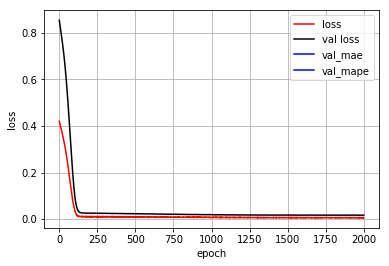

RMSE:85.74845529612111  ,MAE:58.825503305288464  ,MAPE:5.226596186002726 
RMSE:78.7547516990522  ,MAE:53.90838321638696  ,MAPE:4.482317723815042 


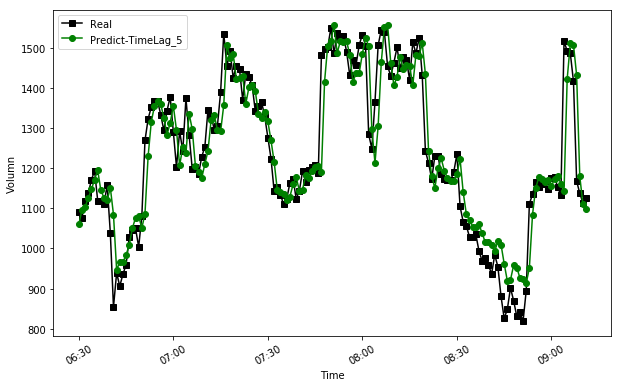

/home/wells/Anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


处理数据: (152, 3)
训练数据: (88, 6)
验证数据: (59, 6)
LSTM预测
Train on 70 samples, validate on 18 samples
Epoch 1/2000
70/70 [==============================] - 4s 62ms/step - loss: 0.3837 - mean_absolute_error: 0.6053 - mean_absolute_percentage_error: 100.8359 - val_loss: 0.7011 - val_mean_absolute_error: 0.8298 - val_mean_absolute_percentage_error: 100.6310
Epoch 2/2000
70/70 [==============================] - 0s 466us/step - loss: 0.3810 - mean_absolute_error: 0.6031 - mean_absolute_percentage_error: 100.4565 - val_loss: 0.6967 - val_mean_absolute_error: 0.8271 - val_mean_absolute_percentage_error: 100.3085
Epoch 3/2000
70/70 [==============================] - 0s 383us/step - loss: 0.3782 - mean_absolute_error: 0.6009 - mean_absolute_percentage_error: 100.0764 - val_loss: 0.6922 - val_mean_absolute_error: 0.8244 - val_mean_absolute_percentage_error: 99.9781
Epoch 4/2000
70/70 [==============================] - 0s 357us/step - loss: 0.3754 - mean_absolute_error: 0.5986 - mean_absolute_percentage_

Epoch 33/2000
70/70 [==============================] - 0s 370us/step - loss: 0.2922 - mean_absolute_error: 0.5266 - mean_absolute_percentage_error: 87.3359 - val_loss: 0.5517 - val_mean_absolute_error: 0.7351 - val_mean_absolute_percentage_error: 89.0356
Epoch 34/2000
70/70 [==============================] - 0s 373us/step - loss: 0.2884 - mean_absolute_error: 0.5232 - mean_absolute_percentage_error: 86.7808 - val_loss: 0.5462 - val_mean_absolute_error: 0.7314 - val_mean_absolute_percentage_error: 88.5829
Epoch 35/2000
70/70 [==============================] - 0s 654us/step - loss: 0.2848 - mean_absolute_error: 0.5198 - mean_absolute_percentage_error: 86.1929 - val_loss: 0.5406 - val_mean_absolute_error: 0.7276 - val_mean_absolute_percentage_error: 88.1196
Epoch 36/2000
70/70 [==============================] - 0s 372us/step - loss: 0.2829 - mean_absolute_error: 0.5177 - mean_absolute_percentage_error: 85.7855 - val_loss: 0.5349 - val_mean_absolute_error: 0.7237 - val_mean_absolute_percen

70/70 [==============================] - 0s 384us/step - loss: 0.1662 - mean_absolute_error: 0.3941 - mean_absolute_percentage_error: 64.8007 - val_loss: 0.3307 - val_mean_absolute_error: 0.5673 - val_mean_absolute_percentage_error: 68.5264
Epoch 66/2000
70/70 [==============================] - 0s 364us/step - loss: 0.1630 - mean_absolute_error: 0.3902 - mean_absolute_percentage_error: 64.1270 - val_loss: 0.3226 - val_mean_absolute_error: 0.5602 - val_mean_absolute_percentage_error: 67.6600
Epoch 67/2000
70/70 [==============================] - 0s 459us/step - loss: 0.1582 - mean_absolute_error: 0.3838 - mean_absolute_percentage_error: 62.9889 - val_loss: 0.3144 - val_mean_absolute_error: 0.5529 - val_mean_absolute_percentage_error: 66.7787
Epoch 68/2000
70/70 [==============================] - 0s 449us/step - loss: 0.1530 - mean_absolute_error: 0.3778 - mean_absolute_percentage_error: 62.0410 - val_loss: 0.3062 - val_mean_absolute_error: 0.5456 - val_mean_absolute_percentage_error: 65

70/70 [==============================] - 0s 382us/step - loss: 0.0397 - mean_absolute_error: 0.1860 - mean_absolute_percentage_error: 29.8667 - val_loss: 0.0895 - val_mean_absolute_error: 0.2894 - val_mean_absolute_percentage_error: 34.6554
Epoch 98/2000
70/70 [==============================] - 0s 435us/step - loss: 0.0380 - mean_absolute_error: 0.1820 - mean_absolute_percentage_error: 29.2121 - val_loss: 0.0841 - val_mean_absolute_error: 0.2800 - val_mean_absolute_percentage_error: 33.5190
Epoch 99/2000
70/70 [==============================] - 0s 377us/step - loss: 0.0348 - mean_absolute_error: 0.1714 - mean_absolute_percentage_error: 27.2983 - val_loss: 0.0790 - val_mean_absolute_error: 0.2708 - val_mean_absolute_percentage_error: 32.3888
Epoch 100/2000
70/70 [==============================] - 0s 372us/step - loss: 0.0318 - mean_absolute_error: 0.1649 - mean_absolute_percentage_error: 26.3662 - val_loss: 0.0740 - val_mean_absolute_error: 0.2615 - val_mean_absolute_percentage_error: 3

70/70 [==============================] - 0s 455us/step - loss: 0.0050 - mean_absolute_error: 0.0554 - mean_absolute_percentage_error: 9.8175 - val_loss: 0.0104 - val_mean_absolute_error: 0.0735 - val_mean_absolute_percentage_error: 8.3877
Epoch 130/2000
70/70 [==============================] - 0s 389us/step - loss: 0.0051 - mean_absolute_error: 0.0607 - mean_absolute_percentage_error: 10.4919 - val_loss: 0.0100 - val_mean_absolute_error: 0.0705 - val_mean_absolute_percentage_error: 8.0209
Epoch 131/2000
70/70 [==============================] - 0s 440us/step - loss: 0.0045 - mean_absolute_error: 0.0531 - mean_absolute_percentage_error: 9.2806 - val_loss: 0.0096 - val_mean_absolute_error: 0.0678 - val_mean_absolute_percentage_error: 7.7064
Epoch 132/2000
70/70 [==============================] - 0s 399us/step - loss: 0.0041 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 9.0309 - val_loss: 0.0092 - val_mean_absolute_error: 0.0654 - val_mean_absolute_percentage_error: 7.420

70/70 [==============================] - 0s 426us/step - loss: 0.0044 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 9.2557 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567 - val_mean_absolute_percentage_error: 6.4392
Epoch 162/2000
70/70 [==============================] - 0s 489us/step - loss: 0.0035 - mean_absolute_error: 0.0466 - mean_absolute_percentage_error: 8.7450 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567 - val_mean_absolute_percentage_error: 6.4359
Epoch 163/2000
70/70 [==============================] - 0s 531us/step - loss: 0.0042 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 9.6877 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567 - val_mean_absolute_percentage_error: 6.4350
Epoch 164/2000
70/70 [==============================] - 0s 461us/step - loss: 0.0044 - mean_absolute_error: 0.0516 - mean_absolute_percentage_error: 9.4347 - val_loss: 0.0066 - val_mean_absolute_error: 0.0567 - val_mean_absolute_percentage_error: 6.4353

70/70 [==============================] - 0s 387us/step - loss: 0.0039 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 8.7314 - val_loss: 0.0066 - val_mean_absolute_error: 0.0566 - val_mean_absolute_percentage_error: 6.4241
Epoch 194/2000
70/70 [==============================] - 0s 367us/step - loss: 0.0040 - mean_absolute_error: 0.0497 - mean_absolute_percentage_error: 8.9358 - val_loss: 0.0066 - val_mean_absolute_error: 0.0566 - val_mean_absolute_percentage_error: 6.4205
Epoch 195/2000
70/70 [==============================] - 0s 403us/step - loss: 0.0039 - mean_absolute_error: 0.0468 - mean_absolute_percentage_error: 8.5983 - val_loss: 0.0066 - val_mean_absolute_error: 0.0565 - val_mean_absolute_percentage_error: 6.4158
Epoch 196/2000
70/70 [==============================] - 0s 458us/step - loss: 0.0042 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 9.4198 - val_loss: 0.0066 - val_mean_absolute_error: 0.0565 - val_mean_absolute_percentage_error: 6.4131

70/70 [==============================] - 0s 377us/step - loss: 0.0043 - mean_absolute_error: 0.0521 - mean_absolute_percentage_error: 9.2470 - val_loss: 0.0064 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3674
Epoch 226/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0043 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 9.4008 - val_loss: 0.0064 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3657
Epoch 227/2000
70/70 [==============================] - 0s 363us/step - loss: 0.0042 - mean_absolute_error: 0.0527 - mean_absolute_percentage_error: 9.6085 - val_loss: 0.0064 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3660
Epoch 228/2000
70/70 [==============================] - 0s 380us/step - loss: 0.0042 - mean_absolute_error: 0.0515 - mean_absolute_percentage_error: 9.3950 - val_loss: 0.0064 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3660

70/70 [==============================] - 0s 375us/step - loss: 0.0040 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 9.0091 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3669
Epoch 258/2000
70/70 [==============================] - 0s 352us/step - loss: 0.0034 - mean_absolute_error: 0.0465 - mean_absolute_percentage_error: 8.4757 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3661
Epoch 259/2000
70/70 [==============================] - 0s 357us/step - loss: 0.0042 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 9.4977 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3671
Epoch 260/2000
70/70 [==============================] - 0s 361us/step - loss: 0.0039 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 9.0676 - val_loss: 0.0065 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3681

70/70 [==============================] - 0s 358us/step - loss: 0.0044 - mean_absolute_error: 0.0492 - mean_absolute_percentage_error: 9.1949 - val_loss: 0.0065 - val_mean_absolute_error: 0.0560 - val_mean_absolute_percentage_error: 6.3512
Epoch 290/2000
70/70 [==============================] - 0s 352us/step - loss: 0.0043 - mean_absolute_error: 0.0489 - mean_absolute_percentage_error: 9.2015 - val_loss: 0.0065 - val_mean_absolute_error: 0.0560 - val_mean_absolute_percentage_error: 6.3574
Epoch 291/2000
70/70 [==============================] - 0s 355us/step - loss: 0.0041 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 9.1214 - val_loss: 0.0066 - val_mean_absolute_error: 0.0560 - val_mean_absolute_percentage_error: 6.3606
Epoch 292/2000
70/70 [==============================] - 0s 343us/step - loss: 0.0038 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 9.1237 - val_loss: 0.0066 - val_mean_absolute_error: 0.0561 - val_mean_absolute_percentage_error: 6.3620

70/70 [==============================] - 0s 364us/step - loss: 0.0039 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 8.8084 - val_loss: 0.0063 - val_mean_absolute_error: 0.0554 - val_mean_absolute_percentage_error: 6.2903
Epoch 322/2000
70/70 [==============================] - 0s 483us/step - loss: 0.0040 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 8.8889 - val_loss: 0.0063 - val_mean_absolute_error: 0.0554 - val_mean_absolute_percentage_error: 6.2841
Epoch 323/2000
70/70 [==============================] - 0s 447us/step - loss: 0.0040 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 9.0928 - val_loss: 0.0063 - val_mean_absolute_error: 0.0553 - val_mean_absolute_percentage_error: 6.2816
Epoch 324/2000
70/70 [==============================] - 0s 354us/step - loss: 0.0045 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 9.5466 - val_loss: 0.0063 - val_mean_absolute_error: 0.0553 - val_mean_absolute_percentage_error: 6.2823

70/70 [==============================] - 0s 348us/step - loss: 0.0042 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 9.5884 - val_loss: 0.0062 - val_mean_absolute_error: 0.0550 - val_mean_absolute_percentage_error: 6.2448
Epoch 354/2000
70/70 [==============================] - 0s 392us/step - loss: 0.0040 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 9.0632 - val_loss: 0.0063 - val_mean_absolute_error: 0.0551 - val_mean_absolute_percentage_error: 6.2568
Epoch 355/2000
70/70 [==============================] - 0s 363us/step - loss: 0.0038 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 8.9185 - val_loss: 0.0063 - val_mean_absolute_error: 0.0552 - val_mean_absolute_percentage_error: 6.2662
Epoch 356/2000
70/70 [==============================] - 0s 363us/step - loss: 0.0048 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 9.7759 - val_loss: 0.0063 - val_mean_absolute_error: 0.0552 - val_mean_absolute_percentage_error: 6.2657

70/70 [==============================] - 0s 486us/step - loss: 0.0045 - mean_absolute_error: 0.0557 - mean_absolute_percentage_error: 10.0491 - val_loss: 0.0061 - val_mean_absolute_error: 0.0545 - val_mean_absolute_percentage_error: 6.1851
Epoch 386/2000
70/70 [==============================] - 0s 445us/step - loss: 0.0042 - mean_absolute_error: 0.0503 - mean_absolute_percentage_error: 9.3142 - val_loss: 0.0061 - val_mean_absolute_error: 0.0545 - val_mean_absolute_percentage_error: 6.1928
Epoch 387/2000
70/70 [==============================] - 0s 397us/step - loss: 0.0047 - mean_absolute_error: 0.0546 - mean_absolute_percentage_error: 10.0543 - val_loss: 0.0062 - val_mean_absolute_error: 0.0546 - val_mean_absolute_percentage_error: 6.2036
Epoch 388/2000
70/70 [==============================] - 0s 414us/step - loss: 0.0038 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 9.0047 - val_loss: 0.0062 - val_mean_absolute_error: 0.0547 - val_mean_absolute_percentage_error: 6.21

70/70 [==============================] - 0s 419us/step - loss: 0.0035 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 8.7375 - val_loss: 0.0059 - val_mean_absolute_error: 0.0539 - val_mean_absolute_percentage_error: 6.1219
Epoch 418/2000
70/70 [==============================] - 0s 390us/step - loss: 0.0043 - mean_absolute_error: 0.0502 - mean_absolute_percentage_error: 9.3943 - val_loss: 0.0059 - val_mean_absolute_error: 0.0539 - val_mean_absolute_percentage_error: 6.1205
Epoch 419/2000
70/70 [==============================] - 0s 378us/step - loss: 0.0039 - mean_absolute_error: 0.0499 - mean_absolute_percentage_error: 9.2149 - val_loss: 0.0059 - val_mean_absolute_error: 0.0539 - val_mean_absolute_percentage_error: 6.1218
Epoch 420/2000
70/70 [==============================] - 0s 439us/step - loss: 0.0039 - mean_absolute_error: 0.0462 - mean_absolute_percentage_error: 8.5482 - val_loss: 0.0060 - val_mean_absolute_error: 0.0539 - val_mean_absolute_percentage_error: 6.1243

70/70 [==============================] - 0s 371us/step - loss: 0.0041 - mean_absolute_error: 0.0520 - mean_absolute_percentage_error: 9.3761 - val_loss: 0.0061 - val_mean_absolute_error: 0.0542 - val_mean_absolute_percentage_error: 6.1500
Epoch 450/2000
70/70 [==============================] - 0s 381us/step - loss: 0.0036 - mean_absolute_error: 0.0472 - mean_absolute_percentage_error: 8.7115 - val_loss: 0.0061 - val_mean_absolute_error: 0.0541 - val_mean_absolute_percentage_error: 6.1433
Epoch 451/2000
70/70 [==============================] - 0s 387us/step - loss: 0.0039 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 9.1393 - val_loss: 0.0061 - val_mean_absolute_error: 0.0540 - val_mean_absolute_percentage_error: 6.1364
Epoch 452/2000
70/70 [==============================] - 0s 398us/step - loss: 0.0040 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 9.5088 - val_loss: 0.0061 - val_mean_absolute_error: 0.0540 - val_mean_absolute_percentage_error: 6.1369

70/70 [==============================] - 0s 374us/step - loss: 0.0042 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 9.5399 - val_loss: 0.0060 - val_mean_absolute_error: 0.0537 - val_mean_absolute_percentage_error: 6.1002
Epoch 482/2000
70/70 [==============================] - 0s 374us/step - loss: 0.0036 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 8.7052 - val_loss: 0.0060 - val_mean_absolute_error: 0.0537 - val_mean_absolute_percentage_error: 6.0972
Epoch 483/2000
70/70 [==============================] - 0s 365us/step - loss: 0.0047 - mean_absolute_error: 0.0538 - mean_absolute_percentage_error: 9.7630 - val_loss: 0.0060 - val_mean_absolute_error: 0.0537 - val_mean_absolute_percentage_error: 6.0938
Epoch 484/2000
70/70 [==============================] - 0s 367us/step - loss: 0.0041 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 8.9444 - val_loss: 0.0060 - val_mean_absolute_error: 0.0536 - val_mean_absolute_percentage_error: 6.0911

70/70 [==============================] - 0s 387us/step - loss: 0.0034 - mean_absolute_error: 0.0474 - mean_absolute_percentage_error: 8.7432 - val_loss: 0.0059 - val_mean_absolute_error: 0.0532 - val_mean_absolute_percentage_error: 6.0404
Epoch 514/2000
70/70 [==============================] - 0s 440us/step - loss: 0.0037 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 8.7446 - val_loss: 0.0058 - val_mean_absolute_error: 0.0531 - val_mean_absolute_percentage_error: 6.0283
Epoch 515/2000
70/70 [==============================] - 0s 406us/step - loss: 0.0039 - mean_absolute_error: 0.0496 - mean_absolute_percentage_error: 9.0082 - val_loss: 0.0058 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 6.0202
Epoch 516/2000
70/70 [==============================] - 0s 384us/step - loss: 0.0035 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 8.1548 - val_loss: 0.0058 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 6.0209

70/70 [==============================] - 0s 384us/step - loss: 0.0041 - mean_absolute_error: 0.0496 - mean_absolute_percentage_error: 9.0750 - val_loss: 0.0059 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 6.0221
Epoch 546/2000
70/70 [==============================] - 0s 404us/step - loss: 0.0041 - mean_absolute_error: 0.0512 - mean_absolute_percentage_error: 9.4288 - val_loss: 0.0059 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 6.0205
Epoch 547/2000
70/70 [==============================] - 0s 409us/step - loss: 0.0043 - mean_absolute_error: 0.0533 - mean_absolute_percentage_error: 9.7253 - val_loss: 0.0059 - val_mean_absolute_error: 0.0529 - val_mean_absolute_percentage_error: 6.0106
Epoch 548/2000
70/70 [==============================] - 0s 377us/step - loss: 0.0036 - mean_absolute_error: 0.0458 - mean_absolute_percentage_error: 8.5851 - val_loss: 0.0058 - val_mean_absolute_error: 0.0528 - val_mean_absolute_percentage_error: 6.0006

70/70 [==============================] - 0s 367us/step - loss: 0.0034 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 8.5287 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525 - val_mean_absolute_percentage_error: 5.9605
Epoch 578/2000
70/70 [==============================] - 0s 380us/step - loss: 0.0040 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 8.9478 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525 - val_mean_absolute_percentage_error: 5.9669
Epoch 579/2000
70/70 [==============================] - 0s 366us/step - loss: 0.0039 - mean_absolute_error: 0.0489 - mean_absolute_percentage_error: 9.0127 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525 - val_mean_absolute_percentage_error: 5.9703
Epoch 580/2000
70/70 [==============================] - 0s 390us/step - loss: 0.0044 - mean_absolute_error: 0.0526 - mean_absolute_percentage_error: 9.5456 - val_loss: 0.0058 - val_mean_absolute_error: 0.0525 - val_mean_absolute_percentage_error: 5.9711

70/70 [==============================] - 0s 414us/step - loss: 0.0039 - mean_absolute_error: 0.0470 - mean_absolute_percentage_error: 8.8483 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522 - val_mean_absolute_percentage_error: 5.9345
Epoch 610/2000
70/70 [==============================] - 0s 425us/step - loss: 0.0035 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 8.7002 - val_loss: 0.0057 - val_mean_absolute_error: 0.0522 - val_mean_absolute_percentage_error: 5.9310
Epoch 611/2000
70/70 [==============================] - 0s 424us/step - loss: 0.0039 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 8.8689 - val_loss: 0.0057 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 5.9167
Epoch 612/2000
70/70 [==============================] - 0s 403us/step - loss: 0.0038 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 9.0964 - val_loss: 0.0056 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 5.8978

70/70 [==============================] - 0s 357us/step - loss: 0.0037 - mean_absolute_error: 0.0513 - mean_absolute_percentage_error: 9.1559 - val_loss: 0.0059 - val_mean_absolute_error: 0.0522 - val_mean_absolute_percentage_error: 5.9365
Epoch 642/2000
70/70 [==============================] - 0s 361us/step - loss: 0.0035 - mean_absolute_error: 0.0466 - mean_absolute_percentage_error: 8.5443 - val_loss: 0.0058 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 5.9215
Epoch 643/2000
70/70 [==============================] - 0s 374us/step - loss: 0.0039 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 9.0533 - val_loss: 0.0058 - val_mean_absolute_error: 0.0520 - val_mean_absolute_percentage_error: 5.9089
Epoch 644/2000
70/70 [==============================] - 0s 360us/step - loss: 0.0042 - mean_absolute_error: 0.0525 - mean_absolute_percentage_error: 9.3963 - val_loss: 0.0057 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 5.8910

70/70 [==============================] - 0s 351us/step - loss: 0.0037 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 8.8434 - val_loss: 0.0056 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 5.8473
Epoch 674/2000
70/70 [==============================] - 0s 350us/step - loss: 0.0034 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.4035 - val_loss: 0.0056 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 5.8496
Epoch 675/2000
70/70 [==============================] - 0s 352us/step - loss: 0.0043 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 9.2792 - val_loss: 0.0056 - val_mean_absolute_error: 0.0515 - val_mean_absolute_percentage_error: 5.8544
Epoch 676/2000
70/70 [==============================] - 0s 354us/step - loss: 0.0042 - mean_absolute_error: 0.0491 - mean_absolute_percentage_error: 8.9533 - val_loss: 0.0057 - val_mean_absolute_error: 0.0515 - val_mean_absolute_percentage_error: 5.8552

70/70 [==============================] - 0s 376us/step - loss: 0.0039 - mean_absolute_error: 0.0485 - mean_absolute_percentage_error: 9.0252 - val_loss: 0.0054 - val_mean_absolute_error: 0.0508 - val_mean_absolute_percentage_error: 5.7719
Epoch 706/2000
70/70 [==============================] - 0s 378us/step - loss: 0.0038 - mean_absolute_error: 0.0492 - mean_absolute_percentage_error: 8.8213 - val_loss: 0.0054 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 5.7534
Epoch 707/2000
70/70 [==============================] - 0s 412us/step - loss: 0.0039 - mean_absolute_error: 0.0504 - mean_absolute_percentage_error: 9.1588 - val_loss: 0.0053 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 5.7406
Epoch 708/2000
70/70 [==============================] - 0s 424us/step - loss: 0.0040 - mean_absolute_error: 0.0486 - mean_absolute_percentage_error: 8.9089 - val_loss: 0.0053 - val_mean_absolute_error: 0.0503 - val_mean_absolute_percentage_error: 5.7241

70/70 [==============================] - 0s 407us/step - loss: 0.0036 - mean_absolute_error: 0.0465 - mean_absolute_percentage_error: 8.4851 - val_loss: 0.0054 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 5.7392
Epoch 738/2000
70/70 [==============================] - 0s 423us/step - loss: 0.0044 - mean_absolute_error: 0.0530 - mean_absolute_percentage_error: 9.6644 - val_loss: 0.0054 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 5.7416
Epoch 739/2000
70/70 [==============================] - 0s 408us/step - loss: 0.0041 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 9.2035 - val_loss: 0.0055 - val_mean_absolute_error: 0.0505 - val_mean_absolute_percentage_error: 5.7477
Epoch 740/2000
70/70 [==============================] - 0s 373us/step - loss: 0.0042 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 9.3568 - val_loss: 0.0055 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 5.7615

70/70 [==============================] - 0s 371us/step - loss: 0.0034 - mean_absolute_error: 0.0450 - mean_absolute_percentage_error: 8.3806 - val_loss: 0.0052 - val_mean_absolute_error: 0.0496 - val_mean_absolute_percentage_error: 5.6403
Epoch 770/2000
70/70 [==============================] - 0s 390us/step - loss: 0.0036 - mean_absolute_error: 0.0482 - mean_absolute_percentage_error: 8.6659 - val_loss: 0.0052 - val_mean_absolute_error: 0.0496 - val_mean_absolute_percentage_error: 5.6380
Epoch 771/2000
70/70 [==============================] - 0s 399us/step - loss: 0.0041 - mean_absolute_error: 0.0519 - mean_absolute_percentage_error: 9.5407 - val_loss: 0.0052 - val_mean_absolute_error: 0.0496 - val_mean_absolute_percentage_error: 5.6471
Epoch 772/2000
70/70 [==============================] - 0s 440us/step - loss: 0.0037 - mean_absolute_error: 0.0473 - mean_absolute_percentage_error: 8.6558 - val_loss: 0.0052 - val_mean_absolute_error: 0.0497 - val_mean_absolute_percentage_error: 5.6603

70/70 [==============================] - 0s 354us/step - loss: 0.0039 - mean_absolute_error: 0.0498 - mean_absolute_percentage_error: 8.9127 - val_loss: 0.0053 - val_mean_absolute_error: 0.0497 - val_mean_absolute_percentage_error: 5.6501
Epoch 802/2000
70/70 [==============================] - 0s 344us/step - loss: 0.0038 - mean_absolute_error: 0.0506 - mean_absolute_percentage_error: 9.2164 - val_loss: 0.0053 - val_mean_absolute_error: 0.0497 - val_mean_absolute_percentage_error: 5.6547
Epoch 803/2000
70/70 [==============================] - 0s 339us/step - loss: 0.0038 - mean_absolute_error: 0.0480 - mean_absolute_percentage_error: 8.7577 - val_loss: 0.0053 - val_mean_absolute_error: 0.0497 - val_mean_absolute_percentage_error: 5.6512
Epoch 804/2000
70/70 [==============================] - 0s 367us/step - loss: 0.0034 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 8.4486 - val_loss: 0.0053 - val_mean_absolute_error: 0.0495 - val_mean_absolute_percentage_error: 5.6352

70/70 [==============================] - 0s 363us/step - loss: 0.0037 - mean_absolute_error: 0.0495 - mean_absolute_percentage_error: 8.9228 - val_loss: 0.0051 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 5.5584
Epoch 834/2000
70/70 [==============================] - 0s 347us/step - loss: 0.0037 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 8.7704 - val_loss: 0.0051 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 5.5559
Epoch 835/2000
70/70 [==============================] - 0s 354us/step - loss: 0.0037 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 8.3058 - val_loss: 0.0051 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 5.5543
Epoch 836/2000
70/70 [==============================] - 0s 347us/step - loss: 0.0039 - mean_absolute_error: 0.0484 - mean_absolute_percentage_error: 8.9912 - val_loss: 0.0051 - val_mean_absolute_error: 0.0488 - val_mean_absolute_percentage_error: 5.5587

70/70 [==============================] - 0s 367us/step - loss: 0.0037 - mean_absolute_error: 0.0479 - mean_absolute_percentage_error: 8.5754 - val_loss: 0.0050 - val_mean_absolute_error: 0.0483 - val_mean_absolute_percentage_error: 5.4943
Epoch 866/2000
70/70 [==============================] - 0s 424us/step - loss: 0.0036 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.2563 - val_loss: 0.0049 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 5.4785
Epoch 867/2000
70/70 [==============================] - 0s 418us/step - loss: 0.0034 - mean_absolute_error: 0.0450 - mean_absolute_percentage_error: 8.3856 - val_loss: 0.0049 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 5.4748
Epoch 868/2000
70/70 [==============================] - 0s 417us/step - loss: 0.0037 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 8.9533 - val_loss: 0.0050 - val_mean_absolute_error: 0.0481 - val_mean_absolute_percentage_error: 5.4827

70/70 [==============================] - 0s 380us/step - loss: 0.0035 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 7.8659 - val_loss: 0.0050 - val_mean_absolute_error: 0.0480 - val_mean_absolute_percentage_error: 5.4716
Epoch 898/2000
70/70 [==============================] - 0s 436us/step - loss: 0.0033 - mean_absolute_error: 0.0461 - mean_absolute_percentage_error: 8.4890 - val_loss: 0.0049 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 5.4531
Epoch 899/2000
70/70 [==============================] - 0s 413us/step - loss: 0.0036 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 8.6641 - val_loss: 0.0049 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 5.4435
Epoch 900/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0035 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 8.6081 - val_loss: 0.0049 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 5.4502

70/70 [==============================] - 0s 392us/step - loss: 0.0030 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 7.8451 - val_loss: 0.0051 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 5.4557
Epoch 930/2000
70/70 [==============================] - 0s 370us/step - loss: 0.0038 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 8.9002 - val_loss: 0.0051 - val_mean_absolute_error: 0.0479 - val_mean_absolute_percentage_error: 5.4560
Epoch 931/2000
70/70 [==============================] - 0s 363us/step - loss: 0.0030 - mean_absolute_error: 0.0435 - mean_absolute_percentage_error: 7.9147 - val_loss: 0.0050 - val_mean_absolute_error: 0.0478 - val_mean_absolute_percentage_error: 5.4442
Epoch 932/2000
70/70 [==============================] - 0s 350us/step - loss: 0.0037 - mean_absolute_error: 0.0490 - mean_absolute_percentage_error: 8.9503 - val_loss: 0.0049 - val_mean_absolute_error: 0.0476 - val_mean_absolute_percentage_error: 5.4230

70/70 [==============================] - 0s 379us/step - loss: 0.0033 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 8.5930 - val_loss: 0.0047 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 5.3083
Epoch 962/2000
70/70 [==============================] - 0s 377us/step - loss: 0.0034 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 8.4539 - val_loss: 0.0046 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 5.3120
Epoch 963/2000
70/70 [==============================] - 0s 400us/step - loss: 0.0029 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 7.7903 - val_loss: 0.0046 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 5.3194
Epoch 964/2000
70/70 [==============================] - 0s 391us/step - loss: 0.0038 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 8.9083 - val_loss: 0.0045 - val_mean_absolute_error: 0.0467 - val_mean_absolute_percentage_error: 5.3253

70/70 [==============================] - 0s 435us/step - loss: 0.0030 - mean_absolute_error: 0.0442 - mean_absolute_percentage_error: 8.2345 - val_loss: 0.0048 - val_mean_absolute_error: 0.0468 - val_mean_absolute_percentage_error: 5.3289
Epoch 994/2000
70/70 [==============================] - 0s 444us/step - loss: 0.0041 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 8.8997 - val_loss: 0.0048 - val_mean_absolute_error: 0.0466 - val_mean_absolute_percentage_error: 5.3163
Epoch 995/2000
70/70 [==============================] - 0s 380us/step - loss: 0.0036 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 8.6254 - val_loss: 0.0047 - val_mean_absolute_error: 0.0464 - val_mean_absolute_percentage_error: 5.2919
Epoch 996/2000
70/70 [==============================] - 0s 393us/step - loss: 0.0037 - mean_absolute_error: 0.0441 - mean_absolute_percentage_error: 8.1023 - val_loss: 0.0047 - val_mean_absolute_error: 0.0463 - val_mean_absolute_percentage_error: 5.2740

70/70 [==============================] - 0s 438us/step - loss: 0.0031 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 7.8453 - val_loss: 0.0045 - val_mean_absolute_error: 0.0461 - val_mean_absolute_percentage_error: 5.2530
Epoch 1026/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0032 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 7.9119 - val_loss: 0.0045 - val_mean_absolute_error: 0.0460 - val_mean_absolute_percentage_error: 5.2522
Epoch 1027/2000
70/70 [==============================] - 0s 418us/step - loss: 0.0036 - mean_absolute_error: 0.0476 - mean_absolute_percentage_error: 8.8842 - val_loss: 0.0045 - val_mean_absolute_error: 0.0460 - val_mean_absolute_percentage_error: 5.2483
Epoch 1028/2000
70/70 [==============================] - 0s 444us/step - loss: 0.0030 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 7.8009 - val_loss: 0.0046 - val_mean_absolute_error: 0.0460 - val_mean_absolute_percentage_error: 5.2

70/70 [==============================] - 0s 446us/step - loss: 0.0039 - mean_absolute_error: 0.0475 - mean_absolute_percentage_error: 8.6112 - val_loss: 0.0044 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 5.2383
Epoch 1058/2000
70/70 [==============================] - 0s 461us/step - loss: 0.0037 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 8.6936 - val_loss: 0.0044 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 5.2414
Epoch 1059/2000
70/70 [==============================] - 0s 389us/step - loss: 0.0030 - mean_absolute_error: 0.0412 - mean_absolute_percentage_error: 7.5705 - val_loss: 0.0043 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 5.2446
Epoch 1060/2000
70/70 [==============================] - 0s 415us/step - loss: 0.0028 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 7.6955 - val_loss: 0.0043 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 5.2

70/70 [==============================] - 0s 401us/step - loss: 0.0036 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.2129 - val_loss: 0.0046 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 5.1860
Epoch 1090/2000
70/70 [==============================] - 0s 402us/step - loss: 0.0033 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 8.3287 - val_loss: 0.0046 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 5.1824
Epoch 1091/2000
70/70 [==============================] - 0s 437us/step - loss: 0.0032 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 7.7504 - val_loss: 0.0046 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 5.1805
Epoch 1092/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0028 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 7.9872 - val_loss: 0.0046 - val_mean_absolute_error: 0.0454 - val_mean_absolute_percentage_error: 5.1

70/70 [==============================] - 0s 362us/step - loss: 0.0036 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 8.3681 - val_loss: 0.0041 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 5.2033
Epoch 1122/2000
70/70 [==============================] - 0s 359us/step - loss: 0.0034 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 8.3144 - val_loss: 0.0041 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 5.2040
Epoch 1123/2000
70/70 [==============================] - 0s 369us/step - loss: 0.0037 - mean_absolute_error: 0.0501 - mean_absolute_percentage_error: 9.2153 - val_loss: 0.0041 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 5.2057
Epoch 1124/2000
70/70 [==============================] - 0s 367us/step - loss: 0.0028 - mean_absolute_error: 0.0413 - mean_absolute_percentage_error: 7.6063 - val_loss: 0.0042 - val_mean_absolute_error: 0.0455 - val_mean_absolute_percentage_error: 5.1

70/70 [==============================] - 0s 375us/step - loss: 0.0031 - mean_absolute_error: 0.0422 - mean_absolute_percentage_error: 7.6619 - val_loss: 0.0042 - val_mean_absolute_error: 0.0451 - val_mean_absolute_percentage_error: 5.1526
Epoch 1154/2000
70/70 [==============================] - 0s 358us/step - loss: 0.0036 - mean_absolute_error: 0.0450 - mean_absolute_percentage_error: 8.3169 - val_loss: 0.0041 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 5.1624
Epoch 1155/2000
70/70 [==============================] - 0s 396us/step - loss: 0.0034 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 8.2209 - val_loss: 0.0041 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 5.1699
Epoch 1156/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0029 - mean_absolute_error: 0.0410 - mean_absolute_percentage_error: 7.5308 - val_loss: 0.0041 - val_mean_absolute_error: 0.0452 - val_mean_absolute_percentage_error: 5.1

70/70 [==============================] - 0s 350us/step - loss: 0.0034 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 8.4298 - val_loss: 0.0041 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 5.1361
Epoch 1186/2000
70/70 [==============================] - 0s 373us/step - loss: 0.0038 - mean_absolute_error: 0.0488 - mean_absolute_percentage_error: 8.8304 - val_loss: 0.0041 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 5.1357
Epoch 1187/2000
70/70 [==============================] - 0s 387us/step - loss: 0.0033 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 8.0621 - val_loss: 0.0041 - val_mean_absolute_error: 0.0449 - val_mean_absolute_percentage_error: 5.1315
Epoch 1188/2000
70/70 [==============================] - 0s 419us/step - loss: 0.0034 - mean_absolute_error: 0.0444 - mean_absolute_percentage_error: 8.0862 - val_loss: 0.0041 - val_mean_absolute_error: 0.0448 - val_mean_absolute_percentage_error: 5.1

70/70 [==============================] - 0s 356us/step - loss: 0.0035 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 8.4578 - val_loss: 0.0040 - val_mean_absolute_error: 0.0446 - val_mean_absolute_percentage_error: 5.1046
Epoch 1218/2000
70/70 [==============================] - 0s 541us/step - loss: 0.0034 - mean_absolute_error: 0.0464 - mean_absolute_percentage_error: 8.4643 - val_loss: 0.0042 - val_mean_absolute_error: 0.0445 - val_mean_absolute_percentage_error: 5.0838
Epoch 1219/2000
70/70 [==============================] - 0s 389us/step - loss: 0.0038 - mean_absolute_error: 0.0483 - mean_absolute_percentage_error: 8.7562 - val_loss: 0.0043 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 5.0600
Epoch 1220/2000
70/70 [==============================] - 0s 396us/step - loss: 0.0038 - mean_absolute_error: 0.0477 - mean_absolute_percentage_error: 8.4678 - val_loss: 0.0044 - val_mean_absolute_error: 0.0443 - val_mean_absolute_percentage_error: 5.0

70/70 [==============================] - 0s 408us/step - loss: 0.0033 - mean_absolute_error: 0.0434 - mean_absolute_percentage_error: 7.9675 - val_loss: 0.0042 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 5.0404
Epoch 1250/2000
70/70 [==============================] - 0s 418us/step - loss: 0.0032 - mean_absolute_error: 0.0437 - mean_absolute_percentage_error: 7.9996 - val_loss: 0.0042 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 5.0418
Epoch 1251/2000
70/70 [==============================] - 0s 376us/step - loss: 0.0035 - mean_absolute_error: 0.0472 - mean_absolute_percentage_error: 8.3685 - val_loss: 0.0041 - val_mean_absolute_error: 0.0441 - val_mean_absolute_percentage_error: 5.0438
Epoch 1252/2000
70/70 [==============================] - 0s 380us/step - loss: 0.0032 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 7.9424 - val_loss: 0.0041 - val_mean_absolute_error: 0.0442 - val_mean_absolute_percentage_error: 5.0

70/70 [==============================] - 0s 488us/step - loss: 0.0036 - mean_absolute_error: 0.0478 - mean_absolute_percentage_error: 8.7224 - val_loss: 0.0040 - val_mean_absolute_error: 0.0440 - val_mean_absolute_percentage_error: 5.0264
Epoch 1282/2000
70/70 [==============================] - 0s 395us/step - loss: 0.0033 - mean_absolute_error: 0.0449 - mean_absolute_percentage_error: 8.1708 - val_loss: 0.0040 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 5.0229
Epoch 1283/2000
70/70 [==============================] - 0s 382us/step - loss: 0.0030 - mean_absolute_error: 0.0457 - mean_absolute_percentage_error: 8.2652 - val_loss: 0.0041 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 5.0167
Epoch 1284/2000
70/70 [==============================] - 0s 445us/step - loss: 0.0033 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 8.3960 - val_loss: 0.0041 - val_mean_absolute_error: 0.0439 - val_mean_absolute_percentage_error: 5.0

70/70 [==============================] - 0s 382us/step - loss: 0.0031 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 7.6996 - val_loss: 0.0038 - val_mean_absolute_error: 0.0438 - val_mean_absolute_percentage_error: 5.0219
Epoch 1314/2000
70/70 [==============================] - 0s 375us/step - loss: 0.0031 - mean_absolute_error: 0.0446 - mean_absolute_percentage_error: 8.1361 - val_loss: 0.0039 - val_mean_absolute_error: 0.0437 - val_mean_absolute_percentage_error: 5.0050
Epoch 1315/2000
70/70 [==============================] - 0s 359us/step - loss: 0.0033 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 8.0794 - val_loss: 0.0040 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 4.9890
Epoch 1316/2000
70/70 [==============================] - 0s 472us/step - loss: 0.0031 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 7.7512 - val_loss: 0.0040 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 4.9

70/70 [==============================] - 0s 373us/step - loss: 0.0036 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 8.3829 - val_loss: 0.0038 - val_mean_absolute_error: 0.0435 - val_mean_absolute_percentage_error: 4.9869
Epoch 1346/2000
70/70 [==============================] - 0s 355us/step - loss: 0.0035 - mean_absolute_error: 0.0451 - mean_absolute_percentage_error: 8.0634 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 4.9888
Epoch 1347/2000
70/70 [==============================] - 0s 382us/step - loss: 0.0031 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 7.8891 - val_loss: 0.0038 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 4.9899
Epoch 1348/2000
70/70 [==============================] - 0s 373us/step - loss: 0.0030 - mean_absolute_error: 0.0414 - mean_absolute_percentage_error: 7.5532 - val_loss: 0.0037 - val_mean_absolute_error: 0.0436 - val_mean_absolute_percentage_error: 4.9

70/70 [==============================] - 0s 369us/step - loss: 0.0031 - mean_absolute_error: 0.0432 - mean_absolute_percentage_error: 7.9550 - val_loss: 0.0036 - val_mean_absolute_error: 0.0434 - val_mean_absolute_percentage_error: 4.9768
Epoch 1378/2000
70/70 [==============================] - 0s 379us/step - loss: 0.0028 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 7.4815 - val_loss: 0.0037 - val_mean_absolute_error: 0.0433 - val_mean_absolute_percentage_error: 4.9657
Epoch 1379/2000
70/70 [==============================] - 0s 395us/step - loss: 0.0032 - mean_absolute_error: 0.0450 - mean_absolute_percentage_error: 8.1648 - val_loss: 0.0037 - val_mean_absolute_error: 0.0432 - val_mean_absolute_percentage_error: 4.9546
Epoch 1380/2000
70/70 [==============================] - 0s 389us/step - loss: 0.0036 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 8.2945 - val_loss: 0.0038 - val_mean_absolute_error: 0.0432 - val_mean_absolute_percentage_error: 4.9

70/70 [==============================] - 0s 431us/step - loss: 0.0039 - mean_absolute_error: 0.0494 - mean_absolute_percentage_error: 8.9204 - val_loss: 0.0036 - val_mean_absolute_error: 0.0431 - val_mean_absolute_percentage_error: 4.9376
Epoch 1410/2000
70/70 [==============================] - 0s 383us/step - loss: 0.0027 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 7.7234 - val_loss: 0.0037 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 4.9250
Epoch 1411/2000
70/70 [==============================] - 0s 437us/step - loss: 0.0036 - mean_absolute_error: 0.0472 - mean_absolute_percentage_error: 8.4960 - val_loss: 0.0037 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 4.9256
Epoch 1412/2000
70/70 [==============================] - 0s 411us/step - loss: 0.0026 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 7.2048 - val_loss: 0.0037 - val_mean_absolute_error: 0.0430 - val_mean_absolute_percentage_error: 4.9

70/70 [==============================] - 0s 386us/step - loss: 0.0032 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 8.1234 - val_loss: 0.0035 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 4.9200
Epoch 1442/2000
70/70 [==============================] - 0s 388us/step - loss: 0.0024 - mean_absolute_error: 0.0374 - mean_absolute_percentage_error: 6.9736 - val_loss: 0.0035 - val_mean_absolute_error: 0.0429 - val_mean_absolute_percentage_error: 4.9178
Epoch 1443/2000
70/70 [==============================] - 0s 374us/step - loss: 0.0028 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 7.5972 - val_loss: 0.0035 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 4.9154
Epoch 1444/2000
70/70 [==============================] - 0s 379us/step - loss: 0.0032 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.0611 - val_loss: 0.0035 - val_mean_absolute_error: 0.0428 - val_mean_absolute_percentage_error: 4.9

70/70 [==============================] - 0s 355us/step - loss: 0.0031 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 7.4109 - val_loss: 0.0037 - val_mean_absolute_error: 0.0424 - val_mean_absolute_percentage_error: 4.8560
Epoch 1474/2000
70/70 [==============================] - 0s 480us/step - loss: 0.0031 - mean_absolute_error: 0.0440 - mean_absolute_percentage_error: 7.9202 - val_loss: 0.0037 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 4.8483
Epoch 1475/2000
70/70 [==============================] - 0s 402us/step - loss: 0.0029 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 7.7258 - val_loss: 0.0037 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 4.8446
Epoch 1476/2000
70/70 [==============================] - 0s 482us/step - loss: 0.0028 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 7.8110 - val_loss: 0.0037 - val_mean_absolute_error: 0.0423 - val_mean_absolute_percentage_error: 4.8

70/70 [==============================] - 0s 389us/step - loss: 0.0033 - mean_absolute_error: 0.0435 - mean_absolute_percentage_error: 8.0153 - val_loss: 0.0035 - val_mean_absolute_error: 0.0422 - val_mean_absolute_percentage_error: 4.8476
Epoch 1506/2000
70/70 [==============================] - 0s 374us/step - loss: 0.0028 - mean_absolute_error: 0.0403 - mean_absolute_percentage_error: 7.3120 - val_loss: 0.0037 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 4.8144
Epoch 1507/2000
70/70 [==============================] - 0s 382us/step - loss: 0.0030 - mean_absolute_error: 0.0434 - mean_absolute_percentage_error: 7.9241 - val_loss: 0.0039 - val_mean_absolute_error: 0.0420 - val_mean_absolute_percentage_error: 4.8195
Epoch 1508/2000
70/70 [==============================] - 0s 374us/step - loss: 0.0032 - mean_absolute_error: 0.0427 - mean_absolute_percentage_error: 7.5637 - val_loss: 0.0040 - val_mean_absolute_error: 0.0421 - val_mean_absolute_percentage_error: 4.8

70/70 [==============================] - 0s 382us/step - loss: 0.0035 - mean_absolute_error: 0.0437 - mean_absolute_percentage_error: 7.9467 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 4.8170
Epoch 1538/2000
70/70 [==============================] - 0s 378us/step - loss: 0.0037 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 8.0407 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 4.8062
Epoch 1539/2000
70/70 [==============================] - 0s 379us/step - loss: 0.0033 - mean_absolute_error: 0.0465 - mean_absolute_percentage_error: 8.2858 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 4.8064
Epoch 1540/2000
70/70 [==============================] - 0s 360us/step - loss: 0.0030 - mean_absolute_error: 0.0402 - mean_absolute_percentage_error: 7.2961 - val_loss: 0.0035 - val_mean_absolute_error: 0.0419 - val_mean_absolute_percentage_error: 4.8

70/70 [==============================] - 0s 404us/step - loss: 0.0029 - mean_absolute_error: 0.0430 - mean_absolute_percentage_error: 7.7836 - val_loss: 0.0037 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 4.7739
Epoch 1570/2000
70/70 [==============================] - 0s 406us/step - loss: 0.0034 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 7.9948 - val_loss: 0.0036 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 4.7618
Epoch 1571/2000
70/70 [==============================] - 0s 376us/step - loss: 0.0030 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.4647 - val_loss: 0.0035 - val_mean_absolute_error: 0.0415 - val_mean_absolute_percentage_error: 4.7629
Epoch 1572/2000
70/70 [==============================] - 0s 386us/step - loss: 0.0026 - mean_absolute_error: 0.0394 - mean_absolute_percentage_error: 7.0911 - val_loss: 0.0034 - val_mean_absolute_error: 0.0416 - val_mean_absolute_percentage_error: 4.7

70/70 [==============================] - 0s 428us/step - loss: 0.0027 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.2446 - val_loss: 0.0036 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 4.7351
Epoch 1602/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0034 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 7.9136 - val_loss: 0.0036 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 4.7407
Epoch 1603/2000
70/70 [==============================] - 0s 449us/step - loss: 0.0030 - mean_absolute_error: 0.0415 - mean_absolute_percentage_error: 7.3850 - val_loss: 0.0037 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 4.7473
Epoch 1604/2000
70/70 [==============================] - 0s 431us/step - loss: 0.0026 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 7.1787 - val_loss: 0.0036 - val_mean_absolute_error: 0.0413 - val_mean_absolute_percentage_error: 4.7

70/70 [==============================] - 0s 395us/step - loss: 0.0027 - mean_absolute_error: 0.0407 - mean_absolute_percentage_error: 7.4849 - val_loss: 0.0033 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 4.7353
Epoch 1634/2000
70/70 [==============================] - 0s 431us/step - loss: 0.0032 - mean_absolute_error: 0.0428 - mean_absolute_percentage_error: 7.4670 - val_loss: 0.0033 - val_mean_absolute_error: 0.0412 - val_mean_absolute_percentage_error: 4.7369
Epoch 1635/2000
70/70 [==============================] - 0s 391us/step - loss: 0.0030 - mean_absolute_error: 0.0409 - mean_absolute_percentage_error: 7.4775 - val_loss: 0.0033 - val_mean_absolute_error: 0.0411 - val_mean_absolute_percentage_error: 4.7294
Epoch 1636/2000
70/70 [==============================] - 0s 383us/step - loss: 0.0027 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 7.3828 - val_loss: 0.0034 - val_mean_absolute_error: 0.0410 - val_mean_absolute_percentage_error: 4.7

70/70 [==============================] - 0s 359us/step - loss: 0.0027 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 7.2614 - val_loss: 0.0034 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 4.6760
Epoch 1666/2000
70/70 [==============================] - 0s 440us/step - loss: 0.0028 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 7.3585 - val_loss: 0.0034 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 4.6737
Epoch 1667/2000
70/70 [==============================] - 0s 471us/step - loss: 0.0032 - mean_absolute_error: 0.0424 - mean_absolute_percentage_error: 7.6161 - val_loss: 0.0034 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 4.6763
Epoch 1668/2000
70/70 [==============================] - 0s 390us/step - loss: 0.0032 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 8.0026 - val_loss: 0.0034 - val_mean_absolute_error: 0.0407 - val_mean_absolute_percentage_error: 4.6

70/70 [==============================] - 0s 359us/step - loss: 0.0026 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 7.2580 - val_loss: 0.0034 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 4.6615
Epoch 1698/2000
70/70 [==============================] - 0s 354us/step - loss: 0.0028 - mean_absolute_error: 0.0411 - mean_absolute_percentage_error: 7.3918 - val_loss: 0.0034 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 4.6571
Epoch 1699/2000
70/70 [==============================] - 0s 406us/step - loss: 0.0030 - mean_absolute_error: 0.0431 - mean_absolute_percentage_error: 7.6157 - val_loss: 0.0034 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 4.6523
Epoch 1700/2000
70/70 [==============================] - 0s 376us/step - loss: 0.0029 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 7.5381 - val_loss: 0.0034 - val_mean_absolute_error: 0.0405 - val_mean_absolute_percentage_error: 4.6

70/70 [==============================] - 0s 445us/step - loss: 0.0029 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.1186 - val_loss: 0.0035 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 4.6532
Epoch 1730/2000
70/70 [==============================] - 0s 384us/step - loss: 0.0027 - mean_absolute_error: 0.0390 - mean_absolute_percentage_error: 6.9876 - val_loss: 0.0034 - val_mean_absolute_error: 0.0403 - val_mean_absolute_percentage_error: 4.6403
Epoch 1731/2000
70/70 [==============================] - 0s 418us/step - loss: 0.0030 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 7.2826 - val_loss: 0.0033 - val_mean_absolute_error: 0.0402 - val_mean_absolute_percentage_error: 4.6218
Epoch 1732/2000
70/70 [==============================] - 0s 435us/step - loss: 0.0031 - mean_absolute_error: 0.0432 - mean_absolute_percentage_error: 7.8421 - val_loss: 0.0032 - val_mean_absolute_error: 0.0403 - val_mean_absolute_percentage_error: 4.6

70/70 [==============================] - 0s 383us/step - loss: 0.0029 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 7.7053 - val_loss: 0.0034 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 4.6083
Epoch 1762/2000
70/70 [==============================] - 0s 371us/step - loss: 0.0029 - mean_absolute_error: 0.0401 - mean_absolute_percentage_error: 7.3154 - val_loss: 0.0034 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 4.6080
Epoch 1763/2000
70/70 [==============================] - 0s 422us/step - loss: 0.0032 - mean_absolute_error: 0.0420 - mean_absolute_percentage_error: 7.5386 - val_loss: 0.0034 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 4.6061
Epoch 1764/2000
70/70 [==============================] - 0s 423us/step - loss: 0.0029 - mean_absolute_error: 0.0399 - mean_absolute_percentage_error: 7.2647 - val_loss: 0.0033 - val_mean_absolute_error: 0.0399 - val_mean_absolute_percentage_error: 4.6

70/70 [==============================] - 0s 370us/step - loss: 0.0030 - mean_absolute_error: 0.0406 - mean_absolute_percentage_error: 7.4434 - val_loss: 0.0031 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 4.5725
Epoch 1794/2000
70/70 [==============================] - 0s 425us/step - loss: 0.0031 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 8.0329 - val_loss: 0.0032 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 4.5723
Epoch 1795/2000
70/70 [==============================] - 0s 463us/step - loss: 0.0029 - mean_absolute_error: 0.0419 - mean_absolute_percentage_error: 7.5171 - val_loss: 0.0033 - val_mean_absolute_error: 0.0398 - val_mean_absolute_percentage_error: 4.5867
Epoch 1796/2000
70/70 [==============================] - 0s 454us/step - loss: 0.0027 - mean_absolute_error: 0.0391 - mean_absolute_percentage_error: 7.0032 - val_loss: 0.0034 - val_mean_absolute_error: 0.0398 - val_mean_absolute_percentage_error: 4.5

70/70 [==============================] - 0s 427us/step - loss: 0.0027 - mean_absolute_error: 0.0397 - mean_absolute_percentage_error: 7.2418 - val_loss: 0.0034 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 4.5806
Epoch 1826/2000
70/70 [==============================] - 0s 373us/step - loss: 0.0024 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 6.6997 - val_loss: 0.0034 - val_mean_absolute_error: 0.0397 - val_mean_absolute_percentage_error: 4.5782
Epoch 1827/2000
70/70 [==============================] - 0s 399us/step - loss: 0.0035 - mean_absolute_error: 0.0443 - mean_absolute_percentage_error: 7.9124 - val_loss: 0.0034 - val_mean_absolute_error: 0.0396 - val_mean_absolute_percentage_error: 4.5688
Epoch 1828/2000
70/70 [==============================] - 0s 391us/step - loss: 0.0027 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 6.9147 - val_loss: 0.0033 - val_mean_absolute_error: 0.0395 - val_mean_absolute_percentage_error: 4.5

70/70 [==============================] - 0s 369us/step - loss: 0.0026 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.3829 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 4.5371
Epoch 1858/2000
70/70 [==============================] - 0s 382us/step - loss: 0.0029 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 7.2984 - val_loss: 0.0033 - val_mean_absolute_error: 0.0394 - val_mean_absolute_percentage_error: 4.5452
Epoch 1859/2000
70/70 [==============================] - 0s 369us/step - loss: 0.0027 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 7.1608 - val_loss: 0.0033 - val_mean_absolute_error: 0.0394 - val_mean_absolute_percentage_error: 4.5432
Epoch 1860/2000
70/70 [==============================] - 0s 397us/step - loss: 0.0026 - mean_absolute_error: 0.0376 - mean_absolute_percentage_error: 6.8568 - val_loss: 0.0032 - val_mean_absolute_error: 0.0393 - val_mean_absolute_percentage_error: 4.5

70/70 [==============================] - 0s 678us/step - loss: 0.0028 - mean_absolute_error: 0.0423 - mean_absolute_percentage_error: 7.5552 - val_loss: 0.0031 - val_mean_absolute_error: 0.0390 - val_mean_absolute_percentage_error: 4.5039
Epoch 1890/2000
70/70 [==============================] - 0s 370us/step - loss: 0.0032 - mean_absolute_error: 0.0436 - mean_absolute_percentage_error: 7.8498 - val_loss: 0.0031 - val_mean_absolute_error: 0.0391 - val_mean_absolute_percentage_error: 4.5110
Epoch 1891/2000
70/70 [==============================] - 0s 417us/step - loss: 0.0025 - mean_absolute_error: 0.0379 - mean_absolute_percentage_error: 6.8439 - val_loss: 0.0032 - val_mean_absolute_error: 0.0391 - val_mean_absolute_percentage_error: 4.5160
Epoch 1892/2000
70/70 [==============================] - 0s 448us/step - loss: 0.0032 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 7.2956 - val_loss: 0.0032 - val_mean_absolute_error: 0.0391 - val_mean_absolute_percentage_error: 4.5

70/70 [==============================] - 0s 351us/step - loss: 0.0029 - mean_absolute_error: 0.0387 - mean_absolute_percentage_error: 6.9889 - val_loss: 0.0031 - val_mean_absolute_error: 0.0389 - val_mean_absolute_percentage_error: 4.4897
Epoch 1922/2000
70/70 [==============================] - 0s 366us/step - loss: 0.0027 - mean_absolute_error: 0.0421 - mean_absolute_percentage_error: 7.5128 - val_loss: 0.0030 - val_mean_absolute_error: 0.0388 - val_mean_absolute_percentage_error: 4.4726
Epoch 1923/2000
70/70 [==============================] - 0s 368us/step - loss: 0.0027 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 7.1108 - val_loss: 0.0030 - val_mean_absolute_error: 0.0388 - val_mean_absolute_percentage_error: 4.4840
Epoch 1924/2000
70/70 [==============================] - 0s 358us/step - loss: 0.0028 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.3528 - val_loss: 0.0029 - val_mean_absolute_error: 0.0389 - val_mean_absolute_percentage_error: 4.5

70/70 [==============================] - 0s 393us/step - loss: 0.0027 - mean_absolute_error: 0.0405 - mean_absolute_percentage_error: 7.2325 - val_loss: 0.0031 - val_mean_absolute_error: 0.0386 - val_mean_absolute_percentage_error: 4.4655
Epoch 1954/2000
70/70 [==============================] - 0s 368us/step - loss: 0.0023 - mean_absolute_error: 0.0382 - mean_absolute_percentage_error: 6.7905 - val_loss: 0.0032 - val_mean_absolute_error: 0.0387 - val_mean_absolute_percentage_error: 4.4763
Epoch 1955/2000
70/70 [==============================] - 0s 407us/step - loss: 0.0026 - mean_absolute_error: 0.0400 - mean_absolute_percentage_error: 7.1642 - val_loss: 0.0033 - val_mean_absolute_error: 0.0388 - val_mean_absolute_percentage_error: 4.4850
Epoch 1956/2000
70/70 [==============================] - 0s 371us/step - loss: 0.0025 - mean_absolute_error: 0.0385 - mean_absolute_percentage_error: 6.8087 - val_loss: 0.0033 - val_mean_absolute_error: 0.0388 - val_mean_absolute_percentage_error: 4.4

70/70 [==============================] - 0s 399us/step - loss: 0.0030 - mean_absolute_error: 0.0445 - mean_absolute_percentage_error: 7.8267 - val_loss: 0.0030 - val_mean_absolute_error: 0.0383 - val_mean_absolute_percentage_error: 4.4206
Epoch 1986/2000
70/70 [==============================] - 0s 369us/step - loss: 0.0032 - mean_absolute_error: 0.0448 - mean_absolute_percentage_error: 8.0604 - val_loss: 0.0030 - val_mean_absolute_error: 0.0382 - val_mean_absolute_percentage_error: 4.4161
Epoch 1987/2000
70/70 [==============================] - 0s 442us/step - loss: 0.0028 - mean_absolute_error: 0.0404 - mean_absolute_percentage_error: 7.3702 - val_loss: 0.0030 - val_mean_absolute_error: 0.0383 - val_mean_absolute_percentage_error: 4.4208
Epoch 1988/2000
70/70 [==============================] - 0s 351us/step - loss: 0.0029 - mean_absolute_error: 0.0408 - mean_absolute_percentage_error: 7.4335 - val_loss: 0.0031 - val_mean_absolute_error: 0.0384 - val_mean_absolute_percentage_error: 4.4

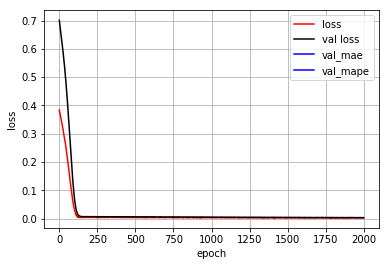

RMSE:119.62672055299113  ,MAE:94.95301327462923  ,MAPE:4.4048267904573635 
RMSE:92.57106000499172  ,MAE:68.44325308248298  ,MAPE:2.9524389188552926 


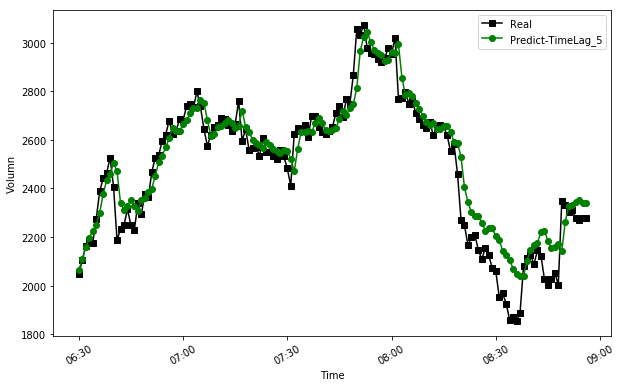

/home/wells/Anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


处理数据: (177, 3)
训练数据: (103, 6)
验证数据: (69, 6)
LSTM预测
Train on 82 samples, validate on 21 samples
Epoch 1/2000
82/82 [==============================] - 5s 56ms/step - loss: 0.2901 - mean_absolute_error: 0.5121 - mean_absolute_percentage_error: 100.4485 - val_loss: 0.4313 - val_mean_absolute_error: 0.6339 - val_mean_absolute_percentage_error: 100.2487
Epoch 2/2000
82/82 [==============================] - 0s 443us/step - loss: 0.2884 - mean_absolute_error: 0.5104 - mean_absolute_percentage_error: 100.0871 - val_loss: 0.4289 - val_mean_absolute_error: 0.6321 - val_mean_absolute_percentage_error: 99.9377
Epoch 3/2000
82/82 [==============================] - 0s 438us/step - loss: 0.2867 - mean_absolute_error: 0.5089 - mean_absolute_percentage_error: 99.7688 - val_loss: 0.4265 - val_mean_absolute_error: 0.6301 - val_mean_absolute_percentage_error: 99.6176
Epoch 4/2000
82/82 [==============================] - 0s 430us/step - loss: 0.2848 - mean_absolute_error: 0.5071 - mean_absolute_percentage_e

Epoch 33/2000
82/82 [==============================] - 0s 357us/step - loss: 0.2282 - mean_absolute_error: 0.4492 - mean_absolute_percentage_error: 86.7291 - val_loss: 0.3456 - val_mean_absolute_error: 0.5628 - val_mean_absolute_percentage_error: 88.3729
Epoch 34/2000
82/82 [==============================] - 0s 400us/step - loss: 0.2259 - mean_absolute_error: 0.4467 - mean_absolute_percentage_error: 86.1943 - val_loss: 0.3423 - val_mean_absolute_error: 0.5599 - val_mean_absolute_percentage_error: 87.8832
Epoch 35/2000
82/82 [==============================] - 0s 356us/step - loss: 0.2233 - mean_absolute_error: 0.4440 - mean_absolute_percentage_error: 85.6078 - val_loss: 0.3390 - val_mean_absolute_error: 0.5569 - val_mean_absolute_percentage_error: 87.3844
Epoch 36/2000
82/82 [==============================] - 0s 359us/step - loss: 0.2213 - mean_absolute_error: 0.4417 - mean_absolute_percentage_error: 85.1331 - val_loss: 0.3356 - val_mean_absolute_error: 0.5539 - val_mean_absolute_percen

82/82 [==============================] - 0s 359us/step - loss: 0.1350 - mean_absolute_error: 0.3338 - mean_absolute_percentage_error: 61.8414 - val_loss: 0.2090 - val_mean_absolute_error: 0.4257 - val_mean_absolute_percentage_error: 65.5143
Epoch 66/2000
82/82 [==============================] - 0s 361us/step - loss: 0.1323 - mean_absolute_error: 0.3297 - mean_absolute_percentage_error: 60.9182 - val_loss: 0.2038 - val_mean_absolute_error: 0.4197 - val_mean_absolute_percentage_error: 64.5034
Epoch 67/2000
82/82 [==============================] - 0s 368us/step - loss: 0.1288 - mean_absolute_error: 0.3250 - mean_absolute_percentage_error: 60.0374 - val_loss: 0.1986 - val_mean_absolute_error: 0.4135 - val_mean_absolute_percentage_error: 63.4746
Epoch 68/2000
82/82 [==============================] - 0s 399us/step - loss: 0.1244 - mean_absolute_error: 0.3189 - mean_absolute_percentage_error: 58.7784 - val_loss: 0.1934 - val_mean_absolute_error: 0.4072 - val_mean_absolute_percentage_error: 62

82/82 [==============================] - 0s 417us/step - loss: 0.0385 - mean_absolute_error: 0.1599 - mean_absolute_percentage_error: 28.8810 - val_loss: 0.0644 - val_mean_absolute_error: 0.1956 - val_mean_absolute_percentage_error: 27.2697
Epoch 98/2000
82/82 [==============================] - 0s 390us/step - loss: 0.0390 - mean_absolute_error: 0.1615 - mean_absolute_percentage_error: 29.1612 - val_loss: 0.0616 - val_mean_absolute_error: 0.1891 - val_mean_absolute_percentage_error: 26.2166
Epoch 99/2000
82/82 [==============================] - 0s 362us/step - loss: 0.0367 - mean_absolute_error: 0.1567 - mean_absolute_percentage_error: 28.4384 - val_loss: 0.0590 - val_mean_absolute_error: 0.1828 - val_mean_absolute_percentage_error: 25.1775
Epoch 100/2000
82/82 [==============================] - 0s 417us/step - loss: 0.0349 - mean_absolute_error: 0.1506 - mean_absolute_percentage_error: 27.5844 - val_loss: 0.0565 - val_mean_absolute_error: 0.1766 - val_mean_absolute_percentage_error: 2

82/82 [==============================] - 0s 337us/step - loss: 0.0197 - mean_absolute_error: 0.1107 - mean_absolute_percentage_error: 24.6352 - val_loss: 0.0304 - val_mean_absolute_error: 0.1312 - val_mean_absolute_percentage_error: 18.7365
Epoch 130/2000
82/82 [==============================] - 0s 345us/step - loss: 0.0191 - mean_absolute_error: 0.1083 - mean_absolute_percentage_error: 24.4202 - val_loss: 0.0303 - val_mean_absolute_error: 0.1313 - val_mean_absolute_percentage_error: 18.7946
Epoch 131/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0195 - mean_absolute_error: 0.1094 - mean_absolute_percentage_error: 24.7760 - val_loss: 0.0302 - val_mean_absolute_error: 0.1314 - val_mean_absolute_percentage_error: 18.8455
Epoch 132/2000
82/82 [==============================] - 0s 348us/step - loss: 0.0190 - mean_absolute_error: 0.1062 - mean_absolute_percentage_error: 24.4213 - val_loss: 0.0301 - val_mean_absolute_error: 0.1315 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 357us/step - loss: 0.0192 - mean_absolute_error: 0.1059 - mean_absolute_percentage_error: 24.6739 - val_loss: 0.0287 - val_mean_absolute_error: 0.1309 - val_mean_absolute_percentage_error: 19.1488
Epoch 162/2000
82/82 [==============================] - 0s 347us/step - loss: 0.0188 - mean_absolute_error: 0.1054 - mean_absolute_percentage_error: 24.9295 - val_loss: 0.0287 - val_mean_absolute_error: 0.1308 - val_mean_absolute_percentage_error: 19.1300
Epoch 163/2000
82/82 [==============================] - 0s 349us/step - loss: 0.0184 - mean_absolute_error: 0.1055 - mean_absolute_percentage_error: 24.4027 - val_loss: 0.0286 - val_mean_absolute_error: 0.1307 - val_mean_absolute_percentage_error: 19.1162
Epoch 164/2000
82/82 [==============================] - 0s 368us/step - loss: 0.0201 - mean_absolute_error: 0.1081 - mean_absolute_percentage_error: 24.9112 - val_loss: 0.0286 - val_mean_absolute_error: 0.1306 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 392us/step - loss: 0.0190 - mean_absolute_error: 0.1044 - mean_absolute_percentage_error: 24.6858 - val_loss: 0.0277 - val_mean_absolute_error: 0.1280 - val_mean_absolute_percentage_error: 18.7281
Epoch 194/2000
82/82 [==============================] - 0s 343us/step - loss: 0.0180 - mean_absolute_error: 0.1040 - mean_absolute_percentage_error: 24.2943 - val_loss: 0.0277 - val_mean_absolute_error: 0.1278 - val_mean_absolute_percentage_error: 18.7020
Epoch 195/2000
82/82 [==============================] - 0s 341us/step - loss: 0.0188 - mean_absolute_error: 0.1049 - mean_absolute_percentage_error: 24.5800 - val_loss: 0.0277 - val_mean_absolute_error: 0.1277 - val_mean_absolute_percentage_error: 18.6739
Epoch 196/2000
82/82 [==============================] - 0s 349us/step - loss: 0.0187 - mean_absolute_error: 0.1054 - mean_absolute_percentage_error: 24.5243 - val_loss: 0.0276 - val_mean_absolute_error: 0.1276 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 376us/step - loss: 0.0176 - mean_absolute_error: 0.1007 - mean_absolute_percentage_error: 23.9148 - val_loss: 0.0267 - val_mean_absolute_error: 0.1242 - val_mean_absolute_percentage_error: 18.1198
Epoch 226/2000
82/82 [==============================] - 0s 399us/step - loss: 0.0174 - mean_absolute_error: 0.1017 - mean_absolute_percentage_error: 23.9716 - val_loss: 0.0267 - val_mean_absolute_error: 0.1241 - val_mean_absolute_percentage_error: 18.0987
Epoch 227/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0176 - mean_absolute_error: 0.1026 - mean_absolute_percentage_error: 24.0222 - val_loss: 0.0266 - val_mean_absolute_error: 0.1240 - val_mean_absolute_percentage_error: 18.0855
Epoch 228/2000
82/82 [==============================] - 0s 337us/step - loss: 0.0184 - mean_absolute_error: 0.1037 - mean_absolute_percentage_error: 24.9634 - val_loss: 0.0266 - val_mean_absolute_error: 0.1239 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 429us/step - loss: 0.0167 - mean_absolute_error: 0.0978 - mean_absolute_percentage_error: 23.0396 - val_loss: 0.0257 - val_mean_absolute_error: 0.1204 - val_mean_absolute_percentage_error: 17.5264
Epoch 258/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0170 - mean_absolute_error: 0.1009 - mean_absolute_percentage_error: 23.9797 - val_loss: 0.0256 - val_mean_absolute_error: 0.1204 - val_mean_absolute_percentage_error: 17.5272
Epoch 259/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0175 - mean_absolute_error: 0.0999 - mean_absolute_percentage_error: 23.7665 - val_loss: 0.0256 - val_mean_absolute_error: 0.1203 - val_mean_absolute_percentage_error: 17.5220
Epoch 260/2000
82/82 [==============================] - 0s 338us/step - loss: 0.0165 - mean_absolute_error: 0.0983 - mean_absolute_percentage_error: 23.2650 - val_loss: 0.0255 - val_mean_absolute_error: 0.1202 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 448us/step - loss: 0.0160 - mean_absolute_error: 0.0991 - mean_absolute_percentage_error: 23.2057 - val_loss: 0.0247 - val_mean_absolute_error: 0.1161 - val_mean_absolute_percentage_error: 16.7900
Epoch 290/2000
82/82 [==============================] - 0s 381us/step - loss: 0.0169 - mean_absolute_error: 0.0993 - mean_absolute_percentage_error: 23.5601 - val_loss: 0.0247 - val_mean_absolute_error: 0.1160 - val_mean_absolute_percentage_error: 16.7749
Epoch 291/2000
82/82 [==============================] - 0s 491us/step - loss: 0.0169 - mean_absolute_error: 0.1007 - mean_absolute_percentage_error: 23.8724 - val_loss: 0.0247 - val_mean_absolute_error: 0.1159 - val_mean_absolute_percentage_error: 16.7586
Epoch 292/2000
82/82 [==============================] - 0s 427us/step - loss: 0.0171 - mean_absolute_error: 0.1010 - mean_absolute_percentage_error: 23.6481 - val_loss: 0.0246 - val_mean_absolute_error: 0.1158 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 411us/step - loss: 0.0157 - mean_absolute_error: 0.0982 - mean_absolute_percentage_error: 23.5608 - val_loss: 0.0236 - val_mean_absolute_error: 0.1121 - val_mean_absolute_percentage_error: 16.2324
Epoch 322/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0157 - mean_absolute_error: 0.0953 - mean_absolute_percentage_error: 22.3312 - val_loss: 0.0235 - val_mean_absolute_error: 0.1120 - val_mean_absolute_percentage_error: 16.2119
Epoch 323/2000
82/82 [==============================] - 0s 412us/step - loss: 0.0152 - mean_absolute_error: 0.0968 - mean_absolute_percentage_error: 23.4006 - val_loss: 0.0235 - val_mean_absolute_error: 0.1118 - val_mean_absolute_percentage_error: 16.1864
Epoch 324/2000
82/82 [==============================] - 0s 441us/step - loss: 0.0150 - mean_absolute_error: 0.0944 - mean_absolute_percentage_error: 22.3675 - val_loss: 0.0235 - val_mean_absolute_error: 0.1117 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 444us/step - loss: 0.0159 - mean_absolute_error: 0.0975 - mean_absolute_percentage_error: 23.3888 - val_loss: 0.0225 - val_mean_absolute_error: 0.1077 - val_mean_absolute_percentage_error: 15.5896
Epoch 354/2000
82/82 [==============================] - 0s 399us/step - loss: 0.0149 - mean_absolute_error: 0.0956 - mean_absolute_percentage_error: 22.6757 - val_loss: 0.0225 - val_mean_absolute_error: 0.1076 - val_mean_absolute_percentage_error: 15.5668
Epoch 355/2000
82/82 [==============================] - 0s 390us/step - loss: 0.0158 - mean_absolute_error: 0.0979 - mean_absolute_percentage_error: 23.3483 - val_loss: 0.0224 - val_mean_absolute_error: 0.1074 - val_mean_absolute_percentage_error: 15.5403
Epoch 356/2000
82/82 [==============================] - 0s 345us/step - loss: 0.0148 - mean_absolute_error: 0.0939 - mean_absolute_percentage_error: 22.6123 - val_loss: 0.0224 - val_mean_absolute_error: 0.1073 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 380us/step - loss: 0.0140 - mean_absolute_error: 0.0919 - mean_absolute_percentage_error: 22.0125 - val_loss: 0.0216 - val_mean_absolute_error: 0.1030 - val_mean_absolute_percentage_error: 14.8299
Epoch 386/2000
82/82 [==============================] - 0s 386us/step - loss: 0.0147 - mean_absolute_error: 0.0936 - mean_absolute_percentage_error: 22.5172 - val_loss: 0.0216 - val_mean_absolute_error: 0.1028 - val_mean_absolute_percentage_error: 14.7943
Epoch 387/2000
82/82 [==============================] - 0s 377us/step - loss: 0.0135 - mean_absolute_error: 0.0915 - mean_absolute_percentage_error: 21.8807 - val_loss: 0.0216 - val_mean_absolute_error: 0.1026 - val_mean_absolute_percentage_error: 14.7622
Epoch 388/2000
82/82 [==============================] - 0s 417us/step - loss: 0.0137 - mean_absolute_error: 0.0901 - mean_absolute_percentage_error: 21.8490 - val_loss: 0.0215 - val_mean_absolute_error: 0.1025 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 421us/step - loss: 0.0141 - mean_absolute_error: 0.0913 - mean_absolute_percentage_error: 22.1380 - val_loss: 0.0208 - val_mean_absolute_error: 0.0983 - val_mean_absolute_percentage_error: 14.0754
Epoch 418/2000
82/82 [==============================] - 0s 581us/step - loss: 0.0145 - mean_absolute_error: 0.0943 - mean_absolute_percentage_error: 22.4960 - val_loss: 0.0208 - val_mean_absolute_error: 0.0981 - val_mean_absolute_percentage_error: 14.0429
Epoch 419/2000
82/82 [==============================] - 0s 446us/step - loss: 0.0127 - mean_absolute_error: 0.0876 - mean_absolute_percentage_error: 21.2051 - val_loss: 0.0208 - val_mean_absolute_error: 0.0980 - val_mean_absolute_percentage_error: 14.0224
Epoch 420/2000
82/82 [==============================] - 0s 467us/step - loss: 0.0129 - mean_absolute_error: 0.0887 - mean_absolute_percentage_error: 21.4656 - val_loss: 0.0207 - val_mean_absolute_error: 0.0978 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 369us/step - loss: 0.0138 - mean_absolute_error: 0.0909 - mean_absolute_percentage_error: 21.6498 - val_loss: 0.0199 - val_mean_absolute_error: 0.0946 - val_mean_absolute_percentage_error: 13.5807
Epoch 450/2000
82/82 [==============================] - 0s 416us/step - loss: 0.0128 - mean_absolute_error: 0.0879 - mean_absolute_percentage_error: 21.2367 - val_loss: 0.0199 - val_mean_absolute_error: 0.0945 - val_mean_absolute_percentage_error: 13.5677
Epoch 451/2000
82/82 [==============================] - 0s 374us/step - loss: 0.0137 - mean_absolute_error: 0.0888 - mean_absolute_percentage_error: 21.6449 - val_loss: 0.0199 - val_mean_absolute_error: 0.0944 - val_mean_absolute_percentage_error: 13.5543
Epoch 452/2000
82/82 [==============================] - 0s 416us/step - loss: 0.0139 - mean_absolute_error: 0.0908 - mean_absolute_percentage_error: 21.8382 - val_loss: 0.0199 - val_mean_absolute_error: 0.0943 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 367us/step - loss: 0.0128 - mean_absolute_error: 0.0858 - mean_absolute_percentage_error: 20.9484 - val_loss: 0.0193 - val_mean_absolute_error: 0.0918 - val_mean_absolute_percentage_error: 13.1929
Epoch 482/2000
82/82 [==============================] - 0s 405us/step - loss: 0.0116 - mean_absolute_error: 0.0829 - mean_absolute_percentage_error: 19.9462 - val_loss: 0.0192 - val_mean_absolute_error: 0.0917 - val_mean_absolute_percentage_error: 13.1836
Epoch 483/2000
82/82 [==============================] - 0s 340us/step - loss: 0.0130 - mean_absolute_error: 0.0870 - mean_absolute_percentage_error: 20.9770 - val_loss: 0.0192 - val_mean_absolute_error: 0.0915 - val_mean_absolute_percentage_error: 13.1737
Epoch 484/2000
82/82 [==============================] - 0s 348us/step - loss: 0.0126 - mean_absolute_error: 0.0856 - mean_absolute_percentage_error: 20.9569 - val_loss: 0.0191 - val_mean_absolute_error: 0.0914 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 423us/step - loss: 0.0126 - mean_absolute_error: 0.0859 - mean_absolute_percentage_error: 21.1726 - val_loss: 0.0187 - val_mean_absolute_error: 0.0892 - val_mean_absolute_percentage_error: 12.8426
Epoch 514/2000
82/82 [==============================] - 0s 364us/step - loss: 0.0123 - mean_absolute_error: 0.0843 - mean_absolute_percentage_error: 20.3485 - val_loss: 0.0187 - val_mean_absolute_error: 0.0891 - val_mean_absolute_percentage_error: 12.8322
Epoch 515/2000
82/82 [==============================] - 0s 399us/step - loss: 0.0122 - mean_absolute_error: 0.0867 - mean_absolute_percentage_error: 21.2361 - val_loss: 0.0186 - val_mean_absolute_error: 0.0890 - val_mean_absolute_percentage_error: 12.8217
Epoch 516/2000
82/82 [==============================] - 0s 348us/step - loss: 0.0123 - mean_absolute_error: 0.0853 - mean_absolute_percentage_error: 20.7464 - val_loss: 0.0186 - val_mean_absolute_error: 0.0890 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 333us/step - loss: 0.0110 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 19.8960 - val_loss: 0.0183 - val_mean_absolute_error: 0.0870 - val_mean_absolute_percentage_error: 12.5071
Epoch 546/2000
82/82 [==============================] - 0s 373us/step - loss: 0.0126 - mean_absolute_error: 0.0868 - mean_absolute_percentage_error: 21.2553 - val_loss: 0.0183 - val_mean_absolute_error: 0.0869 - val_mean_absolute_percentage_error: 12.4974
Epoch 547/2000
82/82 [==============================] - 0s 352us/step - loss: 0.0125 - mean_absolute_error: 0.0898 - mean_absolute_percentage_error: 21.7309 - val_loss: 0.0183 - val_mean_absolute_error: 0.0868 - val_mean_absolute_percentage_error: 12.4922
Epoch 548/2000
82/82 [==============================] - 0s 377us/step - loss: 0.0122 - mean_absolute_error: 0.0859 - mean_absolute_percentage_error: 20.5525 - val_loss: 0.0183 - val_mean_absolute_error: 0.0868 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 348us/step - loss: 0.0114 - mean_absolute_error: 0.0821 - mean_absolute_percentage_error: 19.8847 - val_loss: 0.0180 - val_mean_absolute_error: 0.0856 - val_mean_absolute_percentage_error: 12.3732
Epoch 578/2000
82/82 [==============================] - 0s 357us/step - loss: 0.0128 - mean_absolute_error: 0.0844 - mean_absolute_percentage_error: 20.7660 - val_loss: 0.0179 - val_mean_absolute_error: 0.0856 - val_mean_absolute_percentage_error: 12.3704
Epoch 579/2000
82/82 [==============================] - 0s 324us/step - loss: 0.0106 - mean_absolute_error: 0.0799 - mean_absolute_percentage_error: 19.4444 - val_loss: 0.0179 - val_mean_absolute_error: 0.0855 - val_mean_absolute_percentage_error: 12.3654
Epoch 580/2000
82/82 [==============================] - 0s 344us/step - loss: 0.0125 - mean_absolute_error: 0.0850 - mean_absolute_percentage_error: 20.7776 - val_loss: 0.0179 - val_mean_absolute_error: 0.0854 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 342us/step - loss: 0.0106 - mean_absolute_error: 0.0802 - mean_absolute_percentage_error: 19.7233 - val_loss: 0.0177 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 12.3695
Epoch 610/2000
82/82 [==============================] - 0s 350us/step - loss: 0.0108 - mean_absolute_error: 0.0782 - mean_absolute_percentage_error: 19.1722 - val_loss: 0.0177 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 12.3686
Epoch 611/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0111 - mean_absolute_error: 0.0815 - mean_absolute_percentage_error: 20.1125 - val_loss: 0.0176 - val_mean_absolute_error: 0.0850 - val_mean_absolute_percentage_error: 12.3658
Epoch 612/2000
82/82 [==============================] - 0s 340us/step - loss: 0.0116 - mean_absolute_error: 0.0829 - mean_absolute_percentage_error: 20.1276 - val_loss: 0.0176 - val_mean_absolute_error: 0.0849 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 347us/step - loss: 0.0107 - mean_absolute_error: 0.0791 - mean_absolute_percentage_error: 19.7789 - val_loss: 0.0175 - val_mean_absolute_error: 0.0845 - val_mean_absolute_percentage_error: 12.3669
Epoch 642/2000
82/82 [==============================] - 0s 356us/step - loss: 0.0107 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 19.1502 - val_loss: 0.0175 - val_mean_absolute_error: 0.0846 - val_mean_absolute_percentage_error: 12.3730
Epoch 643/2000
82/82 [==============================] - 0s 353us/step - loss: 0.0108 - mean_absolute_error: 0.0800 - mean_absolute_percentage_error: 19.5303 - val_loss: 0.0175 - val_mean_absolute_error: 0.0845 - val_mean_absolute_percentage_error: 12.3662
Epoch 644/2000
82/82 [==============================] - 0s 361us/step - loss: 0.0108 - mean_absolute_error: 0.0789 - mean_absolute_percentage_error: 19.0917 - val_loss: 0.0174 - val_mean_absolute_error: 0.0842 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 393us/step - loss: 0.0109 - mean_absolute_error: 0.0807 - mean_absolute_percentage_error: 19.7856 - val_loss: 0.0172 - val_mean_absolute_error: 0.0834 - val_mean_absolute_percentage_error: 12.2986
Epoch 674/2000
82/82 [==============================] - 0s 330us/step - loss: 0.0110 - mean_absolute_error: 0.0784 - mean_absolute_percentage_error: 19.6179 - val_loss: 0.0173 - val_mean_absolute_error: 0.0837 - val_mean_absolute_percentage_error: 12.3292
Epoch 675/2000
82/82 [==============================] - 0s 332us/step - loss: 0.0116 - mean_absolute_error: 0.0814 - mean_absolute_percentage_error: 20.0468 - val_loss: 0.0173 - val_mean_absolute_error: 0.0840 - val_mean_absolute_percentage_error: 12.3605
Epoch 676/2000
82/82 [==============================] - 0s 509us/step - loss: 0.0101 - mean_absolute_error: 0.0757 - mean_absolute_percentage_error: 18.5389 - val_loss: 0.0174 - val_mean_absolute_error: 0.0842 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 334us/step - loss: 0.0108 - mean_absolute_error: 0.0811 - mean_absolute_percentage_error: 19.5491 - val_loss: 0.0174 - val_mean_absolute_error: 0.0844 - val_mean_absolute_percentage_error: 12.4465
Epoch 706/2000
82/82 [==============================] - 0s 331us/step - loss: 0.0107 - mean_absolute_error: 0.0785 - mean_absolute_percentage_error: 19.3147 - val_loss: 0.0173 - val_mean_absolute_error: 0.0843 - val_mean_absolute_percentage_error: 12.4332
Epoch 707/2000
82/82 [==============================] - 0s 339us/step - loss: 0.0110 - mean_absolute_error: 0.0795 - mean_absolute_percentage_error: 19.5566 - val_loss: 0.0173 - val_mean_absolute_error: 0.0842 - val_mean_absolute_percentage_error: 12.4210
Epoch 708/2000
82/82 [==============================] - 0s 377us/step - loss: 0.0106 - mean_absolute_error: 0.0796 - mean_absolute_percentage_error: 19.4929 - val_loss: 0.0173 - val_mean_absolute_error: 0.0841 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 382us/step - loss: 0.0112 - mean_absolute_error: 0.0801 - mean_absolute_percentage_error: 19.6491 - val_loss: 0.0172 - val_mean_absolute_error: 0.0835 - val_mean_absolute_percentage_error: 12.3805
Epoch 738/2000
82/82 [==============================] - 0s 401us/step - loss: 0.0107 - mean_absolute_error: 0.0791 - mean_absolute_percentage_error: 19.4116 - val_loss: 0.0172 - val_mean_absolute_error: 0.0836 - val_mean_absolute_percentage_error: 12.3920
Epoch 739/2000
82/82 [==============================] - 0s 349us/step - loss: 0.0113 - mean_absolute_error: 0.0819 - mean_absolute_percentage_error: 19.8371 - val_loss: 0.0172 - val_mean_absolute_error: 0.0836 - val_mean_absolute_percentage_error: 12.3946
Epoch 740/2000
82/82 [==============================] - 0s 370us/step - loss: 0.0107 - mean_absolute_error: 0.0792 - mean_absolute_percentage_error: 19.4922 - val_loss: 0.0172 - val_mean_absolute_error: 0.0835 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 322us/step - loss: 0.0105 - mean_absolute_error: 0.0770 - mean_absolute_percentage_error: 18.8981 - val_loss: 0.0171 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error: 12.3158
Epoch 770/2000
82/82 [==============================] - 0s 319us/step - loss: 0.0104 - mean_absolute_error: 0.0805 - mean_absolute_percentage_error: 19.6728 - val_loss: 0.0171 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3238
Epoch 771/2000
82/82 [==============================] - 0s 324us/step - loss: 0.0096 - mean_absolute_error: 0.0759 - mean_absolute_percentage_error: 18.5787 - val_loss: 0.0171 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3235
Epoch 772/2000
82/82 [==============================] - 0s 347us/step - loss: 0.0111 - mean_absolute_error: 0.0809 - mean_absolute_percentage_error: 19.8477 - val_loss: 0.0171 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 338us/step - loss: 0.0103 - mean_absolute_error: 0.0799 - mean_absolute_percentage_error: 19.5978 - val_loss: 0.0171 - val_mean_absolute_error: 0.0826 - val_mean_absolute_percentage_error: 12.3314
Epoch 802/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0093 - mean_absolute_error: 0.0743 - mean_absolute_percentage_error: 18.5891 - val_loss: 0.0172 - val_mean_absolute_error: 0.0827 - val_mean_absolute_percentage_error: 12.3472
Epoch 803/2000
82/82 [==============================] - 0s 330us/step - loss: 0.0108 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 19.6345 - val_loss: 0.0172 - val_mean_absolute_error: 0.0830 - val_mean_absolute_percentage_error: 12.3717
Epoch 804/2000
82/82 [==============================] - 0s 339us/step - loss: 0.0104 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 19.0111 - val_loss: 0.0172 - val_mean_absolute_error: 0.0831 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 325us/step - loss: 0.0103 - mean_absolute_error: 0.0768 - mean_absolute_percentage_error: 18.9357 - val_loss: 0.0171 - val_mean_absolute_error: 0.0824 - val_mean_absolute_percentage_error: 12.3041
Epoch 834/2000
82/82 [==============================] - 0s 318us/step - loss: 0.0100 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.6232 - val_loss: 0.0172 - val_mean_absolute_error: 0.0825 - val_mean_absolute_percentage_error: 12.3198
Epoch 835/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0099 - mean_absolute_error: 0.0774 - mean_absolute_percentage_error: 19.2642 - val_loss: 0.0172 - val_mean_absolute_error: 0.0825 - val_mean_absolute_percentage_error: 12.3209
Epoch 836/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0101 - mean_absolute_error: 0.0775 - mean_absolute_percentage_error: 19.0875 - val_loss: 0.0171 - val_mean_absolute_error: 0.0824 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 338us/step - loss: 0.0098 - mean_absolute_error: 0.0763 - mean_absolute_percentage_error: 18.9159 - val_loss: 0.0170 - val_mean_absolute_error: 0.0814 - val_mean_absolute_percentage_error: 12.1962
Epoch 866/2000
82/82 [==============================] - 0s 365us/step - loss: 0.0102 - mean_absolute_error: 0.0766 - mean_absolute_percentage_error: 18.7408 - val_loss: 0.0170 - val_mean_absolute_error: 0.0813 - val_mean_absolute_percentage_error: 12.1817
Epoch 867/2000
82/82 [==============================] - 0s 341us/step - loss: 0.0102 - mean_absolute_error: 0.0779 - mean_absolute_percentage_error: 18.9921 - val_loss: 0.0170 - val_mean_absolute_error: 0.0812 - val_mean_absolute_percentage_error: 12.1657
Epoch 868/2000
82/82 [==============================] - 0s 351us/step - loss: 0.0099 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 18.1989 - val_loss: 0.0170 - val_mean_absolute_error: 0.0810 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 351us/step - loss: 0.0104 - mean_absolute_error: 0.0812 - mean_absolute_percentage_error: 19.5666 - val_loss: 0.0170 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error: 12.1304
Epoch 898/2000
82/82 [==============================] - 0s 348us/step - loss: 0.0089 - mean_absolute_error: 0.0701 - mean_absolute_percentage_error: 17.4115 - val_loss: 0.0170 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error: 12.1252
Epoch 899/2000
82/82 [==============================] - 0s 374us/step - loss: 0.0102 - mean_absolute_error: 0.0780 - mean_absolute_percentage_error: 19.0934 - val_loss: 0.0170 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error: 12.1279
Epoch 900/2000
82/82 [==============================] - 0s 349us/step - loss: 0.0098 - mean_absolute_error: 0.0745 - mean_absolute_percentage_error: 18.2272 - val_loss: 0.0170 - val_mean_absolute_error: 0.0809 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 321us/step - loss: 0.0099 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.8488 - val_loss: 0.0169 - val_mean_absolute_error: 0.0795 - val_mean_absolute_percentage_error: 11.9528
Epoch 930/2000
82/82 [==============================] - 0s 352us/step - loss: 0.0105 - mean_absolute_error: 0.0804 - mean_absolute_percentage_error: 19.4460 - val_loss: 0.0169 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 11.9496
Epoch 931/2000
82/82 [==============================] - 0s 348us/step - loss: 0.0096 - mean_absolute_error: 0.0763 - mean_absolute_percentage_error: 18.4398 - val_loss: 0.0169 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 11.9485
Epoch 932/2000
82/82 [==============================] - 0s 353us/step - loss: 0.0097 - mean_absolute_error: 0.0746 - mean_absolute_percentage_error: 18.5541 - val_loss: 0.0169 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 328us/step - loss: 0.0101 - mean_absolute_error: 0.0776 - mean_absolute_percentage_error: 18.7143 - val_loss: 0.0169 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 11.9377
Epoch 962/2000
82/82 [==============================] - 0s 323us/step - loss: 0.0105 - mean_absolute_error: 0.0783 - mean_absolute_percentage_error: 18.7564 - val_loss: 0.0169 - val_mean_absolute_error: 0.0794 - val_mean_absolute_percentage_error: 11.9392
Epoch 963/2000
82/82 [==============================] - 0s 388us/step - loss: 0.0099 - mean_absolute_error: 0.0751 - mean_absolute_percentage_error: 18.2525 - val_loss: 0.0169 - val_mean_absolute_error: 0.0793 - val_mean_absolute_percentage_error: 11.9225
Epoch 964/2000
82/82 [==============================] - 0s 409us/step - loss: 0.0097 - mean_absolute_error: 0.0755 - mean_absolute_percentage_error: 18.4022 - val_loss: 0.0169 - val_mean_absolute_error: 0.0791 - val_mean_absolute_percentage_error:

82/82 [==============================] - 0s 332us/step - loss: 0.0101 - mean_absolute_error: 0.0798 - mean_absolute_percentage_error: 19.0866 - val_loss: 0.0167 - val_mean_absolute_error: 0.0780 - val_mean_absolute_percentage_error: 11.7475
Epoch 994/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0090 - mean_absolute_error: 0.0730 - mean_absolute_percentage_error: 17.9405 - val_loss: 0.0167 - val_mean_absolute_error: 0.0781 - val_mean_absolute_percentage_error: 11.7574
Epoch 995/2000
82/82 [==============================] - 0s 333us/step - loss: 0.0093 - mean_absolute_error: 0.0742 - mean_absolute_percentage_error: 17.9489 - val_loss: 0.0167 - val_mean_absolute_error: 0.0782 - val_mean_absolute_percentage_error: 11.7715
Epoch 996/2000
82/82 [==============================] - 0s 352us/step - loss: 0.0098 - mean_absolute_error: 0.0769 - mean_absolute_percentage_error: 18.7607 - val_loss: 0.0167 - val_mean_absolute_error: 0.0782 - val_mean_absolute_percentage_error:

Epoch 1025/2000
82/82 [==============================] - 0s 370us/step - loss: 0.0104 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.7400 - val_loss: 0.0167 - val_mean_absolute_error: 0.0771 - val_mean_absolute_percentage_error: 11.6499
Epoch 1026/2000
82/82 [==============================] - 0s 353us/step - loss: 0.0098 - mean_absolute_error: 0.0755 - mean_absolute_percentage_error: 18.4442 - val_loss: 0.0166 - val_mean_absolute_error: 0.0770 - val_mean_absolute_percentage_error: 11.6405
Epoch 1027/2000
82/82 [==============================] - 0s 412us/step - loss: 0.0109 - mean_absolute_error: 0.0799 - mean_absolute_percentage_error: 19.0170 - val_loss: 0.0166 - val_mean_absolute_error: 0.0768 - val_mean_absolute_percentage_error: 11.6204
Epoch 1028/2000
82/82 [==============================] - 0s 339us/step - loss: 0.0093 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 18.2236 - val_loss: 0.0166 - val_mean_absolute_error: 0.0767 - val_mean_absolut

Epoch 1057/2000
82/82 [==============================] - 0s 390us/step - loss: 0.0090 - mean_absolute_error: 0.0734 - mean_absolute_percentage_error: 17.9585 - val_loss: 0.0167 - val_mean_absolute_error: 0.0773 - val_mean_absolute_percentage_error: 11.6795
Epoch 1058/2000
82/82 [==============================] - 0s 392us/step - loss: 0.0103 - mean_absolute_error: 0.0789 - mean_absolute_percentage_error: 18.7393 - val_loss: 0.0167 - val_mean_absolute_error: 0.0771 - val_mean_absolute_percentage_error: 11.6635
Epoch 1059/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0097 - mean_absolute_error: 0.0761 - mean_absolute_percentage_error: 18.6373 - val_loss: 0.0167 - val_mean_absolute_error: 0.0771 - val_mean_absolute_percentage_error: 11.6567
Epoch 1060/2000
82/82 [==============================] - 0s 341us/step - loss: 0.0099 - mean_absolute_error: 0.0753 - mean_absolute_percentage_error: 18.3823 - val_loss: 0.0167 - val_mean_absolute_error: 0.0770 - val_mean_absolut

Epoch 1089/2000
82/82 [==============================] - 0s 331us/step - loss: 0.0094 - mean_absolute_error: 0.0744 - mean_absolute_percentage_error: 18.4241 - val_loss: 0.0168 - val_mean_absolute_error: 0.0772 - val_mean_absolute_percentage_error: 11.6709
Epoch 1090/2000
82/82 [==============================] - 0s 329us/step - loss: 0.0096 - mean_absolute_error: 0.0771 - mean_absolute_percentage_error: 18.5194 - val_loss: 0.0168 - val_mean_absolute_error: 0.0772 - val_mean_absolute_percentage_error: 11.6689
Epoch 1091/2000
82/82 [==============================] - 0s 328us/step - loss: 0.0091 - mean_absolute_error: 0.0743 - mean_absolute_percentage_error: 18.0582 - val_loss: 0.0168 - val_mean_absolute_error: 0.0772 - val_mean_absolute_percentage_error: 11.6742
Epoch 1092/2000
82/82 [==============================] - 0s 326us/step - loss: 0.0096 - mean_absolute_error: 0.0748 - mean_absolute_percentage_error: 18.0439 - val_loss: 0.0168 - val_mean_absolute_error: 0.0772 - val_mean_absolut

Epoch 1121/2000
82/82 [==============================] - 0s 363us/step - loss: 0.0095 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 17.9210 - val_loss: 0.0166 - val_mean_absolute_error: 0.0756 - val_mean_absolute_percentage_error: 11.4836
Epoch 1122/2000
82/82 [==============================] - 0s 380us/step - loss: 0.0098 - mean_absolute_error: 0.0767 - mean_absolute_percentage_error: 18.2658 - val_loss: 0.0166 - val_mean_absolute_error: 0.0757 - val_mean_absolute_percentage_error: 11.4929
Epoch 1123/2000
82/82 [==============================] - 0s 373us/step - loss: 0.0090 - mean_absolute_error: 0.0736 - mean_absolute_percentage_error: 17.8033 - val_loss: 0.0167 - val_mean_absolute_error: 0.0758 - val_mean_absolute_percentage_error: 11.5038
Epoch 1124/2000
82/82 [==============================] - 0s 371us/step - loss: 0.0093 - mean_absolute_error: 0.0728 - mean_absolute_percentage_error: 17.6462 - val_loss: 0.0167 - val_mean_absolute_error: 0.0758 - val_mean_absolut

Epoch 1153/2000
82/82 [==============================] - 0s 353us/step - loss: 0.0090 - mean_absolute_error: 0.0735 - mean_absolute_percentage_error: 17.8412 - val_loss: 0.0167 - val_mean_absolute_error: 0.0757 - val_mean_absolute_percentage_error: 11.4924
Epoch 1154/2000
82/82 [==============================] - 0s 342us/step - loss: 0.0090 - mean_absolute_error: 0.0713 - mean_absolute_percentage_error: 17.4710 - val_loss: 0.0167 - val_mean_absolute_error: 0.0756 - val_mean_absolute_percentage_error: 11.4817
Epoch 1155/2000
82/82 [==============================] - 0s 351us/step - loss: 0.0092 - mean_absolute_error: 0.0719 - mean_absolute_percentage_error: 17.5150 - val_loss: 0.0167 - val_mean_absolute_error: 0.0754 - val_mean_absolute_percentage_error: 11.4626
Epoch 1156/2000
82/82 [==============================] - 0s 334us/step - loss: 0.0097 - mean_absolute_error: 0.0738 - mean_absolute_percentage_error: 18.1535 - val_loss: 0.0167 - val_mean_absolute_error: 0.0754 - val_mean_absolut

Epoch 1185/2000
82/82 [==============================] - 0s 378us/step - loss: 0.0092 - mean_absolute_error: 0.0721 - mean_absolute_percentage_error: 17.2541 - val_loss: 0.0167 - val_mean_absolute_error: 0.0753 - val_mean_absolute_percentage_error: 11.4460
Epoch 1186/2000
82/82 [==============================] - 0s 352us/step - loss: 0.0095 - mean_absolute_error: 0.0736 - mean_absolute_percentage_error: 17.9198 - val_loss: 0.0167 - val_mean_absolute_error: 0.0749 - val_mean_absolute_percentage_error: 11.3966
Epoch 1187/2000
82/82 [==============================] - 0s 360us/step - loss: 0.0101 - mean_absolute_error: 0.0747 - mean_absolute_percentage_error: 18.1934 - val_loss: 0.0166 - val_mean_absolute_error: 0.0745 - val_mean_absolute_percentage_error: 11.3544
Epoch 1188/2000
82/82 [==============================] - 0s 372us/step - loss: 0.0098 - mean_absolute_error: 0.0740 - mean_absolute_percentage_error: 17.7931 - val_loss: 0.0166 - val_mean_absolute_error: 0.0744 - val_mean_absolut

In [ ]:
params = {
          'Timescale':5,
          'TimeLag':5,
          'lr': 1e-4,
          'nb_hidden_cell': [80,80],
          'epochs': 2000,
          'batch_size': 30,
          'pic_path':r'/home/wells/Wells/OfficialWork/SIOA/TrafficFlowForecast/ResultPic',
          'TrainTestSplit':0.6}

for mode in ['full', 'Test_only']:
    for time_scale in [5,15,30]:
        params = {
          'Timescale':time_scale,
          'TimeLag':5,
          'lr': 1e-4,
          'nb_hidden_cell': [80,80],
          'epochs': 2000,
          'batch_size': 30,
          'pic_path':r'/home/wells/Wells/OfficialWork/SIOA/TrafficFlowForecast/ResultPic',
          'TrainTestSplit':0.6}
        fitted_model,TimeSeries,time_container,mm_scaler = lstm_predict(data_pd,params)
        predict_and_plot(fitted_model, TimeSeries,time_container,mm_scaler,params, mode=mode)